# 1. Importing, Cleaning, and Merging Datasets

## Import packages and dataset

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import yfinance as yf
import statsmodels.formula.api as smf
import glob
warnings.filterwarnings('ignore')

In [2]:
!pip install pyarrow

# Importing Cleaned Data

In [3]:
# download risk free rate from yahoo finance
# Import IRX data, which is 13 weeks treasury bill!
irxdata              = yf.Ticker('^IRX').history(period="max")
irxdata['DATE']      = pd.to_datetime(irxdata.index.date)
irxdata['yearmonth'] = irxdata.index.year*100 + irxdata.index.month
irxdata              = irxdata.loc[irxdata['yearmonth'] < irxdata['yearmonth'].shift(-1)]# to only keep the end of the month data

# Adjust the DATE to the last date of each month, (For example, if 1960-02-29 refret is 0.003325, this means if i invest in risk-free from 1960-02-01, i can get a return of 0.3325%)
irxdata['DATE']      = irxdata['DATE'] + MonthEnd(0)
irxdata['rfret']     = irxdata['Close'].shift() / 100 / 12
irxdata              = irxdata.reset_index(drop=True).set_index('DATE')
irxdata              = irxdata[['rfret']].dropna()
irxdata.head()

rfret
DATE                
1960-02-29  0.003325
1960-03-31  0.003492
1960-04-30  0.002517
1960-05-31  0.002533
1960-06-30  0.002600

In [4]:
df = pd.read_feather('crsp_compustat_combined.feather')

In [5]:
df = df.reset_index().set_index('DATE').merge(irxdata, how='left', on='DATE')

In [6]:
# we only want to study sample after 1970, because the data quality is higher!(lesser missing value)
df = df[df.index.get_level_values('DATE') > '1970-01-01']
df = df[df.index.get_level_values('DATE') < '2023-12-01'] # some annual data is not available when doing this research

In [7]:
df = df.reset_index().set_index(['PERMNO','DATE']).sort_index()

In [8]:
df

index    NAMEENDT  SHRCD  EXCHCD   SICCD    NCUSIP  \
PERMNO DATE                                                               
10000  1986-10-31       10        None   10.0     3.0  3990.0  68391610   
       1986-11-30       11        None   10.0     3.0  3990.0  68391610   
       1986-12-31       12  1987-03-09   10.0     3.0  3990.0  68391610   
       1987-01-31       13        None   10.0     3.0  3990.0  68391610   
       1987-02-28       14        None   10.0     3.0  3990.0  68391610   
...                    ...         ...    ...     ...     ...       ...   
93436  2023-07-31  5100999        None   11.0     3.0  9999.0  88160R10   
       2023-08-31  5101000        None   11.0     3.0  9999.0  88160R10   
       2023-09-30  5101001        None   11.0     3.0  9999.0  88160R10   
       2023-10-31  5101002        None   11.0     3.0  9999.0  88160R10   
       2023-11-30  5101003        None   11.0     3.0  9999.0  88160R10   

                  TICKER                     COMNAM SHRCLS TSYMBOL  ...  \
PERMNO DATE                                                         ...   
10000  1986-10-31  OMFGA  OPTIMUM MANUFACTURING INC      A   OMFGA  ...   
       1986-11-30  OMFGA  OPTIMUM MANUFACTURING INC      A   OMFGA  ...   
       1986-12-31  OMFGA  OPTIMUM MANUFACTURING INC      A   OMFAC  ...   
       1987-01-31  OMFGA  OPTIMUM MANUFACTURING INC      A   OMFAC  ...   
       1987-02-28  OMFGA  OPTIMUM MANUFACTURING INC      A   OMFAC  ...   
...                  ...                        ...    ...     ...  ...   
93436  2023-07-31   TSLA                  TESLA INC   None    TSLA  ...   
       2023-08-31   TSLA                  TESLA INC   None    TSLA  ...   
       2023-09-30   TSLA                  TESLA INC   None    TSLA  ...   
       2023-10-31   TSLA                  TESLA INC   None    TSLA  ...   
       2023-11-30   TSLA                  TESLA INC   None    TSLA  ...   

                    sale fincf ivncf oancf      LINKDT   LINKENDDT  LINKPRIM  \
PERMNO DATE                                                                    
10000  1986-10-31  1.026   NaN   NaN   NaN  1986-01-07  1987-06-30         P   
       1986-11-30    NaN   NaN   NaN   NaN  1986-01-07  1987-06-30      None   
       1986-12-31    NaN   NaN   NaN   NaN  1986-01-07  1987-06-30      None   
       1987-01-31    NaN   NaN   NaN   NaN  1986-01-07  1987-06-30      None   
       1987-02-28    NaN   NaN   NaN   NaN  1986-01-07  1987-06-30      None   
...                  ...   ...   ...   ...         ...         ...       ...   
93436  2023-07-31    NaN   NaN   NaN   NaN  2010-06-29  2024-04-30      None   
       2023-08-31    NaN   NaN   NaN   NaN  2010-06-29  2024-04-30      None   
       2023-09-30    NaN   NaN   NaN   NaN  2010-06-29  2024-04-30      None   
       2023-10-31    NaN   NaN   NaN   NaN  2010-06-29  2024-04-30      None   
       2023-11-30    NaN   NaN   NaN   NaN  2010-06-29  2024-04-30      None   

                  LIID LINKTYPE     rfret  
PERMNO DATE                                
10000  1986-10-31   01       LU  0.004333  
       1986-11-30  nan     None  0.004333  
       1986-12-31  nan     None  0.004492  
       1987-01-31  nan     None  0.004725  
       1987-02-28  nan     None  0.004667  
...                ...      ...       ...  
93436  2023-07-31  nan     None  0.004294  
       2023-08-31  nan     None  0.004373  
       2023-09-30  nan     None  0.004415  
       2023-10-31  nan     None  0.004417  
       2023-11-30  nan     None  0.004433  

[2580084 rows x 80 columns]

# 2. Factors Formation

## Sector Herding/Familiarity

In [9]:
# define money weighted volumn for each industry
df['MONEY_TRADE'] = (df['VOL']*df['PRC'])
Industry_ew_money_trade = df.groupby(['DATE','SICCD'])['MONEY_TRADE'].mean()

In [10]:
# Calculating z-score for each sector's MONEY TRADE(Capital Flow)
window_volumn_statistics = 12
rolling_mean = Industry_ew_money_trade.groupby('SICCD').rolling(window_volumn_statistics).mean().droplevel(0)
rolling_std = Industry_ew_money_trade.groupby('SICCD').rolling(window_volumn_statistics).std().droplevel(0)
zscore_ew_industry_money_trade= (Industry_ew_money_trade - rolling_mean)/rolling_std

In [11]:
df = df.reset_index().set_index(['DATE','SICCD'])
df['Sector Familiarity EW Factor'] = zscore_ew_industry_money_trade
df = df.reset_index().set_index(['PERMNO','DATE'])
df['lag Sector Familiarity EW Factor'] = df['Sector Familiarity EW Factor'].groupby('PERMNO').shift(1)

In [12]:
# I am doing something a little unusual here because the z-score is same for lots of stock within the same industry at the same date.
# I add a very very little random number to make the factor having less common value, so later qcut can work! This should not affect the factor performance.
df['lag Sector Familiarity EW Factor']= df['lag Sector Familiarity EW Factor'] + np.random.normal(loc=0, scale=0.0001, size=(len(df['lag Sector Familiarity EW Factor'])))

## Neural Network CNN 3 layers on technical indicators (binanry classification probability)
the NN predict the probability of beating median

In [13]:
path = 'NN_result_TA/Hedge_fund_project_predicted_value/*.feather'
files = glob.glob(path)

temp_dfs = []
for file in files:
  temp_df = pd.read_feather(file)
  temp_dfs.append(temp_df)

# Combine all DataFrames into a single DataFrame
df_cnn = pd.concat(temp_dfs)

df_cnn['date'] = pd.to_datetime(df_cnn['date'] )


In [14]:
df_cnn = pd.DataFrame(df_cnn.set_index(['PERMNO', 'date'])['p(1)'])

In [15]:
df_cnn['Year'] = pd.to_datetime(df_cnn.index.get_level_values('date')).year
df_cnn['Month'] = pd.to_datetime(df_cnn.index.get_level_values('date')).month
df_cnn['day'] = pd.to_datetime(df_cnn.index.get_level_values('date')).day
df_cnn = df_cnn.groupby(['PERMNO','Year','Month']).tail(1)
df_cnn = df_cnn.reset_index()
df_cnn['date'] = df_cnn['date']+MonthEnd(0)
df_cnn = df_cnn.set_index(['PERMNO','date'])
df_cnn  = pd.DataFrame(df_cnn['p(1)'])

In [16]:

# From the data imported, when month Frebuary, it means at the last date of Febuary, what's the predicted probability of the stock beating the media in the next month
# As a result, this will be the signal on the first day of the next month.
# we have to shift(1) to make it happen
df_cnn = df_cnn.groupby('PERMNO').shift(1)

In [17]:
df = pd.concat((df, df_cnn['p(1)'] ), axis =1)
df.index.names = ['PERMNO', 'DATE']
# add some random noise to make qcut easilier 
df['p(1)'] = df['p(1)'] + np.random.normal(0, 0.0001, df.shape[0])
df= df.rename({'p(1)':'lag cnn_p'},axis =1)

In [18]:
df

SICCD  index    NAMEENDT  SHRCD  EXCHCD    NCUSIP TICKER  \
PERMNO DATE                                                                    
10000  1986-10-31  3990.0   10.0        None   10.0     3.0  68391610  OMFGA   
       1986-11-30  3990.0   11.0        None   10.0     3.0  68391610  OMFGA   
       1986-12-31  3990.0   12.0  1987-03-09   10.0     3.0  68391610  OMFGA   
       1987-01-31  3990.0   13.0        None   10.0     3.0  68391610  OMFGA   
       1987-02-28  3990.0   14.0        None   10.0     3.0  68391610  OMFGA   
...                   ...    ...         ...    ...     ...       ...    ...   
93369  2022-08-31     NaN    NaN         NaN    NaN     NaN       NaN    NaN   
       2022-09-30     NaN    NaN         NaN    NaN     NaN       NaN    NaN   
       2022-10-31     NaN    NaN         NaN    NaN     NaN       NaN    NaN   
       2022-11-30     NaN    NaN         NaN    NaN     NaN       NaN    NaN   
       2022-12-31     NaN    NaN         NaN    NaN     NaN       NaN    NaN   

                                      COMNAM SHRCLS TSYMBOL  ...      LINKDT  \
PERMNO DATE                                                  ...               
10000  1986-10-31  OPTIMUM MANUFACTURING INC      A   OMFGA  ...  1986-01-07   
       1986-11-30  OPTIMUM MANUFACTURING INC      A   OMFGA  ...  1986-01-07   
       1986-12-31  OPTIMUM MANUFACTURING INC      A   OMFAC  ...  1986-01-07   
       1987-01-31  OPTIMUM MANUFACTURING INC      A   OMFAC  ...  1986-01-07   
       1987-02-28  OPTIMUM MANUFACTURING INC      A   OMFAC  ...  1986-01-07   
...                                      ...    ...     ...  ...         ...   
93369  2022-08-31                        NaN    NaN     NaN  ...         NaN   
       2022-09-30                        NaN    NaN     NaN  ...         NaN   
       2022-10-31                        NaN    NaN     NaN  ...         NaN   
       2022-11-30                        NaN    NaN     NaN  ...         NaN   
       2022-12-31                        NaN    NaN     NaN  ...         NaN   

                    LINKENDDT LINKPRIM LIID  LINKTYPE     rfret  MONEY_TRADE  \
PERMNO DATE                                                                    
10000  1986-10-31  1987-06-30        P   01        LU  0.004333   1486.71875   
       1986-11-30  1987-06-30     None  nan      None  0.004333   1749.83869   
       1986-12-31  1987-06-30     None  nan      None  0.004492   1657.75045   
       1987-01-31  1987-06-30     None  nan      None  0.004725    712.56250   
       1987-02-28  1987-06-30     None  nan      None  0.004667    159.25000   
...                       ...      ...  ...       ...       ...          ...   
93369  2022-08-31         NaN      NaN  NaN       NaN       NaN          NaN   
       2022-09-30         NaN      NaN  NaN       NaN       NaN          NaN   
       2022-10-31         NaN      NaN  NaN       NaN       NaN          NaN   
       2022-11-30         NaN      NaN  NaN       NaN       NaN          NaN   
       2022-12-31         NaN      NaN  NaN       NaN       NaN          NaN   

                  Sector Familiarity EW Factor  \
PERMNO DATE                                      
10000  1986-10-31                     1.627996   
       1986-11-30                     0.274703   
       1986-12-31                     2.355184   
       1987-01-31                     2.205075   
       1987-02-28                     1.479358   
...                                        ...   
93369  2022-08-31                          NaN   
       2022-09-30                          NaN   
       2022-10-31                          NaN   
       2022-11-30                          NaN   
       2022-12-31                          NaN   

                  lag Sector Familiarity EW Factor lag cnn_p  
PERMNO DATE                                                   
10000  1986-10-31                              NaN       NaN  
       1986-11-30                         1.627893       

## Neural Network LSTM 2 layers on technical indicators

In [19]:
df_nn_lstm = pd.read_feather('Result_for_LSTM_Technical_Indicators/nn_rank_2001-22.feather')

In [20]:
df_nn_lstm['date'] = pd.to_datetime(df_nn_lstm['date'] )
df_nn_lstm = pd.DataFrame( df_nn_lstm.set_index(['PERMNO', 'date'])['nn_rank'])

In [21]:
df_nn_lstm['Year'] = pd.to_datetime(df_nn_lstm.index.get_level_values('date')).year
df_nn_lstm['Month'] = pd.to_datetime(df_nn_lstm.index.get_level_values('date')).month
df_nn_lstm['day'] = pd.to_datetime(df_nn_lstm.index.get_level_values('date')).day
df_nn_lstm = df_nn_lstm.groupby(['PERMNO','Year','Month']).tail(1)
df_nn_lstm = df_nn_lstm.reset_index()
df_nn_lstm['date'] = df_nn_lstm['date']+MonthEnd(0)
df_nn_lstm = df_nn_lstm.set_index(['PERMNO','date'])

In [22]:
df_nn_lstm = pd.DataFrame(df_nn_lstm['nn_rank'])

In [23]:
df = pd.concat((df, df_nn_lstm['nn_rank']), axis =1)

In [24]:
df.index.names = ['PERMNO', 'DATE']

In [25]:
# add some random noise to make qcut easilier 
df['nn_rank'] = df['nn_rank'] + np.random.normal(0, 0.0001, df.shape[0])
# because of the model output, the ranking are inverse
df['nn_rank'] = df['nn_rank'] * (-1)

## Value Factors

### Version 1: utilize "MV" from the same date of "IB"

In [27]:
df = df.rename({'ib':'IB'}, axis = 1)

In [28]:
# Using 6 months lag because we have to be conservative to avoid look-ahead bias
# multiply the E/P ratio by 1000 for it to make sense and Comparable. 
# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. 
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df['lag IB']  = df['IB'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
# multiply the E/P ratio by 1000 for it to make sense and Comparable. 
# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. 
df['Value_Factor_lagE/P(v2)'] = df['lag IB'] / df['MV'].groupby('PERMNO').shift(1) * 1000

In [29]:
# Using 6 months lag because we have to be conservative to avoid look ahead bias
# multiply the E/P ratio by 1000 for it to make sense and Comparable. 
# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. 

# Value Factor: This version will not have monthly-changing variable because we did not consider the most recent usable market value
df['Value_Factor_lagE/P(v1)'] = df['IB'].groupby('PERMNO').shift(6) / df['MV'].groupby('PERMNO').shift(6) * 1000
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df['Value_Factor_lagE/P(v1)'] = df['Value_Factor_lagE/P(v1)'].groupby('PERMNO').fillna(method='pad', limit=15)

### Version 2: utilize most-recent usable "MV"

## Valuation Bias Convergence strategy


In [30]:
window_valuation_statistics = 24
df['valuation_rolling_mean'] = (df['Value_Factor_lagE/P(v2)']).groupby('PERMNO').rolling(window_valuation_statistics).mean().reset_index(level=0, drop = True)
df['valuation_rolling_std'] = df['valuation_rolling_mean'].groupby('PERMNO').rolling(window_valuation_statistics).std().reset_index(level=0, drop = True)

In [31]:
df['valuation_z_score']  = (df['Value_Factor_lagE/P(v2)'] - df['valuation_rolling_mean'])/df['valuation_rolling_std']

In [32]:
df['valuation_z_score_first_difference'] = df['valuation_z_score'].groupby('PERMNO').diff()

## Herding Bias Factor

In [33]:
window_volumn_statistics = 12
df['VOL_rolling_mean'] = df['VOL'].groupby('PERMNO').rolling(window_volumn_statistics).mean().droplevel(0)
df['VOL_rolling_std'] = df['VOL'].groupby('PERMNO').rolling(window_volumn_statistics).std().droplevel(0)
df['Herding_naive_volumn'] = (df['VOL'] - df['VOL_rolling_mean']) /df['VOL_rolling_std']
df['lag1 Herding_naive_volumn'] = df['Herding_naive_volumn'].groupby('PERMNO').shift(1)

In [34]:
df['Herding_direction_volumn'] = np.where(df['RET']>0, 1, -1) * df['Herding_naive_volumn']
df['lag1 Herding_direction_volumn'] = df['Herding_direction_volumn'].groupby('PERMNO').shift(1)

In [35]:
# try adjust it with return

## Prospect Theory Factor: Gain_Loss_S_factor
note: only used in retail investor dominant stocks!
based on the distribution of ask order of retail investor, derived from prospect theory. when price drops, retail investors are reluctant to sell/ when price rise, retail investor are more likely to sell. Their may be a pulling force toward vwap 

In [36]:
# Calculate vwap 
window_gls_factor =3 # I use 3 as the window because retail investors are often short-term investor
df['weight_by_volumn'] = df['VOL']/(df['VOL'].groupby('PERMNO').rolling(window_gls_factor).sum().droplevel(0))
df['vwap'] = (df['PRC']*df['weight_by_volumn']).groupby('PERMNO').rolling(window_gls_factor).sum().droplevel(0)

In [37]:
# Normalize current stock price by vwap
df['Gain_Loss_S_factor'] = (df['PRC']-df['vwap'])/df['vwap']
# Change the sign because we want to long stock with current price under the vwap, short stock with current price above the vwap
df['Gain_Loss_S_factor'] = - df['Gain_Loss_S_factor']

In [38]:
# to lag 1 to avoid look ahead bias
df['lag1 Gain_Loss_S_factor'] = df['Gain_Loss_S_factor'].groupby('PERMNO').shift(1)

## Volatility Factor

In [39]:
# to lag 1 to avoid look ahead bias
df['lag1 RET'] = df['RET'].groupby('PERMNO').shift(1)
# In this study, i use trailing 36 months to calculate volatitily
df['lag1 Volatility'] = df['lag1 RET'].groupby('PERMNO').rolling(36).std().droplevel(0)
df.tail()

SICCD  index NAMEENDT  SHRCD  EXCHCD NCUSIP TICKER COMNAM  \
PERMNO DATE                                                                   
90400  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
91910  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
92111  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
93263  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
93369  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   

                  SHRCLS TSYMBOL  ...  Herding_naive_volumn  \
PERMNO DATE                       ...                         
90400  2022-01-31    NaN     NaN  ...                   NaN   
91910  2022-01-31    NaN     NaN  ...                   NaN   
92111  2022-01-31    NaN     NaN  ...                   NaN   
93263  2022-01-31    NaN     NaN  ...                   NaN   
93369  2022-01-31    NaN     NaN  ...                   NaN   

                  lag1 Herding_naive_volumn Herding_direction_volumn  \
PERMNO DATE                                                            
90400  2022-01-31                       NaN                      NaN   
91910  2022-01-31                       NaN                      NaN   
92111  2022-01-31                       NaN                      NaN   
93263  2022-01-31                       NaN                      NaN   
93369  2022-01-31                       NaN                      NaN   

                  lag1 Herding_direction_volumn  weight_by_volumn  vwap  \
PERMNO DATE                                                               
90400  2022-01-31                           NaN               NaN   NaN   
91910  2022-01-31                           NaN               NaN   NaN   
92111  2022-01-31                           NaN               NaN   NaN   
93263  2022-01-31                           NaN               NaN   NaN   
93369  2022-01-31                           NaN               NaN   NaN   

                   Gain_Loss_S_factor lag1 Gain_Loss_S_factor lag1 RET  \
PERMNO DATE                                                              
90400  2022-01-31                 NaN                     NaN      NaN   
91910  2022-01-31                 NaN                     NaN      NaN   
92111  2022-01-31                 NaN                     NaN      NaN   
93263  2022-01-31                 NaN                     NaN      NaN   
93369  2022-01-31                 NaN                     NaN      NaN   

                  lag1 Volatility  
PERMNO DATE                        
90400  2022-01-31             NaN  
91910  2022-01-31             NaN  
92111  2022-01-31             NaN  
93263  2022-01-31             NaN  
93369  2022-01-31             NaN  

[5 rows x 104 columns]

## Momentum Factor

In [40]:
df['lag2 RET'] = df['RET'].groupby('PERMNO').shift(2)
df['momentum'] = df['lag2 RET'].groupby('PERMNO').rolling(11).mean().droplevel(0)
df.tail()

SICCD  index NAMEENDT  SHRCD  EXCHCD NCUSIP TICKER COMNAM  \
PERMNO DATE                                                                   
90400  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
91910  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
92111  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
93263  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   
93369  2022-01-31   NaN    NaN      NaN    NaN     NaN    NaN    NaN    NaN   

                  SHRCLS TSYMBOL  ...  Herding_direction_volumn  \
PERMNO DATE                       ...                             
90400  2022-01-31    NaN     NaN  ...                       NaN   
91910  2022-01-31    NaN     NaN  ...                       NaN   
92111  2022-01-31    NaN     NaN  ...                       NaN   
93263  2022-01-31    NaN     NaN  ...                       NaN   
93369  2022-01-31    NaN     NaN  ...                       NaN   

                  lag1 Herding_direction_volumn weight_by_volumn vwap  \
PERMNO DATE                                                             
90400  2022-01-31                           NaN              NaN  NaN   
91910  2022-01-31                           NaN              NaN  NaN   
92111  2022-01-31                           NaN              NaN  NaN   
93263  2022-01-31                           NaN              NaN  NaN   
93369  2022-01-31                           NaN              NaN  NaN   

                   Gain_Loss_S_factor  lag1 Gain_Loss_S_factor  lag1 RET  \
PERMNO DATE                                                                
90400  2022-01-31                 NaN                      NaN       NaN   
91910  2022-01-31                 NaN                      NaN       NaN   
92111  2022-01-31                 NaN                      NaN       NaN   
93263  2022-01-31                 NaN                      NaN       NaN   
93369  2022-01-31                 NaN                      NaN       NaN   

                  lag1 Volatility lag2 RET momentum  
PERMNO DATE                                          
90400  2022-01-31             NaN      NaN      NaN  
91910  2022-01-31             NaN      NaN      NaN  
92111  2022-01-31             NaN      NaN      NaN  
93263  2022-01-31             NaN      NaN      NaN  
93369  2022-01-31             NaN      NaN      NaN  

[5 rows x 106 columns]

## Profitability Factor

In [41]:
df = df.rename({'at':'AT'}, axis = 1)
#lag for AT 
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df['lag AT']  = df['AT'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
df['lag IBAT'] = df['lag IB'] / df['lag AT']

## %sale - %inventory Factor

In [42]:
df = df.rename({'sale':'SALE', 'invt': 'INVT'}, axis = 1)

In [43]:
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df['lag SALE']  = df['SALE'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)
df['lag INVT']  = df['INVT'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)

In [44]:
df['lag SALE_-1y'] = df['lag SALE'].groupby('PERMNO').shift(12)
df['lag SALE_-2y'] = df['lag SALE'].groupby('PERMNO').shift(24)

df['lag INVT_-1y'] = df['lag INVT'].groupby('PERMNO').shift(12)
df['lag INVT_-2y'] = df['lag INVT'].groupby('PERMNO').shift(24)

In [45]:
pre_sale = (df['lag SALE_-1y']+df['lag SALE_-2y'])/2
pre_invt = (df['lag INVT_-1y']+df['lag INVT_-2y'])/2
df['lag (%sale - %inventory)'] = ((df['lag SALE_-1y'] - pre_sale)/pre_sale) - ((df['lag INVT_-1y'] - pre_invt)/pre_invt)
del pre_sale
del pre_invt

# 3. Factor Formation
In our strategy, we exclude stocks with p/e ratio < 5 to avoid value trap

In [46]:
df = df.reorder_levels(['DATE','PERMNO'])
df.sort_index(inplace=True)

In [47]:
df = df.loc[(df['Value_Factor_lagE/P(v1)']>0) & (df['Value_Factor_lagE/P(v2)']>0) & (df['Value_Factor_lagE/P(v1)']<.2) & (df['Value_Factor_lagE/P(v2)']<.2)]

## Define Reusable Functions

In [48]:
def perf_plotting(ports, factor_concerned, q=5): #Version 3



    # Define custom time intervals
    recession_periods = [
        ('1973-11-30', '1975-03-31'),
        ('1980-01-31', '1980-07-31'),
        ('1981-07-31', '1982-11-30'),
        ('1990-07-31', '1991-03-31'),
        ('2001-03-31', '2001-11-30'),
        ('2007-12-31', '2009-06-30'),
        ('2020-02-29', '2020-06-30')
    ]
    
    # Define a list of past recession ending months
    recession_ending_months = [ i[1] for i in recession_periods]
    
    # Function to add n months to a given date
    def add_months(date, months):
        year = int(date[:4])
        month = int(date[5:7])
        new_month = month + months
        if new_month > 12:
            year += 1
            new_month -= 12
        return f"{year}-{new_month:02d}-01"
    
    # Add 2 months to each recession ending month and ensure it's the end of the month
    normalize_dates = [(pd.to_datetime(add_months(date, 3)) - pd.offsets.MonthEnd()).strftime('%Y-%m-%d') for date in recession_ending_months]

    
    

    #----- Plot 1.a and 1.b: Factor Return-----------------------------------------------
    ports_temp = pd.DataFrame(ports)

    hml_temp = ports_temp.copy()
    hml_temp = pd.DataFrame(ports.loc[q] - ports.loc[1])
    # Calculating 3 month trailing return
    hml_temp['3 months trailing return']= (hml_temp['RET']+1).rolling(window=3).apply(lambda x: x.prod()) -1
    # Calculating 1 year trailing return
    hml_temp['1 year trailing return']= (hml_temp['RET']+1).rolling(window=12).apply(lambda x: x.prod()) -1
    


    # ----- plot 1.a
    ax = hml_temp['RET'].plot()
    # Add grey vertical areas for custom intervals
    for interval in recession_periods:
        start_date = datetime.datetime.strptime(interval[0], '%Y-%m-%d')
        # Subtract 1 month from start date
        start_date -= datetime.timedelta(days=start_date.day)
        ax.axvspan(start_date.strftime('%Y-%m-%d'), interval[1], color='grey', alpha=0.2)
        # to double check
        # print(start_date, interval[0])


    plt.title("Factor's Return ("+factor_concerned+")")
    plt.grid(axis='y')
    plt.text(0, -0.15, 'Note:\n 1. Grey Areas are the recession periods.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()



    # ----- plot 1.b
    
    ax = hml_temp[['3 months trailing return','1 year trailing return']].plot()

    # Add grey vertical areas for recession intervals
    for interval in recession_periods:
        start_date = datetime.datetime.strptime(interval[0], '%Y-%m-%d')
        # Subtract 1 month from start date
        start_date -= datetime.timedelta(days=start_date.day)
        ax.axvspan(start_date.strftime('%Y-%m-%d'), interval[1], color='grey', alpha=0.2)
        # to double check
        # print(start_date, interval[0])

    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        ax.axvline(x=date, color='r', linestyle='--', linewidth=0.5)

    

    plt.title("Factor's Holding Period Return")
    plt.grid(axis='y')
    plt.text(0, -0.15, 'Note:\n 1. Red Dash lines are dates to reflect several economy recovery periods following a recession.\n 2. Grey Areas are the recession periods.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()

    
    #-------Plot 2: Quantile Portfolio Investment Performance--------------------------
    ports_temp = pd.DataFrame(ports)
    ports_temp = (ports_temp['RET']+1).groupby('Q').cumprod()
    ports_temp = ports_temp.reset_index().pivot(index='DATE', columns='Q', values='RET')
    for i in normalize_dates:
        temp_date_condition = ports_temp.index >= i
        ports_temp[temp_date_condition] = ports_temp[temp_date_condition]/ports_temp[temp_date_condition].iloc[0]

    for col in ports_temp.columns:
        temp = ports_temp[col].copy()
        for date in normalize_dates:
            temp[date] = np.nan  # Add NaN at the normalized dates for each quantile
        plt.plot(temp.index, temp, label=col)
    
    plt.title('Performance of each portfolio ($1 invested)')
    plt.xlabel('Date')
    plt.ylabel('$ Portfolio Value')
    
    plt.grid(axis='y')

    # Add grey vertical areas for recession intervals
    for interval in recession_periods:
        start_date = datetime.datetime.strptime(interval[0], '%Y-%m-%d')
        # Subtract 1 month from start date
        start_date -= datetime.timedelta(days=start_date.day)
        plt.axvspan(start_date.strftime('%Y-%m-%d'), interval[1], color='grey', alpha=0.2)
        # to double check
        # print(start_date, interval[0])
    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        plt.axvline(x=mdates.date2num(pd.to_datetime(date)), color='r', linestyle='--', linewidth=0.5)
    plt.legend(title='Q', loc='upper left')

    
    
    #--------------------------------
    
    # Add footnote
    plt.text(0, -0.2, 'Note: \n 1. Portfolios are rebalanced based on ranking each month. \n 2. Q: Ranked by '+factor_concerned+ '. The higher the Q, the higher the rank.\n 3. Red Dash lines are reset dates to reflect several economy recovery periods following a recession. \n    At each reset date, all portfolio values are reset to $1 to make subsequent performance comparable.\n 3. Grey Areas are the recession periods.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()


In [49]:
def signal_robustness_check(df_temp, factor_concerned):
    print('Signal_Robustness_Analyzing......')
    df_temp = df_temp.reset_index()
    df_temp = df_temp.set_index(['PERMNO','DATE']).sort_index()
    df_temp['Calendar_Month'] = df_temp.index.get_level_values('DATE').month
    df_temp['Q_lag1'] = df_temp['Q'].groupby('PERMNO').shift(1)
    df_temp['Q_lag3'] = df_temp['Q'].groupby('PERMNO').shift(3)
    df_temp['Q_lag6'] = df_temp['Q'].groupby('PERMNO').shift(6)
    df_temp = df_temp.reset_index().set_index(['Calendar_Month','Q']).sort_index()

    
    # Transition Matrix of Signal!
    Transition_matrix_1_month = []
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))


    # ------------------ Plot Transition Matrices ------------------ 
    vmin = 0
    vmax = 1
    
    for index, i in enumerate([1, 3, 6]):
        Q_lag = 'Q_lag'+str(i)
        
        df_transition_matrix_months = df_temp.reset_index()
        df_transition_matrix_months = pd.DataFrame(df_transition_matrix_months.groupby([Q_lag, 'Q'])[factor_concerned].count())
        df_transition_matrix_months = pd.pivot_table(data=df_transition_matrix_months, values=factor_concerned, columns='Q', index=Q_lag)
        df_transition_matrix_months = df_transition_matrix_months / np.sum(df_transition_matrix_months, axis=1)
        
        sns.heatmap(df_transition_matrix_months, cmap='viridis', fmt=".2f", ax=axs[index], cbar=False, vmin=vmin, vmax=vmax)  # annot=True
        axs[index].set_title('Transition Matrix of Rankings ('+str(i)+' Month)')
        axs[index].set_ylabel(Q_lag)
        axs[index].set_xlabel('Q')
        
        if i==1:
            Transition_matrix_1_month = df_transition_matrix_months
    
    # Create a single color bar outside of the subplots
    cbar_ax = fig.add_axes([0.1, -0.075, 0.8, 0.05])  # [left, bottom, width, height]
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    
    plt.tight_layout()
    plt.show()


    df_temp_signal_decay_by_month = df_temp.reset_index('Q')  
    df_temp_signal_decay_by_month = df_temp_signal_decay_by_month[~df_temp_signal_decay_by_month['Q'].isna() & ~df_temp_signal_decay_by_month['Q_lag1'].isna()].copy()
    # if Q is same with lag 1 -> 1, different -> 0
    df_temp_signal_decay_by_month['Q_is_same_lag_1'] = 1
    df_temp_signal_decay_by_month.loc[df_temp_signal_decay_by_month['Q'] != df_temp_signal_decay_by_month['Q_lag1'], 'Q_is_same_lag_1']  = 0
    df_temp_signal_decay_by_month = df_temp_signal_decay_by_month.groupby(['Calendar_Month', 'Q_lag1'])['Q_is_same_lag_1'].mean()
    df_temp_signal_decay_by_month = pd.DataFrame(df_temp_signal_decay_by_month)
    df_graph_signal_decay_by_month = pd.pivot_table(data = df_temp_signal_decay_by_month, values = 'Q_is_same_lag_1', columns = 'Q_lag1', index = 'Calendar_Month')
    

    print('\n\n')
    
    # ------------------ Plot Signal Robustness ------------------
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # ------------------ Subplot 1  ------------------ 
    axs[0] = df_graph_signal_decay_by_month.plot(ax=axs[0])
    axs[0].set_xticks(df_graph_signal_decay_by_month.index)
    legend1 = axs[0].legend(title='Q_lag1', loc='center left', bbox_to_anchor=(1, 0.5), ncols = 5)
    axs[0].set_ylabel('AVG. Ranking Persistence rate')
    axs[0].set_title('Signal Robustness (' + factor_concerned+')')
    axs[0].text(0, -0.31, 'Note: \n  The "Ranking Persistence Rate" measures the percentage \n  of rankings that remain the same compared to the previous ranking. \n  In other words, it shows how often a ranking position is \n  unchanged from its previous position.', horizontalalignment='left', verticalalignment='center', transform=axs[0].transAxes, fontsize=8, color='black')
    
    # ------------------ Subplot 2  ------------------ 
    transition_matrix_recorder = {}
    Q_number = Transition_matrix_1_month.to_numpy().shape[0]
    transition_matrix_recorder[0] = np.eye(Q_number)
    diagonal_recorder = []
    
    for j in range(36):
        transition_matrix_recorder[j+1] = transition_matrix_recorder[j]@Transition_matrix_1_month.to_numpy()
    
    for j in range(len(transition_matrix_recorder)):
        diagonal_recorder.append([transition_matrix_recorder[j][k][k]for k in range(Q_number)])
        
    df_signal_decay = pd.DataFrame(diagonal_recorder)
    df_signal_decay.columns = df_signal_decay.columns+1
    
    df_signal_decay.plot(ax=axs[1])
    axs[1].set_xlabel('Months After The Signal')
    axs[1].set_ylabel('Expected Ranking Persistent Rate')
    axs[1].set_title('Signal Decay Graph (' + factor_concerned+')')
    axs[1].text(0, -0.31, 'Note: \n  The Expected Signal Persistent rate is calculate through transition \n  matrix(1month).\n \n ', horizontalalignment='left', verticalalignment='center', transform=axs[1].transAxes, fontsize=8, color='black')
    

    # Remove the legend for both plots
    axs[0].legend().remove()
    axs[1].legend().remove()
    
    
   
    # Extract only the text labels from the original legend
    legend_labels = [text.get_text() for text in legend1.get_texts()]
    
    # Create a legend at the top of the entire plot area for the left subplot
    fig.legend(labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5, title='Q')
    
    plt.tight_layout()
    plt.show()

    # ------------------ Historical Signal Persistence Rate ------------------
    # Define custom time intervals
    recession_periods = [
        ('1973-11-30', '1975-03-31'),
        ('1980-01-31', '1980-07-31'),
        ('1981-07-31', '1982-11-30'),
        ('1990-07-31', '1991-03-31'),
        ('2001-03-31', '2001-11-30'),
        ('2007-12-31', '2009-06-30'),
        ('2020-02-29', '2020-06-30')
    ]
    
    df_signal_history = df_temp.reset_index()
    df_temp_signal = pd.DataFrame(df_signal_history.groupby(['DATE', 'Q_lag1', 'Q'])[factor_concerned].count())
    df_temp_signal['Previous Signal Count'] = df_signal_history.groupby(['DATE', 'Q_lag1'])[factor_concerned].count()
    df_temp_signal.rename(columns={factor_concerned: 'Current Signal Count'}, inplace=True)
    df_temp_signal['Persistence Rate'] = df_temp_signal['Current Signal Count']/df_temp_signal['Previous Signal Count']
    df_signal_history = pd.DataFrame(df_temp_signal['Persistence Rate'])
    df_signal_history = df_signal_history.reset_index()
    df_signal_history = pd.DataFrame(df_signal_history[df_signal_history['Q_lag1'] == df_signal_history['Q']].copy())
    df_signal_history = pd.pivot_table(data=df_signal_history, columns='Q_lag1', values = 'Persistence Rate', index = 'DATE' )
    ax = df_signal_history.iloc[:,[0,-1]].plot(figsize=(15, 6))

        # Add grey vertical areas for recession intervals
    for interval in recession_periods:
        start_date = datetime.datetime.strptime(interval[0], '%Y-%m-%d')
        # Subtract 1 month from start date
        start_date -= datetime.timedelta(days=start_date.day)
        ax.axvspan(start_date.strftime('%Y-%m-%d'), interval[1], color='grey', alpha=0.2)
    
    plt.ylabel('Persistence Rate')
    plt.title('Historical Signal Persistence Rate (' + factor_concerned+')', fontsize=16)
    ax.text(0, -0.14, 'Note: \n  The "Ranking Persistence Rate" measures the percentage of rankings that remain the same compared to the previous ranking. \n  In other words, it shows how often a ranking position is unchanged from its previous position.', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=10.5, color='black')
    plt.tight_layout()
    plt.show()

In [50]:
def get_portfolios_return(data_set, factor_concerned, q = 5, portfolio_weight = 'value'):

    # creating the quintiles or decile
    data_set['Q'] = data_set[factor_concerned].groupby('DATE').apply(quantiles, q=q).reset_index(level=0, drop = True)

    if portfolio_weight == 'value':
        #Calculating value weighted quantile portfolio
        temp_1 = data_set.reset_index().set_index(['Q','DATE', 'PERMNO']).sort_index().reset_index('PERMNO')
        temp_2 = pd.DataFrame(data_set.groupby(['Q','DATE'])['MV'].sum())
        temp_2 = temp_2.rename({'MV':'Quantile MV'}, axis=1)
        temp_1 = temp_1.join(temp_2, how='left')
        temp_1['Weight in Quantitle Portfolio'] = temp_1['MV']/temp_1['Quantile MV']
        ports = (temp_1['Weight in Quantitle Portfolio']*temp_1['RET']).groupby(['Q','DATE']).sum()
        ports.name = 'RET'
    elif portfolio_weight == 'equal':
        # computing quantile portfolio returns
        ports = data_set.groupby(['Q','DATE'])['RET'].mean()

    return ports

    
def quantiles(inser, q=5):
    outser = pd.qcut(inser, q=q, labels=range(1,1+q))
    return outser

In [51]:
def perf(data_set, factor_concerned, q = 5, check_robustness = False, portfolio_weight = 'value', print_performance = True, output_stats = False):

    # portfolio_weight: "value", 'equal'
    
    # creating the quintiles
    data_set['Q'] = data_set[factor_concerned].groupby('DATE').apply(quantiles, q=q).reset_index(level=0, drop = True)

    if portfolio_weight == 'value':
        #Calculating value weighted quantile portfolio
        temp_1 = data_set.reset_index().set_index(['Q','DATE', 'PERMNO']).sort_index().reset_index('PERMNO')
        temp_2 = pd.DataFrame(data_set.groupby(['Q','DATE'])['MV'].sum())
        temp_2 = temp_2.rename({'MV':'Quantile MV'}, axis=1)
        temp_1 = temp_1.join(temp_2, how='left')
        temp_1['Weight in Quantitle Portfolio'] = temp_1['MV']/temp_1['Quantile MV']
        ports = (temp_1['Weight in Quantitle Portfolio']*temp_1['RET']).groupby(['Q','DATE']).sum()
        ports.name = 'RET'
    elif portfolio_weight == 'equal':
        # computing quintile portfolio returns
        ports = data_set.groupby(['Q','DATE'])['RET'].mean()
    

    # computing high minus low portfolios
    hml = ports.loc[q] - ports.loc[1]
    stats = hml.describe()
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12) 
    
    
    if print_performance == True:
        # printing out basic statistics on each portfolio
        print('---------- Performance of Each Quantiles Portfolios----------')
        print(ports.groupby('Q').describe())

        # printing basic statistics plus sharpe and t-stat
        print('---------- Performance of Factor Portfolio----------') 
        print(stats)

        # plot the performance of the factor and each portfolio
        perf_plotting(ports, factor_concerned, q)
        
    
    if check_robustness == True:
        signal_robustness_check(data_set.copy(), factor_concerned)

    if output_stats == True:
        return stats

In [52]:
# Extract Market Total Return "value weighted"
df_mkt = df[['vwretd', 'rfret']].groupby('DATE').head(1).droplevel('PERMNO').copy()
df_mkt['Market_Excess_Return'] = df_mkt['vwretd'] - df_mkt['rfret']

## Evaluation For CNN TA Probability Factor

it look likes binary classification does not work well

In [53]:
df_cnn_TA = df[(~df['lag cnn_p'].isna())].copy()

In [54]:
df_cnn_TA['lag cnn_p'].describe()

count    752025.000000
mean          0.492420
std           0.493351
min          -0.000438
25%           0.000061
50%           0.166043
75%           0.999941
max           1.000447
Name: lag cnn_p, dtype: float64

In [55]:
print('Whole dataset size: ',df.shape)
print('Value_factor dataset size: ',df_cnn_TA.shape)

Whole dataset size:  (1527557, 115)
Value_factor dataset size:  (752025, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   405.0  0.013269  0.049969 -0.276320 -0.011929  0.017378  0.044963   
2   405.0  0.012919  0.049871 -0.283924 -0.013965  0.018311  0.044165   
3   405.0  0.012312  0.048699 -0.274927 -0.014672  0.017046  0.041737   
4   405.0  0.012290  0.049312 -0.285260 -0.015643  0.015321  0.042953   
5   405.0  0.013226  0.050184 -0.281173 -0.011769  0.018156  0.043081   
6   405.0  0.013259  0.049977 -0.272662 -0.012471  0.017634  0.042689   
7   405.0  0.012325  0.049809 -0.297736 -0.015048  0.016868  0.042983   
8   405.0  0.011687  0.050437 -0.296665 -0.015079  0.017596  0.041358   
9   405.0  0.013532  0.049531 -0.274909 -0.013492  0.017866  0.043674   
10  405.0  0.012958  0.050395 -0.276043 -0.014652  0.016034  0.044481   

         max  
Q             
1   0.156742  
2   0.156704  
3

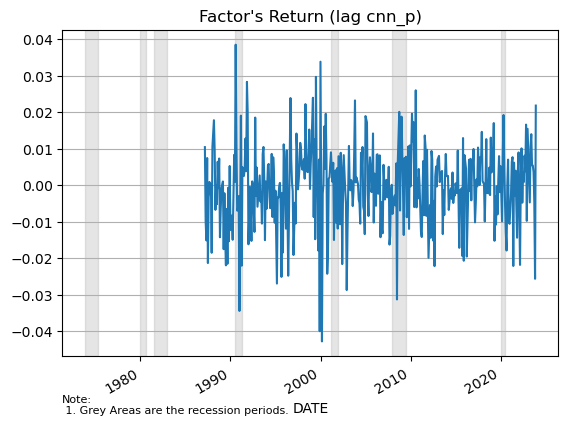

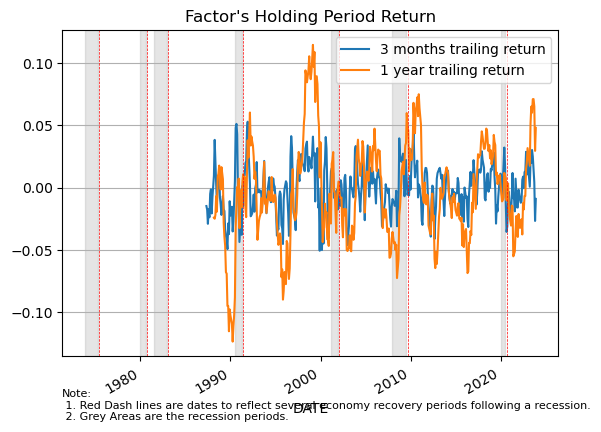

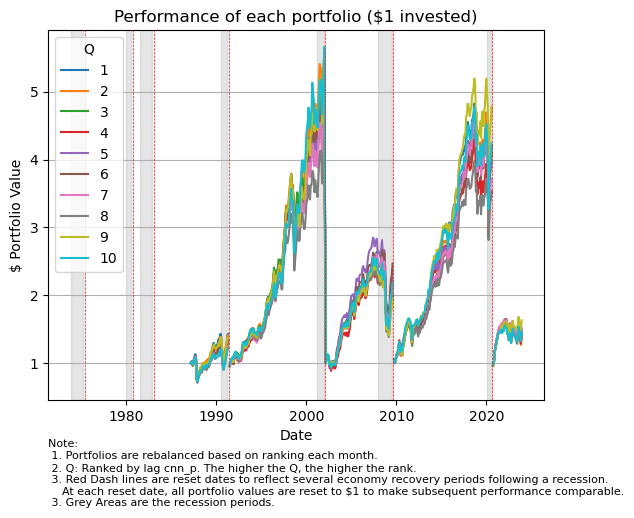

In [56]:
perf(df_cnn_TA,'lag cnn_p',check_robustness=False, portfolio_weight='equal', q = 10)

## Evaluation For LSTM TA Factor

10 classes classification does work well though

In [57]:
df_lstm_TA = df[(df['nn_rank']!=0) & (~df['nn_rank'].isna())].copy()

In [58]:
df_lstm_TA['nn_rank'].describe()

count    437456.000000
mean         -4.979900
std           2.840286
min         -10.000426
25%          -7.000016
50%          -4.999909
75%          -2.000068
max           0.000215
Name: nn_rank, dtype: float64

In [59]:
print('Whole dataset size: ',df.shape)
print('Value_factor dataset size: ',df_lstm_TA.shape)

Whole dataset size:  (1527557, 115)
Value_factor dataset size:  (437456, 115)


---------- Performance of Each Quantiles Portfolios----------
   count      mean       std       min       25%       50%       75%       max
Q                                                                             
1  264.0  0.006536  0.057302 -0.279975 -0.025922  0.010082  0.037656  0.212854
2  264.0  0.008966  0.052223 -0.189107 -0.021591  0.010868  0.037521  0.203003
3  264.0  0.014364  0.053066 -0.199101 -0.015315  0.019096  0.047977  0.226030
4  264.0  0.018170  0.053475 -0.174973 -0.008694  0.022609  0.051638  0.170751
5  264.0  0.014587  0.056361 -0.210912 -0.014312  0.018885  0.050653  0.152460
---------- Performance of Factor Portfolio----------
count     264.000000
mean        0.008051
std         0.053370
min        -0.214880
25%        -0.013815
50%         0.005424
75%         0.045005
max         0.116618
tstat       2.451034
sharpe      0.522562
Name: RET, dtype: float64


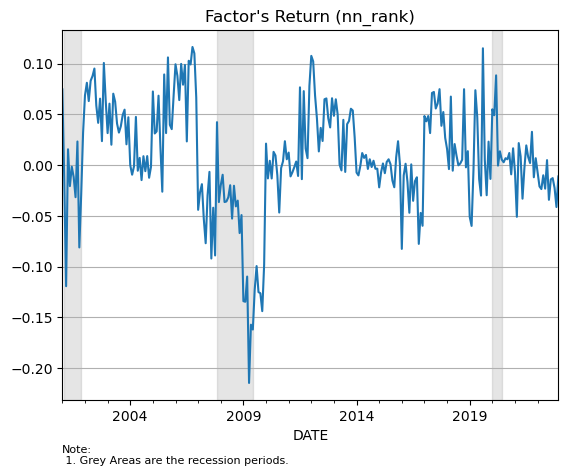

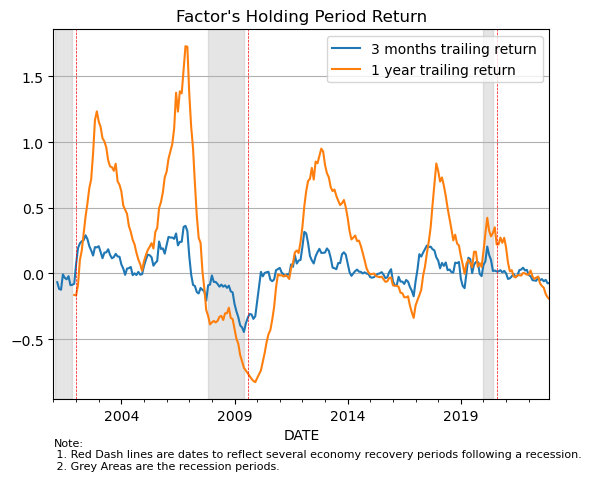

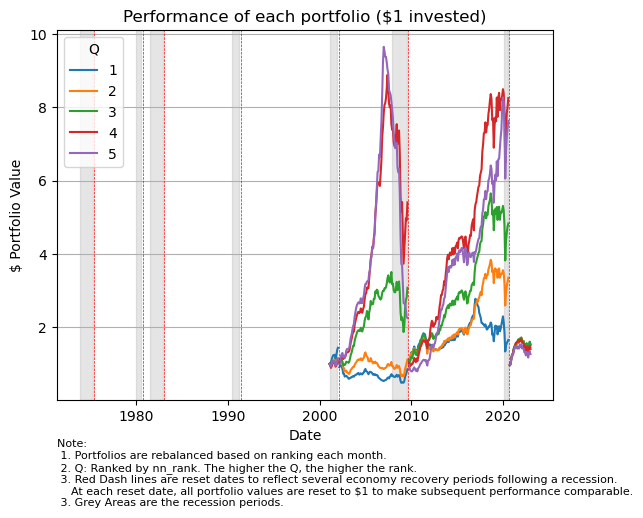

In [61]:
perf(df_lstm_TA,'nn_rank',check_robustness=False, portfolio_weight='equal', q = 5)

## Evaluation For Value Factor

In [62]:
# exclude outliers, (a choices made by researchers)
# Exclude stock that have too high P/E ratio or too low P/E ratio
# I will exclude stocks that have P/E ratios below 5 to avoid value trap

df_value_factor = df.loc[(df['Value_Factor_lagE/P(v1)']>0) & (df['Value_Factor_lagE/P(v2)']>0) & (df['Value_Factor_lagE/P(v1)']<.2) & (df['Value_Factor_lagE/P(v2)']<.2)].copy() 
# Eliminate Sample with missing concerned value
df_value_factor = df_value_factor.dropna(subset=['RET','Value_Factor_lagE/P(v1)','Value_Factor_lagE/P(v2)'])

In [63]:
df_value_factor['Value_Factor_lagE/P(v1)'].describe()

count    1.526179e+06
mean     6.912571e-02
std      4.265379e-02
min      9.723616e-06
25%      3.810411e-02
50%      6.193984e-02
75%      9.280224e-02
max      1.999876e-01
Name: Value_Factor_lagE/P(v1), dtype: float64

In [64]:
df_value_factor['Value_Factor_lagE/P(v2)'].describe()

count    1.526179e+06
mean     6.563543e-02
std      4.229017e-02
min      2.541618e-06
25%      3.428169e-02
50%      5.799791e-02
75%      8.919612e-02
max      2.000000e-01
Name: Value_Factor_lagE/P(v2), dtype: float64

In [65]:
print('Whole dataset size: ',df.shape)
print('Value_factor dataset size: ',df_value_factor.shape)

Whole dataset size:  (1527557, 115)
Value_factor dataset size:  (1526179, 115)


### Value: Version 1

---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   641.0  0.009388  0.069106 -0.319235 -0.030534  0.010548  0.047153   
2   641.0  0.010723  0.061891 -0.299325 -0.026872  0.012005  0.047929   
3   641.0  0.011110  0.058891 -0.309503 -0.024799  0.013679  0.046740   
4   641.0  0.011778  0.055940 -0.292235 -0.020684  0.015047  0.045310   
5   641.0  0.011752  0.054002 -0.282496 -0.018688  0.013339  0.042558   
6   641.0  0.012413  0.052083 -0.279019 -0.016209  0.014987  0.042095   
7   641.0  0.012813  0.050996 -0.279590 -0.014446  0.015149  0.042679   
8   641.0  0.013026  0.050166 -0.257720 -0.014706  0.015516  0.039619   
9   641.0  0.013531  0.049760 -0.251547 -0.014087  0.016927  0.042381   
10  641.0  0.013836  0.053019 -0.308485 -0.015797  0.017342  0.046516   

         max  
Q             
1   0.341514  
2   0.275472  
3

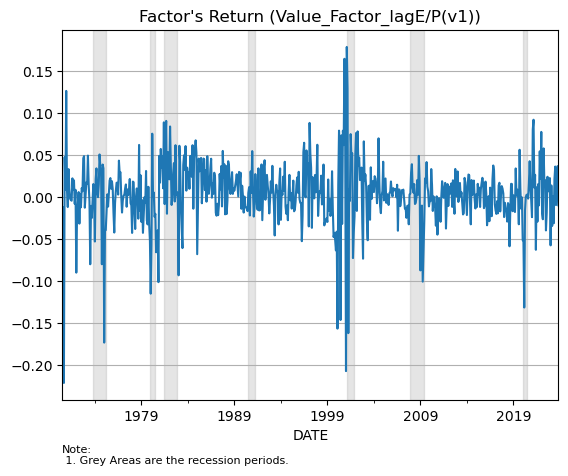

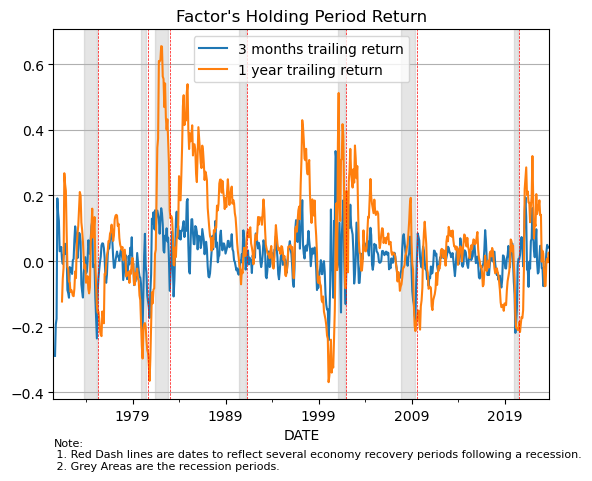

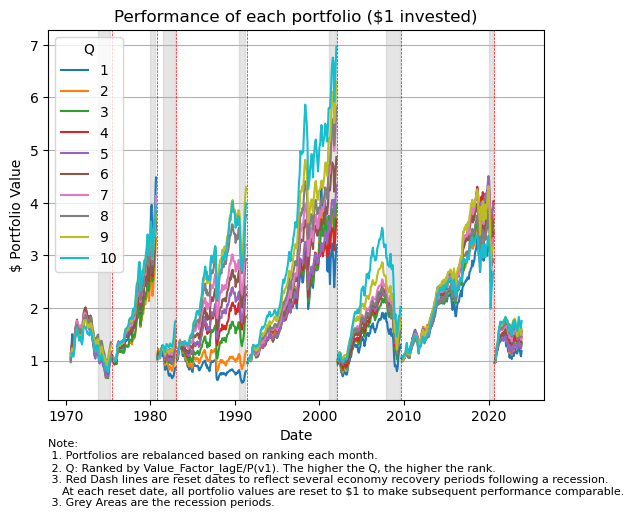

Signal_Robustness_Analyzing......


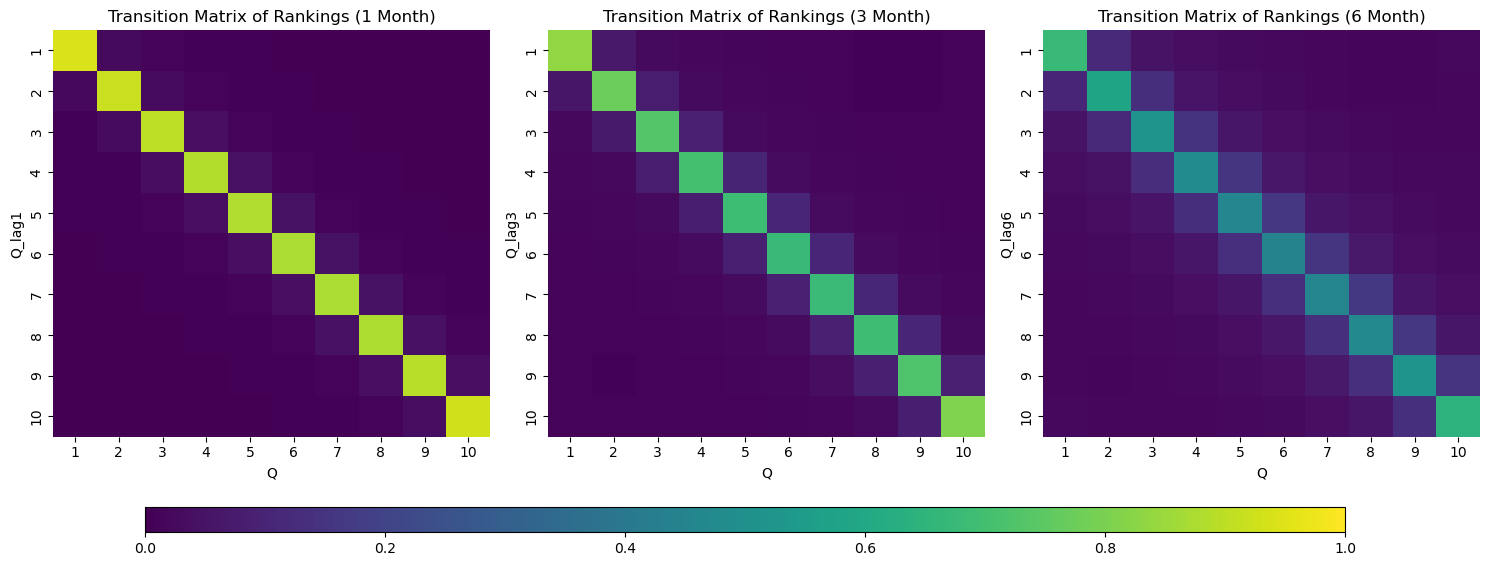

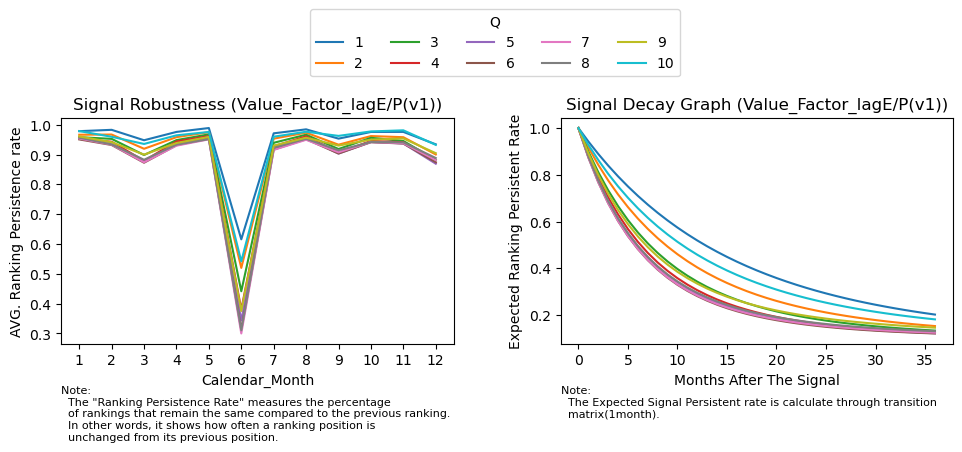

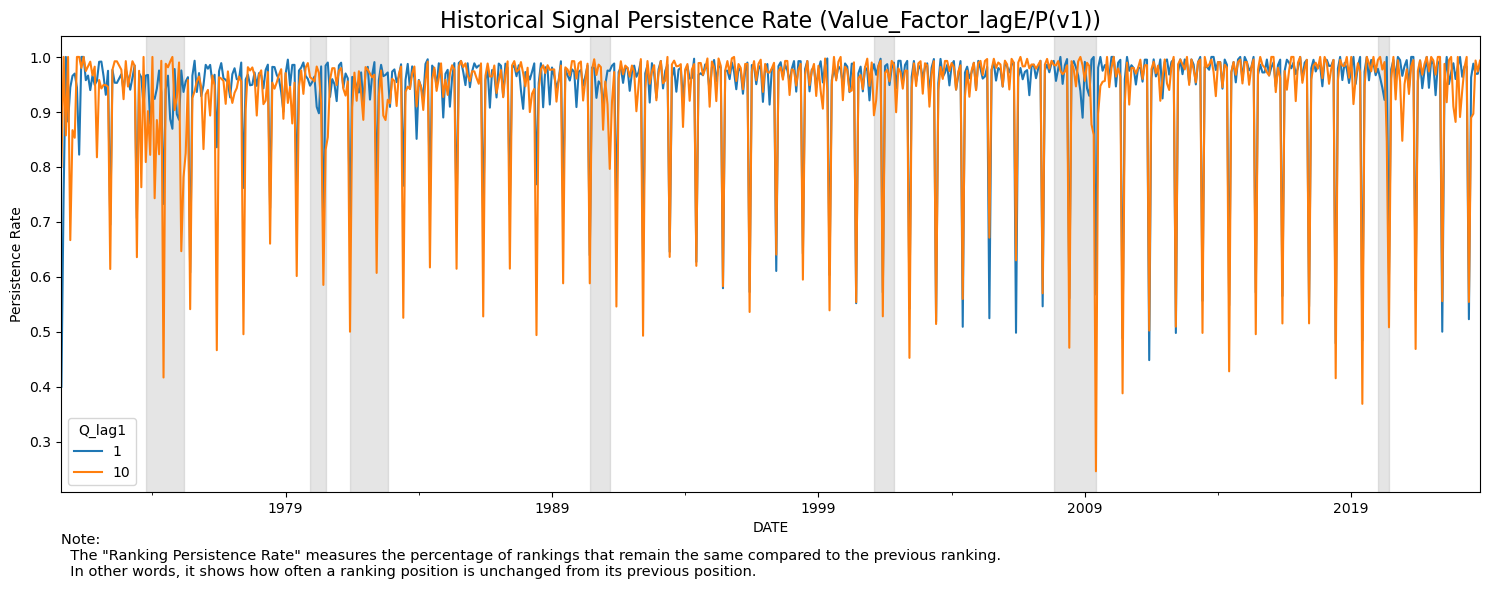

In [66]:
perf(df_value_factor,'Value_Factor_lagE/P(v1)',check_robustness=True, portfolio_weight='equal', q = 10)

### Value: Version 2

---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   641.0  0.009628  0.065324 -0.326358 -0.026678  0.012519  0.047520   
2   641.0  0.011138  0.059336 -0.294459 -0.027041  0.015546  0.047951   
3   641.0  0.010545  0.056518 -0.312933 -0.024073  0.013647  0.045271   
4   641.0  0.011062  0.054013 -0.298760 -0.020374  0.014300  0.043090   
5   641.0  0.010843  0.052643 -0.289857 -0.020119  0.013183  0.041857   
6   641.0  0.011692  0.052248 -0.281991 -0.016399  0.015255  0.040296   
7   641.0  0.012692  0.052287 -0.276388 -0.015425  0.015201  0.042045   
8   641.0  0.013513  0.051661 -0.253295 -0.012951  0.015739  0.042351   
9   641.0  0.014285  0.053998 -0.268956 -0.015579  0.015323  0.041385   
10  641.0  0.015023  0.060734 -0.314120 -0.018484  0.014701  0.046514   

         max  
Q             
1   0.295572  
2   0.206180  
3

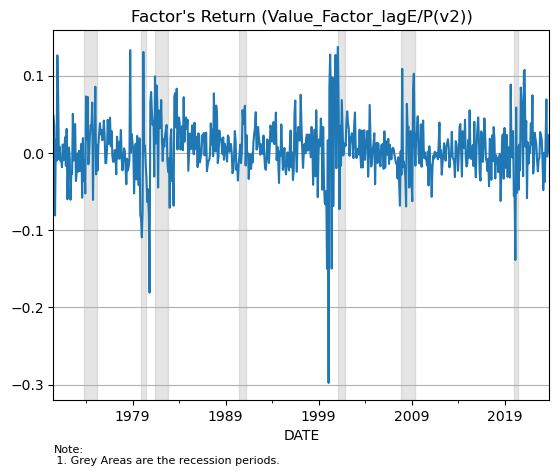

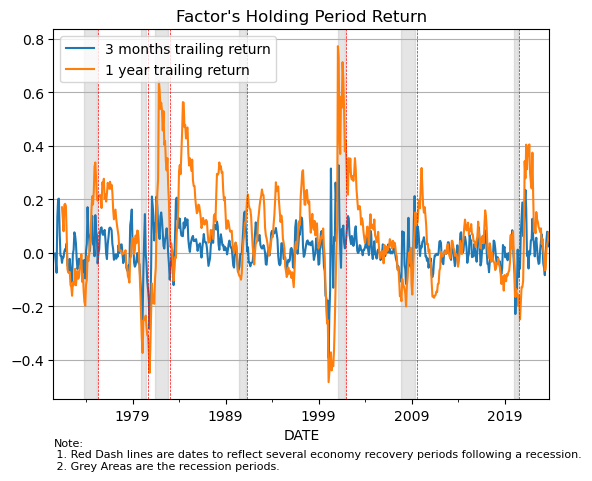

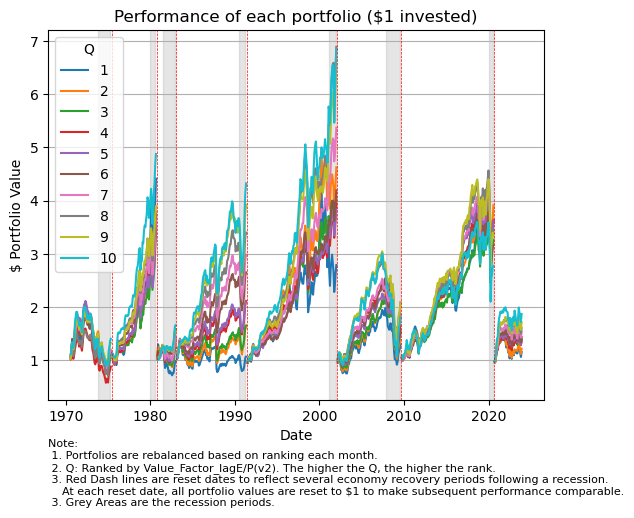

Signal_Robustness_Analyzing......


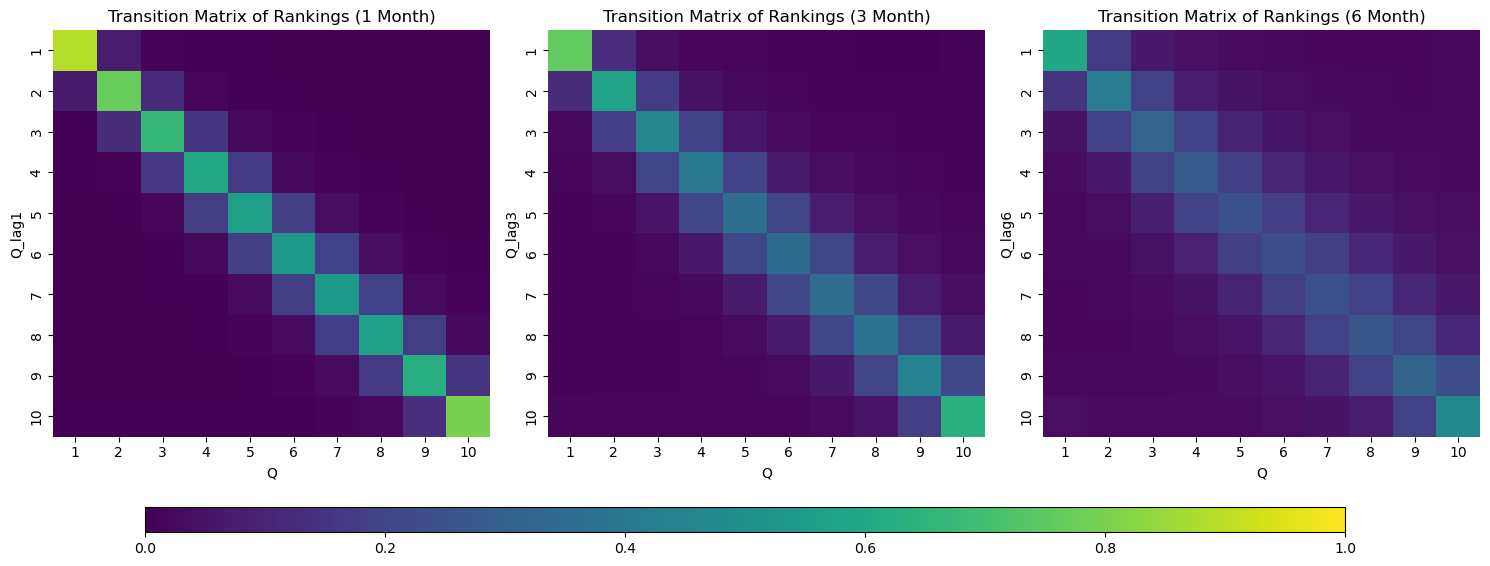

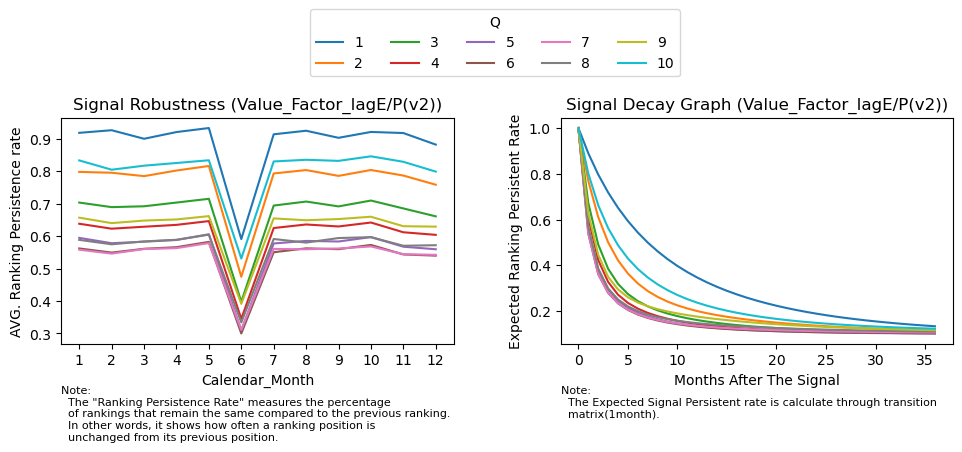

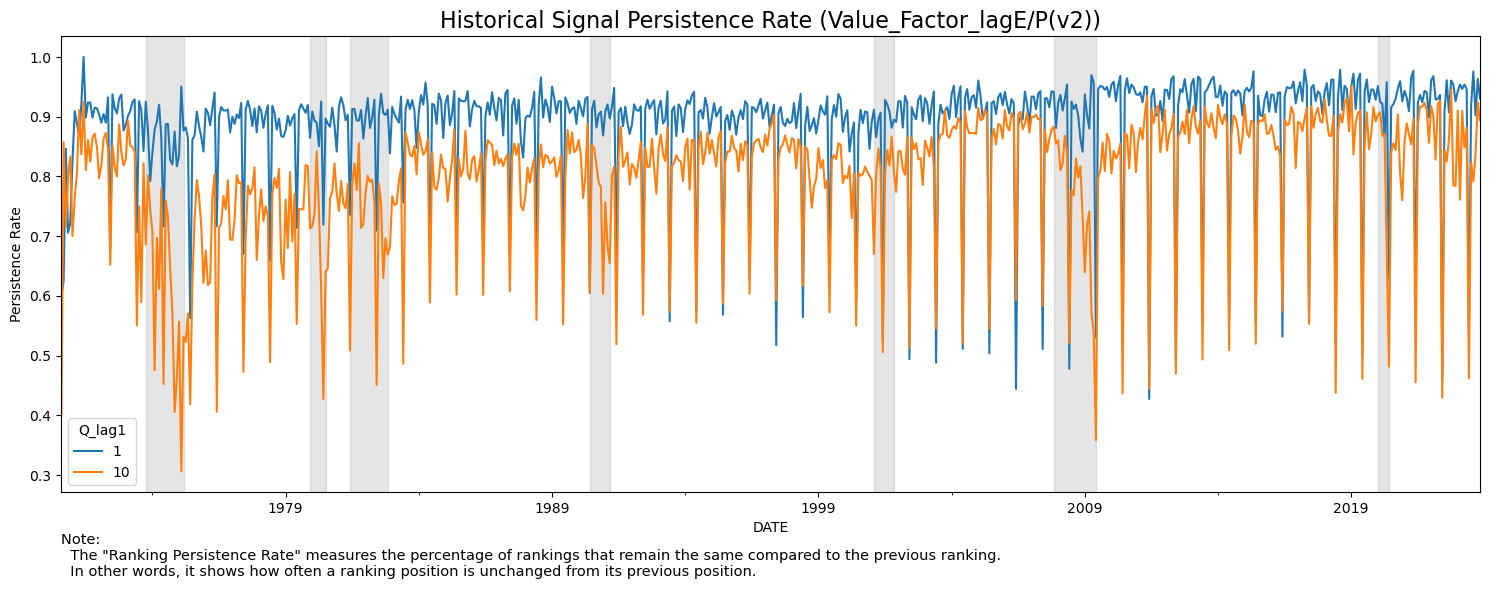

In [67]:
perf(df_value_factor,'Value_Factor_lagE/P(v2)', check_robustness=True, portfolio_weight='equal', q = 10)

## Valuation bias converger strategy

In [68]:
df_valuation_converger = df_value_factor.dropna(subset='valuation_z_score_first_difference')

In [69]:
df_valuation_converger['valuation_z_score_first_difference'].describe()

count    1.082416e+06
mean     1.250786e-02
std      2.548476e+00
min     -8.311361e+01
25%     -4.904700e-01
50%     -1.668879e-02
75%      4.414696e-01
max      1.242751e+02
Name: valuation_z_score_first_difference, dtype: float64

In [70]:
print('Whole dataset size: ',df.shape)
print('valuation_converger dataset size: ',df_valuation_converger.shape)

Whole dataset size:  (1527557, 115)
valuation_converger dataset size:  (1082416, 116)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   599.0  0.005478  0.049818 -0.284444 -0.021544  0.007224  0.037311   
2   599.0  0.008761  0.049939 -0.281879 -0.017253  0.012458  0.038450   
3   599.0  0.010915  0.051770 -0.281797 -0.017125  0.013969  0.041753   
4   599.0  0.012211  0.052231 -0.268976 -0.015450  0.016597  0.042729   
5   599.0  0.013264  0.054385 -0.255234 -0.017984  0.016912  0.043345   
6   599.0  0.014699  0.054508 -0.259767 -0.014892  0.016680  0.046064   
7   599.0  0.015357  0.055924 -0.252568 -0.015770  0.018878  0.046467   
8   599.0  0.016897  0.054830 -0.260193 -0.013541  0.018774  0.050935   
9   599.0  0.017498  0.057984 -0.267636 -0.014270  0.018434  0.047868   
10  599.0  0.018631  0.057990 -0.261268 -0.015466  0.019114  0.050903   

         max  
Q             
1   0.225438  
2   0.209684  
3

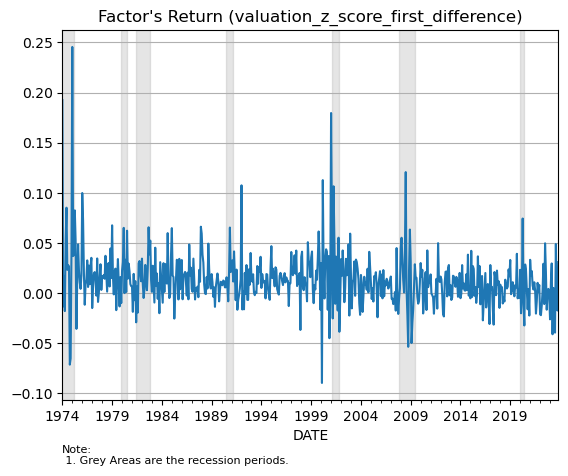

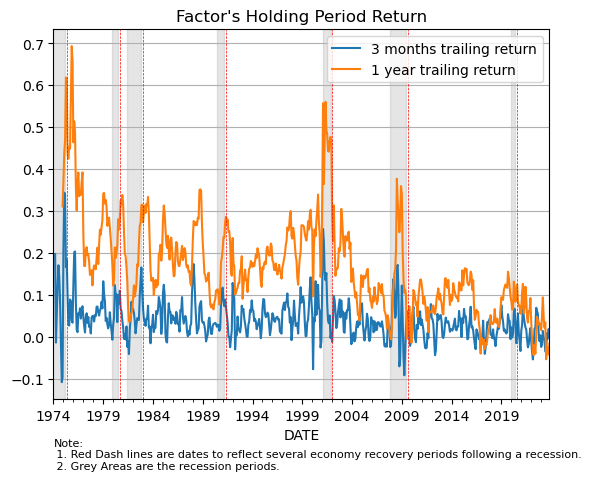

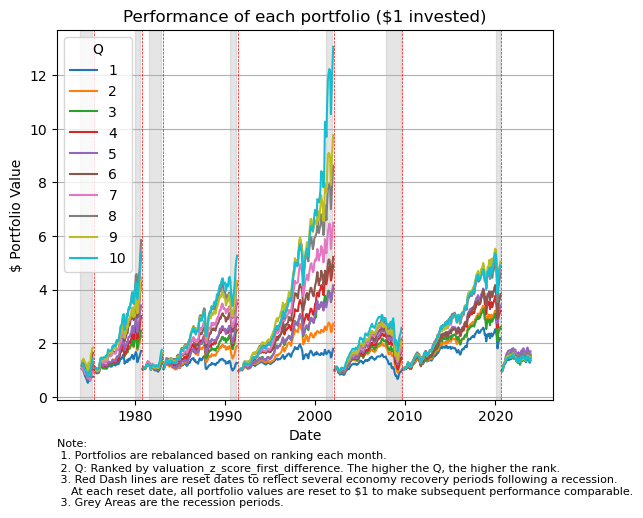

Signal_Robustness_Analyzing......


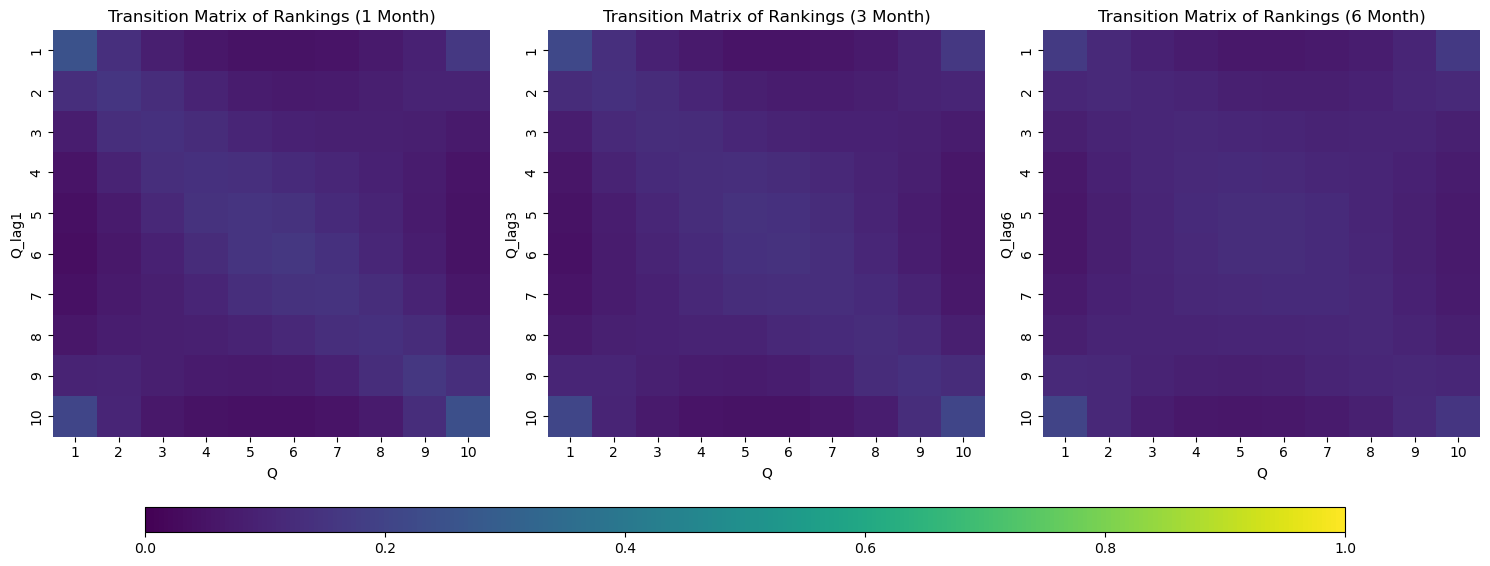

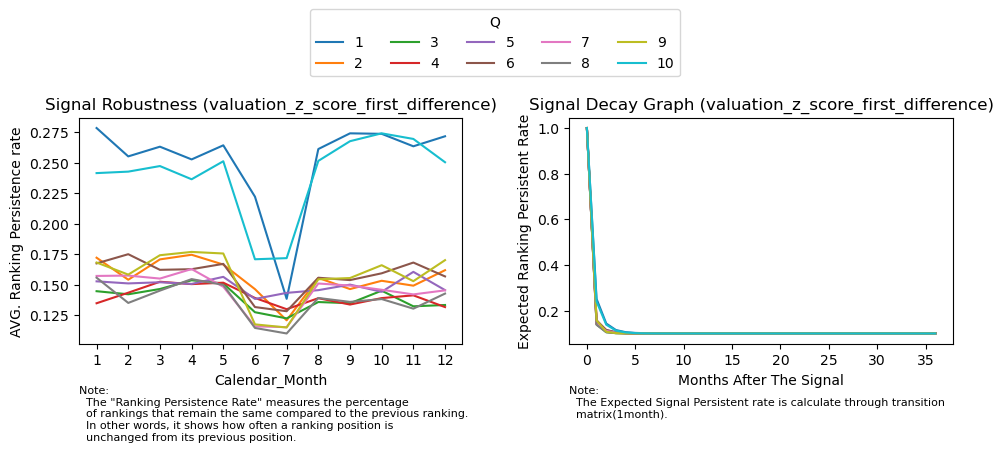

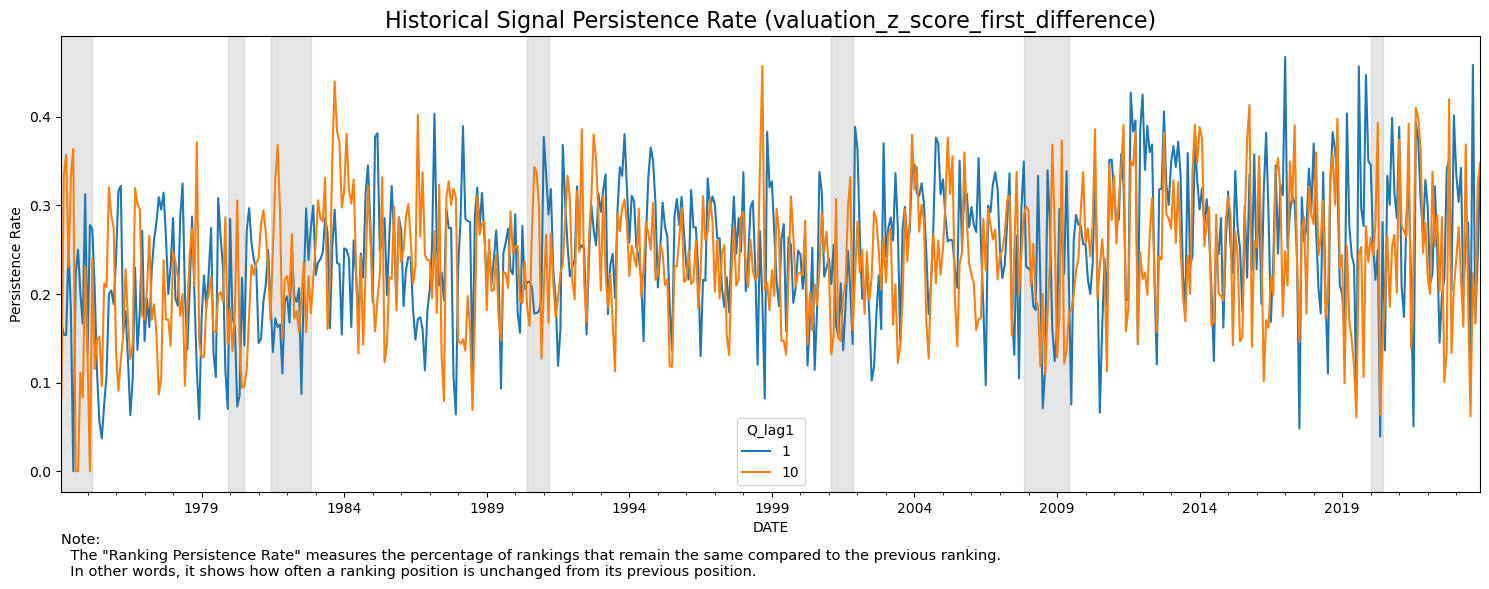

In [71]:
perf(df_valuation_converger,'valuation_z_score_first_difference', check_robustness=True, portfolio_weight='equal', q= 10)

In [72]:
# trying different windows
"""
results_parameters_pairs = []
df_temp = pd.read_feather('crsp_compustat_combined.feather')
df_temp = df_temp.rename({'ib':'IB'}, axis = 1)
# we only want to study sample after 1970
df_temp = df_temp[df_temp.index.get_level_values('DATE') > '1970-01-01']
df_temp = df_temp[df_temp.index.get_level_values('DATE') < '2023-12-01'] # some annual data hasn't came out
# Calculate Money Trade(Capital Flow) in that sector
# Using 6 months lag because we have to be conservative to avoid look-ahead bias
# multiply the E/P ratio by 1000 for it to make sense and Comparable. 
# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. 
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df_temp['lag IB']  = df_temp['IB'].groupby('PERMNO').shift(6).fillna(method='pad', limit=15)

# Value Factor: This version will not have monthly-changing variable because we did not consider the most recent usable market value
df_temp['Value_Factor_lagE/P(v1)'] = df_temp['IB'].groupby('PERMNO').shift(6) / df_temp['MV'].groupby('PERMNO').shift(6) * 1000
# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should be unusual situations.
df_temp['Value_Factor_lagE/P(v1)'] = df_temp['Value_Factor_lagE/P(v1)'].groupby('PERMNO').fillna(method='pad', limit=15)
# multiply the E/P ratio by 1000 for it to make sense and Comparable. 
# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. 
df_temp['Value_Factor_lagE/P(v2)'] = df_temp['lag IB'] / df_temp['MV'].groupby('PERMNO').shift(1) * 1000


# exclude outliers, (a choices made by researchers)
# Exclude stock that have too high P/E ratio or too low P/E ratio
# I will exclude stocks that have P/E ratios below 5 to avoid value trap
df_temp = df_temp.loc[(df_temp['Value_Factor_lagE/P(v1)']>0) & (df_temp['Value_Factor_lagE/P(v2)']>0) & (df_temp['Value_Factor_lagE/P(v1)']<.2) & (df_temp['Value_Factor_lagE/P(v2)']<.2)].copy() 
# Eliminate Sample with missing concerned value
df_temp = df_temp.dropna(subset=['RET','Value_Factor_lagE/P(v1)','Value_Factor_lagE/P(v2)'])



for i in range(12,60):
    print(f'Running window size of {i}')
    df_factor_tester = df_temp.copy()
    
    # Calculating z-score for each stocks valuation
    window_valuation_statistics = i
    df_factor_tester['valuation_rolling_mean'] = (df_factor_tester['Value_Factor_lagE/P(v2)']).groupby('PERMNO').rolling(window_valuation_statistics).mean().reset_index(level=0, drop = True)
    df_factor_tester['valuation_rolling_std'] = df_factor_tester['valuation_rolling_mean'].groupby('PERMNO').rolling(window_valuation_statistics).std().reset_index(level=0, drop = True)
    df_factor_tester['valuation_z_score']  = (df_factor_tester['Value_Factor_lagE/P(v2)'] - df_factor_tester['valuation_rolling_mean'])/df_factor_tester['valuation_rolling_std']
    df_factor_tester['valuation_z_score_first_difference'] = df_factor_tester['valuation_z_score'].groupby('PERMNO').diff()
    
    # Eliminate Sample with missing concerned value
    df_factor_tester = df_factor_tester.dropna(subset=['RET', 'valuation_z_score_first_difference'])
    temp_stats = perf(df_factor_tester, 'valuation_z_score_first_difference', q = 10, check_robustness = False, portfolio_weight='equal', output_stats=True, print_performance=False)
    temp_stats.name = "Window(Month) = " + str(i)

    # Calculate alpha and beta for this strategy
    df_ports_return = get_portfolios_return(df_factor_tester, 'valuation_z_score_first_difference', q = 10,portfolio_weight='equal')
    df_ports_return  = pd.concat(((df_ports_return.loc[10] - df_ports_return.loc[1]),df_mkt), axis=1)
    df_ports_return = df_ports_return.dropna()

    # Creating the formula for the OLS regression
    formula = 'RET ~ Market_Excess_Return'
    # Fitting the OLS model
    model = smf.ols(formula=formula, data = df_ports_return).fit()
    # Displaying the model summary
       
    temp_stats['α'] = model.params['Intercept']
    temp_stats['p_value (α)'] = model.pvalues['Intercept']
    temp_stats['β_Market'] = model.params['Market_Excess_Return']
    temp_stats['p_value (β_Market)'] = model.pvalues['Market_Excess_Return']
    temp_stats['R-squared'] = model.rsquared
    # Only show value down to 4 digits to make improve the table's clarity"
    temp_stats = temp_stats.apply(lambda x: f"{x:.4f}")#temp_stats.round(4)
    
    results_parameters_pairs.append(temp_stats)
df_valuation_converger_parameter_testing = pd.DataFrame(results_parameters_pairs)
df_valuation_converger_parameter_testing.to_csv('Parameter_Testing/Valuation_Converger_Strategy.csv')
"""

'\nresults_parameters_pairs = []\ndf_temp = pd.read_feather(\'crsp_compustat_combined.feather\')\ndf_temp = df_temp.rename({\'ib\':\'IB\'}, axis = 1)\n# we only want to study sample after 1970\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') > \'1970-01-01\']\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') < \'2023-12-01\'] # some annual data hasn\'t came out\n# Calculate Money Trade(Capital Flow) in that sector\n# Using 6 months lag because we have to be conservative to avoid look-ahead bias\n# multiply the E/P ratio by 1000 for it to make sense and Comparable. \n# The reason is that CRSP and Compustat are in different units. In CRSP, the shares outstanding series used to create market values (MV) was in 1000s of shares. Thus, the MV column is too small by a factor of 1000. In Compustat, earnings (IB) are in millions of dollars. \n# Filling Missing Value! The limit=15 option says that we will not use a prior value if it is more than 15 months old, which should b

## Evaluation For Section Familiarity/FOMO

In [73]:
df_Familiarity = df.copy()
# Eliminate Sample with missing concerned value
df_Familiarity = df_Familiarity.dropna(subset=['RET', 'lag Sector Familiarity EW Factor'])
df_Familiarity['lag Sector Familiarity EW Factor'].describe()

count    1.478625e+06
mean     1.976126e-01
std      1.099374e+00
min     -2.994213e+00
25%     -6.549416e-01
50%      2.744412e-02
75%      9.591673e-01
max      3.175712e+00
Name: lag Sector Familiarity EW Factor, dtype: float64

In [74]:
print('Whole dataset size: ',df.shape)
print('Section Familiarity dataset size: ',df_Familiarity.shape)

Whole dataset size:  (1527557, 115)
Section Familiarity dataset size:  (1478625, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   635.0  0.009137  0.058767 -0.271175 -0.023189  0.010919  0.041692   
2   635.0  0.009604  0.057388 -0.295272 -0.021732  0.009946  0.042943   
3   635.0  0.009804  0.056509 -0.282916 -0.022691  0.013460  0.040151   
4   635.0  0.010938  0.056726 -0.274579 -0.020268  0.014051  0.042566   
5   635.0  0.011382  0.055539 -0.268318 -0.017989  0.013112  0.044826   
6   635.0  0.012453  0.055666 -0.285644 -0.018987  0.016094  0.044191   
7   635.0  0.011927  0.053367 -0.285642 -0.016278  0.014975  0.043624   
8   635.0  0.012953  0.053019 -0.268375 -0.016844  0.014332  0.044348   
9   635.0  0.014016  0.054292 -0.300519 -0.016286  0.015991  0.047022   
10  635.0  0.014749  0.053196 -0.283783 -0.014673  0.014350  0.046768   

         max  
Q             
1   0.261263  
2   0.299158  
3

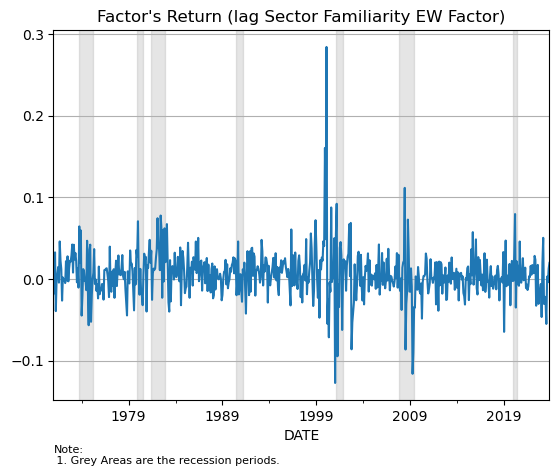

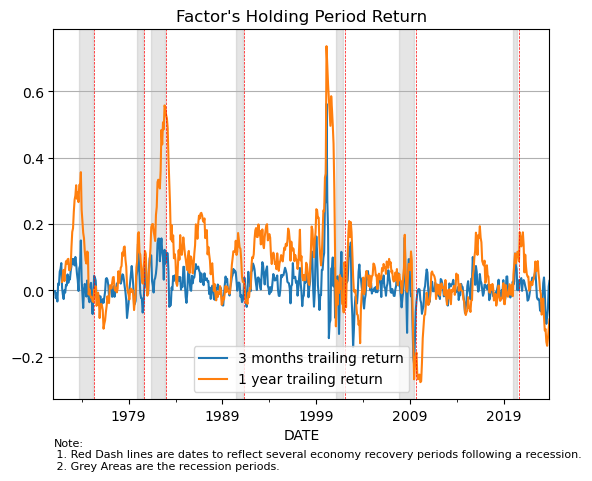

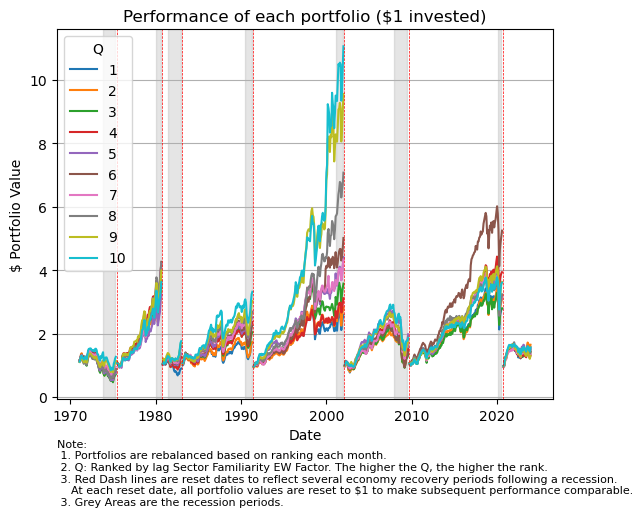

Signal_Robustness_Analyzing......


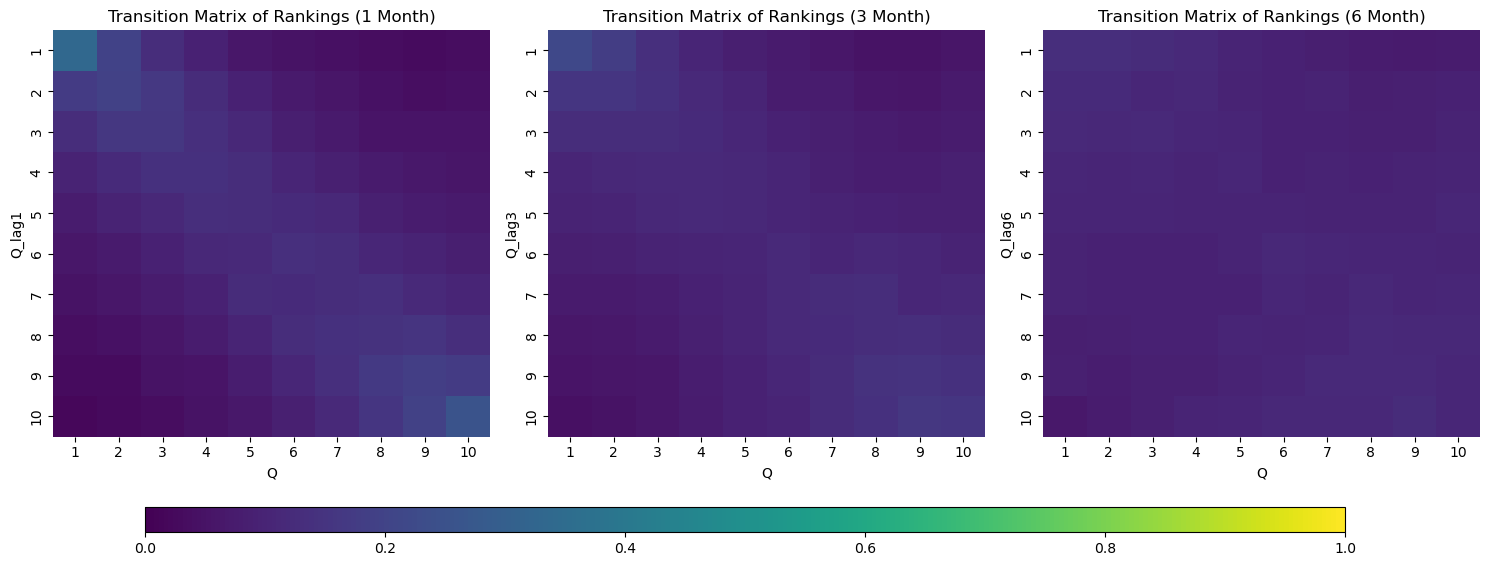

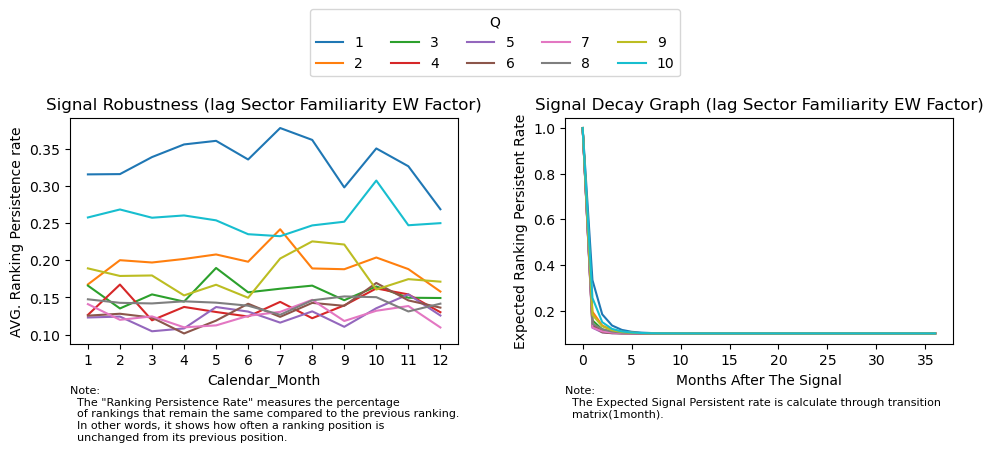

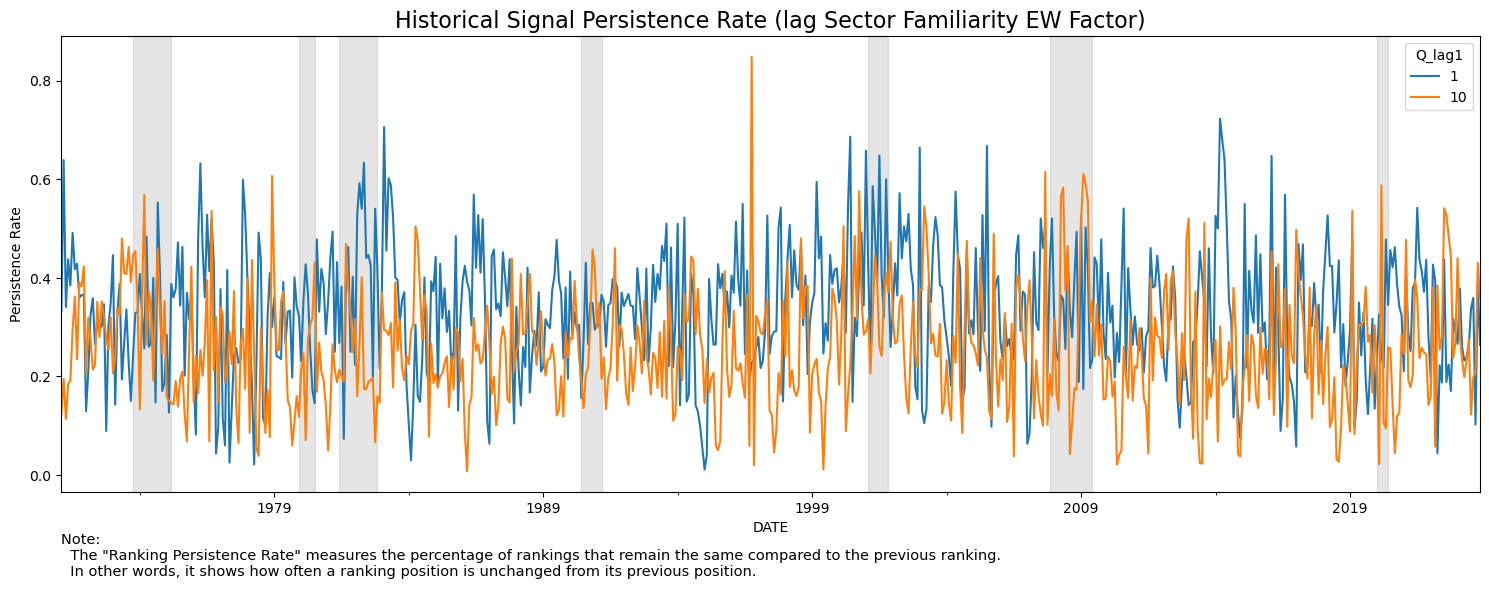

In [75]:
perf(df_Familiarity, 'lag Sector Familiarity EW Factor', q = 10, check_robustness = True, portfolio_weight='equal')

In [77]:
df_ports_return = get_portfolios_return(df_Familiarity, 'lag Sector Familiarity EW Factor', q = 10,portfolio_weight='equal')
df_ports_return  = pd.concat(((df_ports_return.loc[10] - df_ports_return.loc[1]),df_mkt), axis=1)
df_ports_return = df_ports_return.dropna()

In [78]:
# Creating the formula for the OLS regression
formula = 'RET ~ Market_Excess_Return'
# Fitting the OLS model
model = smf.ols(formula=formula, data = df_ports_return).fit()
# Displaying the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     23.51
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.57e-06
Time:                        08:46:22   Log-Likelihood:                 1361.8
No. Observations:                 635   AIC:                            -2720.
Df Residuals:                     633   BIC:                            -2711.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0063 

In [79]:
# try different lookback periods
"""
results_parameters_pairs = []
df_temp = pd.read_feather('crsp_compustat_combined.feather')
# we only want to study sample after 1970
df_temp = df_temp[df_temp.index.get_level_values('DATE') > '1970-01-01']
df_temp = df_temp[df_temp.index.get_level_values('DATE') < '2023-12-01'] # some annual data hasn't came out
# Calculate Money Trade(Capital Flow) in that sector
df_temp['MONEY_TRADE'] = (df_temp['VOL']*df_temp['PRC'])


for i in range(12,60):#60
    
    print(f'Running window size of {i}')
    df_parameter_testing = df_temp.copy()
    Industry_ew_money_trade = df_parameter_testing.groupby(['DATE','SICCD'])['MONEY_TRADE'].mean()
    # Calculating z-score for each sector's MONEY TRADE(Capital Flow)
    window_volumn_statistics = i
    rolling_mean = Industry_ew_money_trade.groupby('SICCD').rolling(window_volumn_statistics).mean().droplevel(0)
    rolling_std = Industry_ew_money_trade.groupby('SICCD').rolling(window_volumn_statistics).std().droplevel(0)
    zscore_ew_industry_money_trade= (Industry_ew_money_trade - rolling_mean)/rolling_std
    df_parameter_testing = df_parameter_testing.reset_index().set_index(['DATE','SICCD'])
    df_parameter_testing['Sector Familiarity EW Factor'] = zscore_ew_industry_money_trade
    df_parameter_testing = df_parameter_testing.reset_index().set_index(['PERMNO','DATE'])
    df_parameter_testing['lag Sector Familiarity EW Factor'] = df_parameter_testing['Sector Familiarity EW Factor'].groupby('PERMNO').shift(1)
    # add some random number to make the factor having less common value, to make qcut runnable.
    df_parameter_testing['lag Sector Familiarity EW Factor']= df_parameter_testing['lag Sector Familiarity EW Factor'] + np.random.normal(loc=0, scale=0.0001, size=(len(df_parameter_testing['lag Sector Familiarity EW Factor'])))

    # Eliminate Sample with missing concerned value
    df_parameter_testing = df_parameter_testing.dropna(subset=['RET', 'lag Sector Familiarity EW Factor'])
    temp_stats = perf(df_parameter_testing, 'lag Sector Familiarity EW Factor', q = 10, check_robustness = False, portfolio_weight='equal', output_stats=True, print_performance=False)
    temp_stats.name = "Window(Month) = " + str(i)


    # Calculate alpha and beta for this strategy
    df_ports_return = get_portfolios_return(df_parameter_testing, 'lag Sector Familiarity EW Factor', q = 10,portfolio_weight='equal')
    df_ports_return  = pd.concat(((df_ports_return.loc[10] - df_ports_return.loc[1]),df_mkt), axis=1)
    df_ports_return = df_ports_return.dropna()

    # Creating the formula for the OLS regression
    formula = 'RET ~ Market_Excess_Return'
    # Fitting the OLS model
    model = smf.ols(formula=formula, data = df_ports_return).fit()
    # Displaying the model summary
       
    temp_stats['α'] = model.params['Intercept']
    temp_stats['p_value (α)'] = model.pvalues['Intercept']
    temp_stats['β_Market'] = model.params['Market_Excess_Return']
    temp_stats['p_value (β_Market)'] = model.pvalues['Market_Excess_Return']
    temp_stats['R-squared'] = model.rsquared
    # Only show value down to 4 digits to make improve the table's clarity"
    temp_stats = temp_stats.apply(lambda x: f"{x:.4f}")#temp_stats.round(4)

    results_parameters_pairs.append(temp_stats)
df_sector_parameter_testing = pd.DataFrame(results_parameters_pairs)
df_sector_parameter_testing.to_csv('Parameter_Testing/Sector(Familiarity,FOMO,Herding).csv')
"""

'\nresults_parameters_pairs = []\ndf_temp = pd.read_feather(\'crsp_compustat_combined.feather\')\n# we only want to study sample after 1970\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') > \'1970-01-01\']\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') < \'2023-12-01\'] # some annual data hasn\'t came out\n# Calculate Money Trade(Capital Flow) in that sector\ndf_temp[\'MONEY_TRADE\'] = (df_temp[\'VOL\']*df_temp[\'PRC\'])\n\n\nfor i in range(12,60):#60\n    \n    print(f\'Running window size of {i}\')\n    df_parameter_testing = df_temp.copy()\n    Industry_ew_money_trade = df_parameter_testing.groupby([\'DATE\',\'SICCD\'])[\'MONEY_TRADE\'].mean()\n    # Calculating z-score for each sector\'s MONEY TRADE(Capital Flow)\n    window_volumn_statistics = i\n    rolling_mean = Industry_ew_money_trade.groupby(\'SICCD\').rolling(window_volumn_statistics).mean().droplevel(0)\n    rolling_std = Industry_ew_money_trade.groupby(\'SICCD\').rolling(window_volumn_statistics).s

## Evaluation For %Sale - %Inventory

In [80]:
df_diff_change_sale_inventory = df.copy()

In [81]:
# Eliminate Sample with missing concerned value
df_diff_change_sale_inventory = df_diff_change_sale_inventory.dropna(subset=['RET', 'lag (%sale - %inventory)'])

In [82]:
# Eliminate meaningless value
df_diff_change_sale_inventory = df_diff_change_sale_inventory[df_diff_change_sale_inventory['lag (%sale - %inventory)']!=0]

In [83]:
df_diff_change_sale_inventory['lag (%sale - %inventory)'].describe()

count    1.046726e+06
mean     8.448819e-03
std      2.719626e-01
min     -2.000000e+00
25%     -6.041447e-02
50%      6.092806e-03
75%      7.735028e-02
max      2.000000e+00
Name: lag (%sale - %inventory), dtype: float64

In [84]:
print('Whole dataset size: ',df.shape)
print('%Sale - %Inventory dataset size: ',df_diff_change_sale_inventory.shape)

Whole dataset size:  (1527557, 115)
%Sale - %Inventory dataset size:  (1046726, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   623.0  0.011023  0.056018 -0.299019 -0.020071  0.013273  0.041815   
2   623.0  0.011779  0.057812 -0.289471 -0.021463  0.013381  0.043683   
3   623.0  0.011886  0.056488 -0.266816 -0.017140  0.015607  0.045379   
4   623.0  0.012185  0.054996 -0.273763 -0.019024  0.014825  0.044310   
5   623.0  0.011948  0.054726 -0.266475 -0.018284  0.014482  0.044440   
6   623.0  0.012285  0.053932 -0.278472 -0.016406  0.012993  0.045667   
7   623.0  0.012574  0.053121 -0.270382 -0.016901  0.015142  0.044658   
8   623.0  0.012221  0.055898 -0.276977 -0.020044  0.014787  0.045185   
9   623.0  0.011951  0.056200 -0.270418 -0.020643  0.015205  0.045115   
10  623.0  0.011987  0.055270 -0.304704 -0.017282  0.013121  0.044101   

         max  
Q             
1   0.330650  
2   0.315094  
3

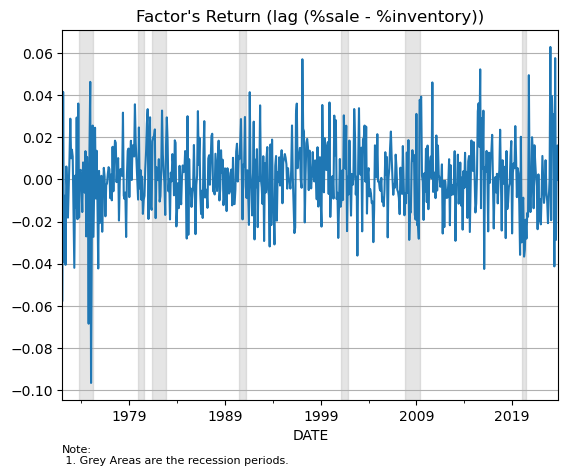

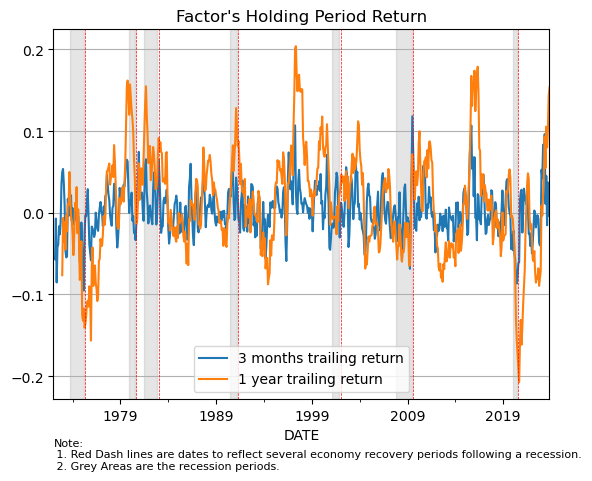

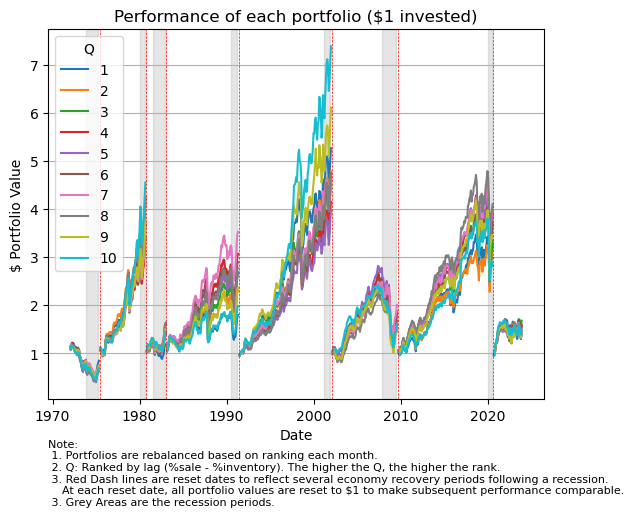

In [85]:
perf(df_diff_change_sale_inventory, 'lag (%sale - %inventory)', q = 10, check_robustness = False, portfolio_weight='equal')

## Evaluation For Herding Bias
we use the quantification same as Section Familiarity/FOMO, but for individual stock.

In [92]:
df_herding = df.copy()

In [93]:
# Eliminate Sample with missing concerned value
df_herding = df_herding.dropna(subset=['RET', 'lag1 Herding_naive_volumn'])

In [94]:
df_herding['lag1 Herding_naive_volumn'].describe()

count    1.365535e+06
mean     8.933360e-02
std      1.051286e+00
min     -2.836141e+00
25%     -6.809612e-01
50%     -1.614679e-01
75%      6.916418e-01
max      3.175416e+00
Name: lag1 Herding_naive_volumn, dtype: float64

In [95]:
print('Whole dataset size: ',df.shape)
print('Naive Herding dataset size: ',df_herding.shape)

Whole dataset size:  (1527557, 115)
Naive Herding dataset size:  (1365535, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   635.0  0.007030  0.054815 -0.283237 -0.024472  0.009407  0.039408   
2   635.0  0.009273  0.054976 -0.290204 -0.022895  0.011844  0.041739   
3   635.0  0.008833  0.053480 -0.285810 -0.020317  0.012869  0.039425   
4   635.0  0.010693  0.053893 -0.288037 -0.019337  0.012480  0.039770   
5   635.0  0.011411  0.054408 -0.261288 -0.020697  0.014260  0.041040   
6   635.0  0.012816  0.054381 -0.279437 -0.017486  0.013937  0.042432   
7   635.0  0.013306  0.055473 -0.265992 -0.019154  0.013916  0.045515   
8   635.0  0.014366  0.055149 -0.268422 -0.017464  0.014494  0.047391   
9   635.0  0.014350  0.054850 -0.290464 -0.018280  0.016380  0.047226   
10  635.0  0.016703  0.057413 -0.258683 -0.015940  0.018952  0.048734   

         max  
Q             
1   0.231361  
2   0.190062  
3

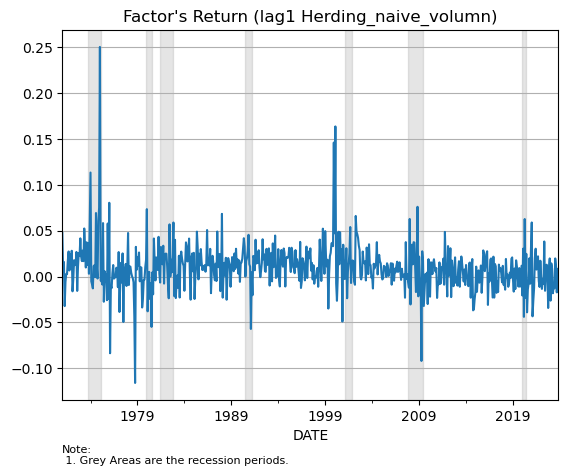

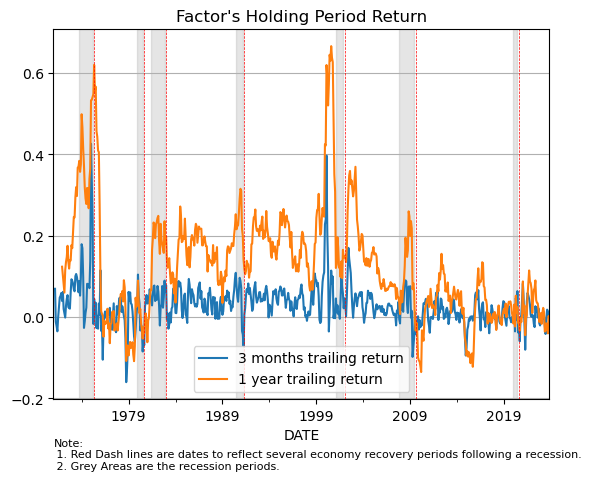

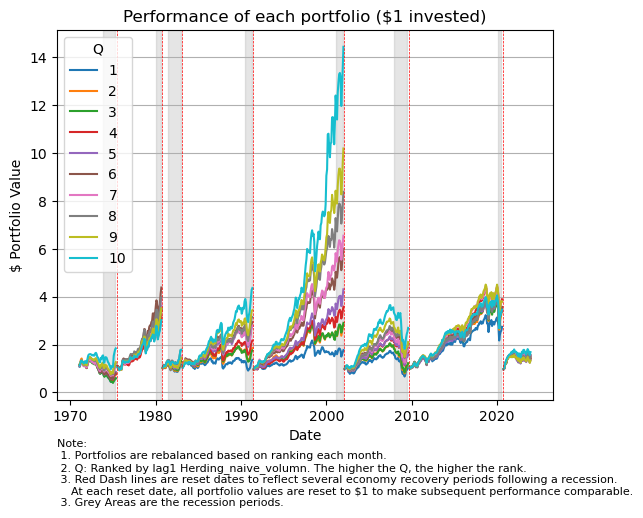

In [96]:
perf(df_herding, 'lag1 Herding_naive_volumn', q = 10, check_robustness = False, portfolio_weight='equal')

## Evaluation For Prospect Theory Factor: Gain_Loss_S_factor
We found out this is equivalent to some kind of short term reversal

In [136]:
#First we have to only apply this factor in small stocks
df_Gain_Loss_S_factor = df.copy()
df_Gain_Loss_S_factor['Q_from_MV'] = df_Gain_Loss_S_factor['MV'].groupby('DATE').apply(quantiles, q=10).reset_index(level=0, drop = True)

In [137]:
df_Gain_Loss_S_factor = df_Gain_Loss_S_factor[~df_Gain_Loss_S_factor['Q_from_MV'].isna()]

In [138]:
# I remove big cap stock and tiny stock, because inefficiency happens more in medium and small stocks while tiny stocks is too illiquid. 
df_Gain_Loss_S_factor =  df_Gain_Loss_S_factor.loc[
    (df_Gain_Loss_S_factor['Q_from_MV']<=8)&(df_Gain_Loss_S_factor['Q_from_MV']>=2)].copy()

# Eliminate Sample with missing concerned value
df_Gain_Loss_S_factor = df_Gain_Loss_S_factor.dropna(subset=['RET', 'lag1 Gain_Loss_S_factor'])

In [139]:
df_Gain_Loss_S_factor['lag1 Gain_Loss_S_factor'].describe()

count    990924.000000
mean         -0.025009
std           0.253106
min         -58.023093
25%          -0.128825
50%          -0.002639
75%           0.111913
max           0.928549
Name: lag1 Gain_Loss_S_factor, dtype: float64

In [140]:
print('Whole dataset size: ',df.shape)
print('Gain_Loss_S_factor dataset size: ',df_Gain_Loss_S_factor.shape)

Whole dataset size:  (1527557, 115)
Gain_Loss_S_factor dataset size:  (990924, 116)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   641.0  0.007515  0.055033 -0.279487 -0.024216  0.010074  0.038707   
2   641.0  0.008298  0.057331 -0.307863 -0.025914  0.011205  0.042570   
3   641.0  0.009403  0.056364 -0.314339 -0.024011  0.012249  0.041948   
4   641.0  0.010779  0.057419 -0.290667 -0.022682  0.013867  0.043329   
5   641.0  0.011092  0.057507 -0.290387 -0.021631  0.014030  0.044008   
6   641.0  0.013770  0.058209 -0.296257 -0.020301  0.015502  0.046814   
7   641.0  0.014758  0.059242 -0.266739 -0.019248  0.016731  0.048425   
8   641.0  0.015208  0.059750 -0.297541 -0.018334  0.017450  0.050085   
9   641.0  0.017012  0.061661 -0.295751 -0.015932  0.018712  0.051713   
10  641.0  0.021368  0.068582 -0.284409 -0.018153  0.018337  0.058827   

         max  
Q             
1   0.235177  
2   0.237999  
3

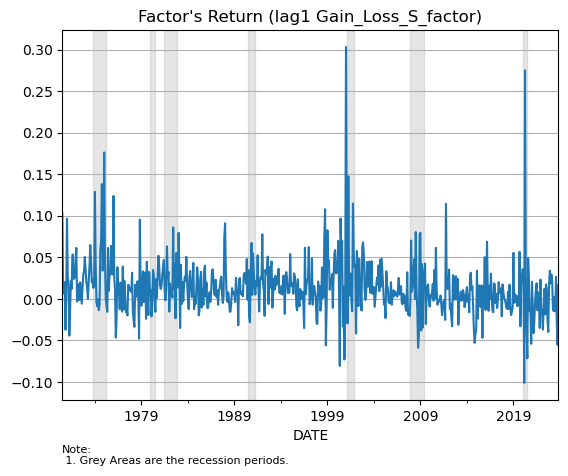

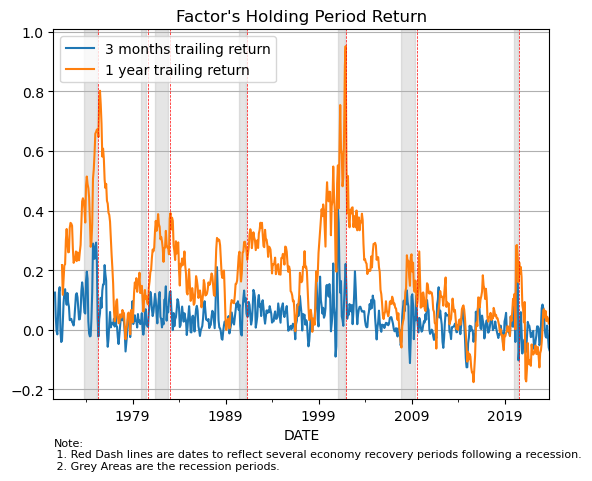

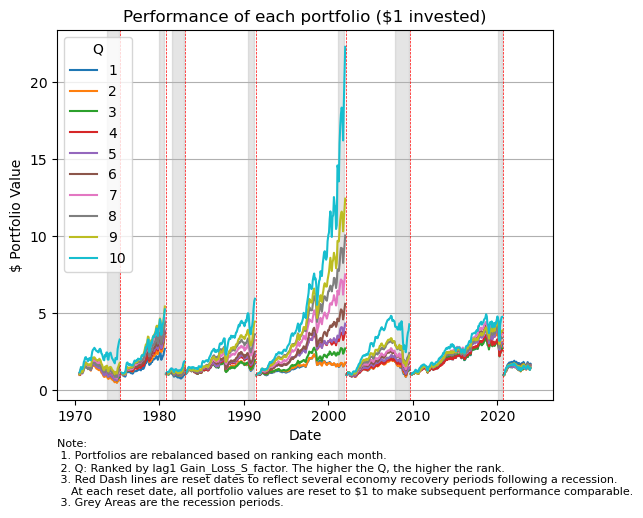

In [141]:
perf(df_Gain_Loss_S_factor, 'lag1 Gain_Loss_S_factor', q = 10, check_robustness = False, portfolio_weight='equal')

Try for different hyperparameter:

In [97]:
"""
results_parameters_pairs = []
df_temp = pd.read_feather('crsp_compustat_combined.feather')
# we only want to study sample after 1970
df_temp = df_temp[df_temp.index.get_level_values('DATE') > '1970-01-01']
df_temp = df_temp[df_temp.index.get_level_values('DATE') < '2023-12-01'] # some annual data hasn't came out
for i in range(2,60):

    print(f'Running window size of {i}')
    df_Gain_Loss_parameters = df_temp.copy()

    # Calculate vwap 
    window_gls_factor =i # I use 3 as the window because retail investors are often short-term investor
    df_Gain_Loss_parameters['weight_by_volumn'] = df_Gain_Loss_parameters['VOL']/(df_Gain_Loss_parameters['VOL'].groupby('PERMNO').rolling(window_gls_factor).sum().droplevel(0))
    df_Gain_Loss_parameters['vwap'] = (df_Gain_Loss_parameters['PRC']*df_Gain_Loss_parameters['weight_by_volumn']).groupby('PERMNO').rolling(window_gls_factor).sum().droplevel(0)
    
    # Normalize current stock price by vwap
    df_Gain_Loss_parameters['Gain_Loss_S_factor'] = (df_Gain_Loss_parameters['PRC']-df_Gain_Loss_parameters['vwap'])/df_Gain_Loss_parameters['vwap']
    # Change the sign because we want to long stock with current price under the vwap, short stock with current price above the vwap
    df_Gain_Loss_parameters['Gain_Loss_S_factor'] = - df_Gain_Loss_parameters['Gain_Loss_S_factor']
    
    # to lag 1 to avoid look ahead bias
    df_Gain_Loss_parameters['lag1 Gain_Loss_S_factor'] = df_Gain_Loss_parameters['Gain_Loss_S_factor'].groupby('PERMNO').shift(1)
    
    df_Gain_Loss_parameters = df_Gain_Loss_parameters.reorder_levels(['DATE','PERMNO'])
    df_Gain_Loss_parameters.sort_index(inplace=True)


    
    #First we have to only apply this factor in small stocks, but we don't want tiny stocks - too illiquid.
    df_Gain_Loss_parameters['Q_from_MV'] = df_Gain_Loss_parameters['MV'].groupby('DATE').apply(quantiles, q=10).reset_index(level=0, drop = True)
    
    # I remove big cap stock
    df_Gain_Loss_parameters =  df_Gain_Loss_parameters.loc[
        (df_Gain_Loss_parameters['Q_from_MV']<=8) & 
        (df_Gain_Loss_parameters['Q_from_MV']>=2)
        ].copy()
    

    # Eliminate Sample with missing concerned value
    df_Gain_Loss_parameters = df_Gain_Loss_parameters.dropna(subset=['RET', 'lag1 Gain_Loss_S_factor'])
    temp_stats = perf(df_Gain_Loss_parameters, 'lag1 Gain_Loss_S_factor', q = 10, portfolio_weight='equal', print_performance=False,output_stats= True)
    temp_stats.name = "Window(Month) = " + str(i)

    # Calculate alpha and beta for this strategy
    df_ports_return = get_portfolios_return(df_Gain_Loss_parameters, 'lag1 Gain_Loss_S_factor', q = 10,portfolio_weight='equal')
    df_ports_return  = pd.concat(((df_ports_return.loc[10] - df_ports_return.loc[1]),df_mkt), axis=1)
    df_ports_return = df_ports_return.dropna()

    # Creating the formula for the OLS regression
    formula = 'RET ~ Market_Excess_Return'
    # Fitting the OLS model
    model = smf.ols(formula=formula, data = df_ports_return).fit()
    # Displaying the model summary
       
    temp_stats['α'] = model.params['Intercept']
    temp_stats['p_value (α)'] = model.pvalues['Intercept']
    temp_stats['β_Market'] = model.params['Market_Excess_Return']
    temp_stats['p_value (β_Market)'] = model.pvalues['Market_Excess_Return']
    temp_stats['R-squared'] = model.rsquared
    # Only show value down to 4 digits to make improve the table's clarity"
    temp_stats = temp_stats.apply(lambda x: f"{x:.4f}")#temp_stats.round(4)
    
    results_parameters_pairs.append(temp_stats)
df_Gain_Loss_S_factor_parameter_testing = pd.DataFrame(results_parameters_pairs)
df_Gain_Loss_S_factor_parameter_testing.to_csv('Parameter_Testing/VWAP_reversing(Loss Aversion, Anchoring Bias, Representativeness).csv')
"""

'\nresults_parameters_pairs = []\ndf_temp = pd.read_feather(\'crsp_compustat_combined.feather\')\n# we only want to study sample after 1970\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') > \'1970-01-01\']\ndf_temp = df_temp[df_temp.index.get_level_values(\'DATE\') < \'2023-12-01\'] # some annual data hasn\'t came out\nfor i in range(2,60):\n\n    print(f\'Running window size of {i}\')\n    df_Gain_Loss_parameters = df_temp.copy()\n\n    # Calculate vwap \n    window_gls_factor =i # I use 3 as the window because retail investors are often short-term investor\n    df_Gain_Loss_parameters[\'weight_by_volumn\'] = df_Gain_Loss_parameters[\'VOL\']/(df_Gain_Loss_parameters[\'VOL\'].groupby(\'PERMNO\').rolling(window_gls_factor).sum().droplevel(0))\n    df_Gain_Loss_parameters[\'vwap\'] = (df_Gain_Loss_parameters[\'PRC\']*df_Gain_Loss_parameters[\'weight_by_volumn\']).groupby(\'PERMNO\').rolling(window_gls_factor).sum().droplevel(0)\n    \n    # Normalize current stock price by vw

## Evaluation For Volatility Factor

In [98]:
# I remove stocks with volatility = 0, because this does not make sense and may due to missing value in returns
# I also rove stocks with volatility > 20% (per month), which is roughly 70% each year, it make no sense for investor hold this kind of stock
df_volatility =  df.loc[(df['lag1 Volatility']>0) & (df['lag1 Volatility']<0.2)].copy()
# Eliminate Sample with missing concerned value
df_volatility = df_volatility.dropna(subset=['RET', 'lag1 Volatility'])

In [99]:
df_volatility['lag1 Volatility'].describe()

count    1.126764e+06
mean     1.043368e-01
std      3.852992e-02
min      1.165016e-02
25%      7.443833e-02
50%      9.907946e-02
75%      1.306045e-01
max      1.999991e-01
Name: lag1 Volatility, dtype: float64

In [100]:
print('Whole dataset size: ',df.shape)
print('Volatility_factor dataset size: ',df_volatility.shape)

Whole dataset size:  (1527557, 115)
Volatility_factor dataset size:  (1126764, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   611.0  0.010947  0.032309 -0.172229 -0.004489  0.013773  0.028744   
2   611.0  0.011898  0.039722 -0.214156 -0.008260  0.014503  0.034626   
3   611.0  0.011957  0.043489 -0.247497 -0.009632  0.016017  0.036080   
4   611.0  0.012295  0.047776 -0.248481 -0.012631  0.016762  0.041421   
5   611.0  0.012276  0.051392 -0.279669 -0.014746  0.015778  0.040615   
6   611.0  0.012829  0.054804 -0.289168 -0.016343  0.015076  0.043884   
7   611.0  0.013048  0.057629 -0.286816 -0.017616  0.014858  0.046808   
8   611.0  0.012970  0.061555 -0.307380 -0.021585  0.016600  0.048751   
9   611.0  0.013286  0.066642 -0.324437 -0.024873  0.014565  0.051791   
10  611.0  0.012899  0.072153 -0.328066 -0.027264  0.014546  0.054934   

         max  
Q             
1   0.226195  
2   0.175234  
3

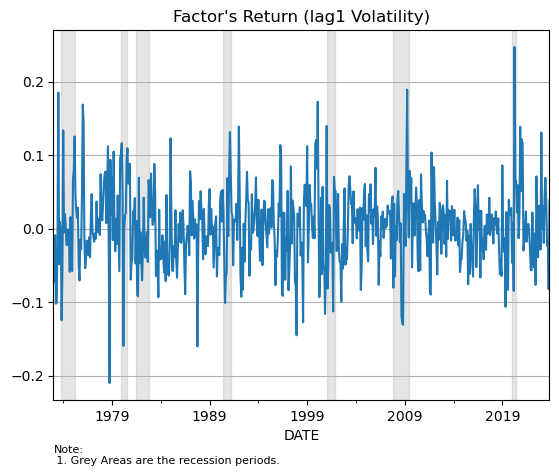

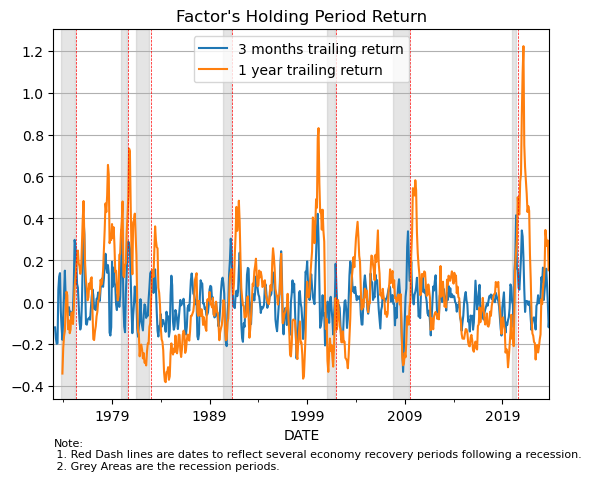

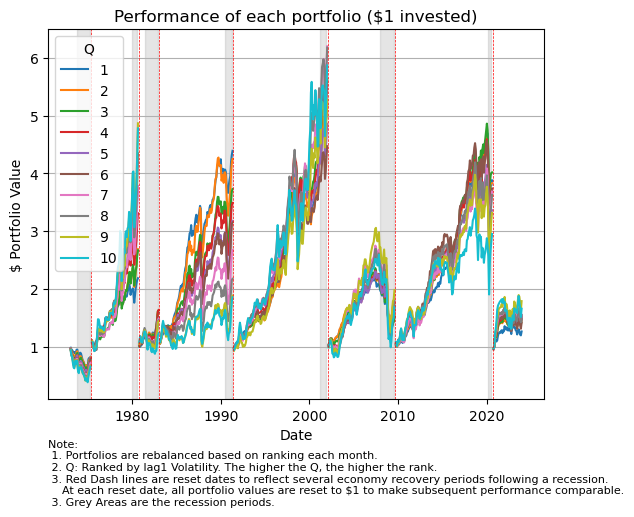

Signal_Robustness_Analyzing......


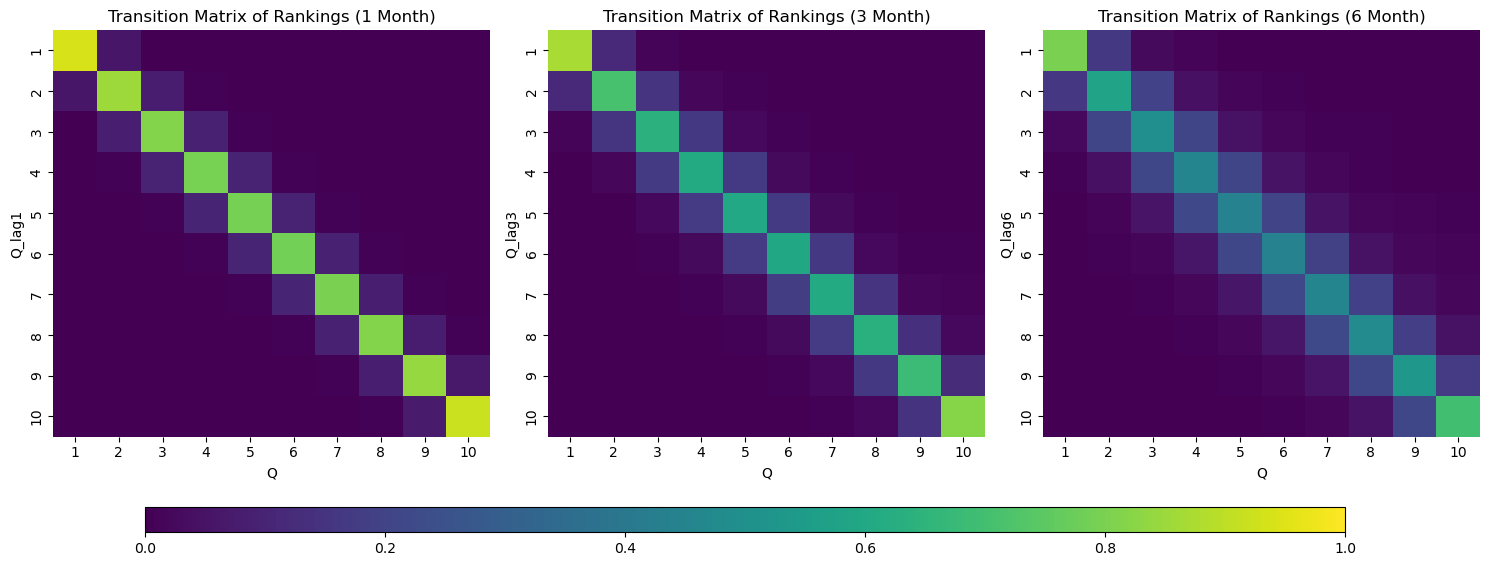

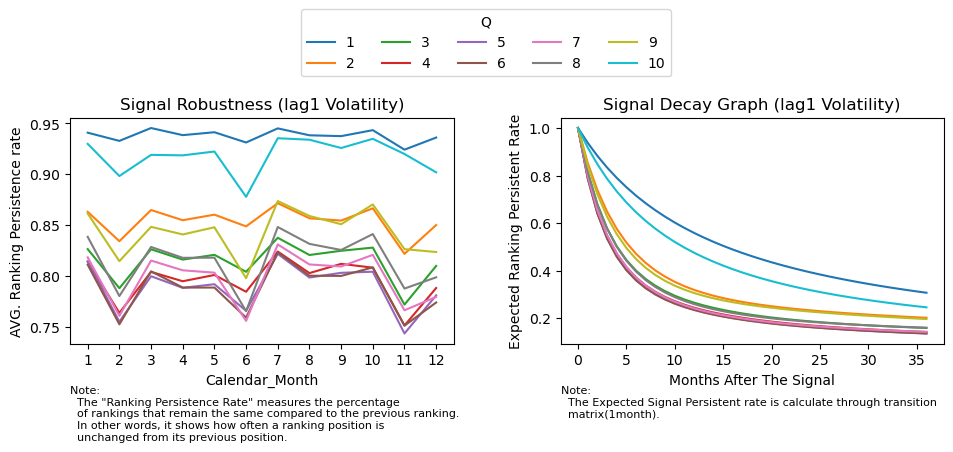

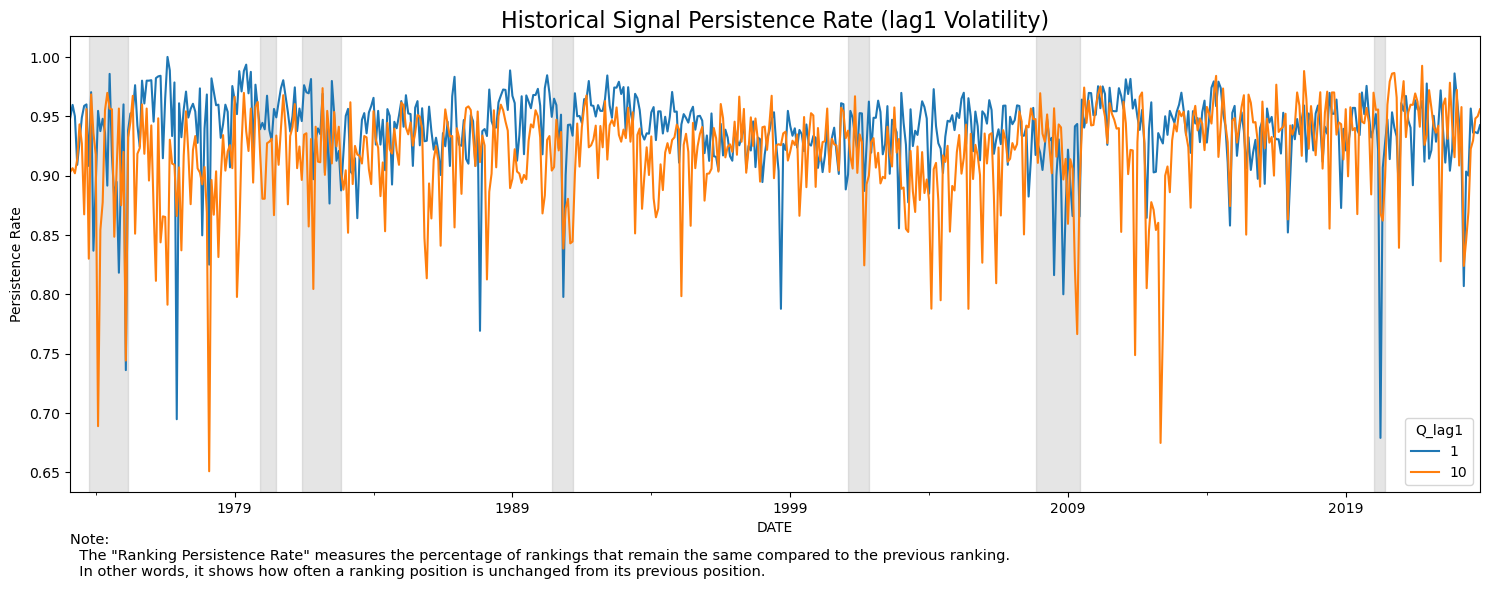

In [106]:
perf(df_volatility, 'lag1 Volatility', q = 10, check_robustness = True, portfolio_weight='equal')

## Evaluation For Momentum Factor

In [107]:
# I remove stocks with momentum below -.1 or above .1. These are very extreme values. 
# Removing them has little effect on the results below, though it does improve them slightly.
df_momentum = df.loc[(df['momentum']>-0.1)&(df['momentum']<0.1)].copy() #
# Eliminate Sample with missing concerned value
df_momentum  = df_momentum.dropna(subset=['RET', 'momentum'])

In [108]:
df_momentum['momentum'].describe()

count    1.421070e+06
mean     1.197874e-02
std      3.165682e-02
min     -9.999782e-02
25%     -6.512818e-03
50%      1.195409e-02
75%      3.099036e-02
max      9.999727e-02
Name: momentum, dtype: float64

In [109]:
print('Whole dataset size: ',df.shape)
print('momentum dataset size: ',df_momentum.shape)

Whole dataset size:  (1527557, 115)
momentum dataset size:  (1421070, 115)


---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   635.0  0.006060  0.070903 -0.295933 -0.036385  0.004290  0.046913   
2   635.0  0.009037  0.058139 -0.259234 -0.021433  0.009714  0.038576   
3   635.0  0.010300  0.053445 -0.236791 -0.018772  0.011792  0.038581   
4   635.0  0.010461  0.050130 -0.241726 -0.016584  0.013892  0.038033   
5   635.0  0.011507  0.048908 -0.259930 -0.013973  0.015805  0.040076   
6   635.0  0.012060  0.048413 -0.262766 -0.014218  0.015684  0.040423   
7   635.0  0.013076  0.049256 -0.282631 -0.011905  0.016128  0.041183   
8   635.0  0.013603  0.050421 -0.289240 -0.016371  0.016600  0.043263   
9   635.0  0.015171  0.054113 -0.299205 -0.016467  0.017716  0.048279   
10  635.0  0.016400  0.062708 -0.323439 -0.019220  0.019029  0.056354   

         max  
Q             
1   0.361513  
2   0.315785  
3

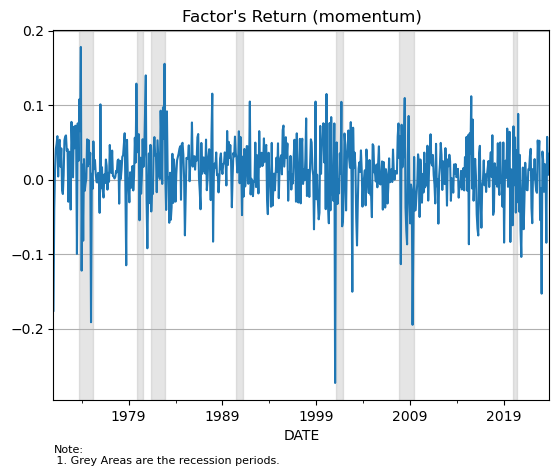

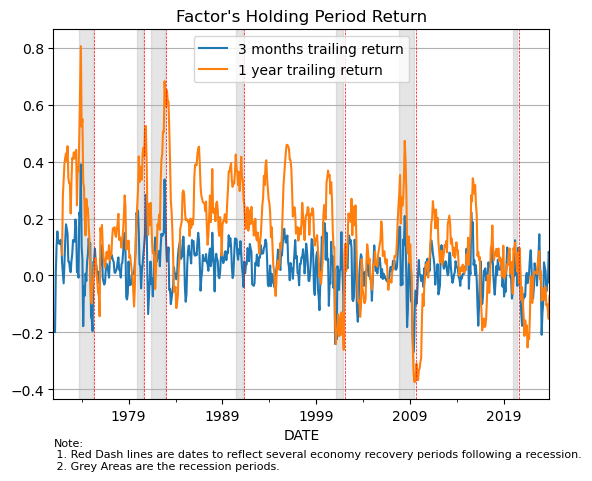

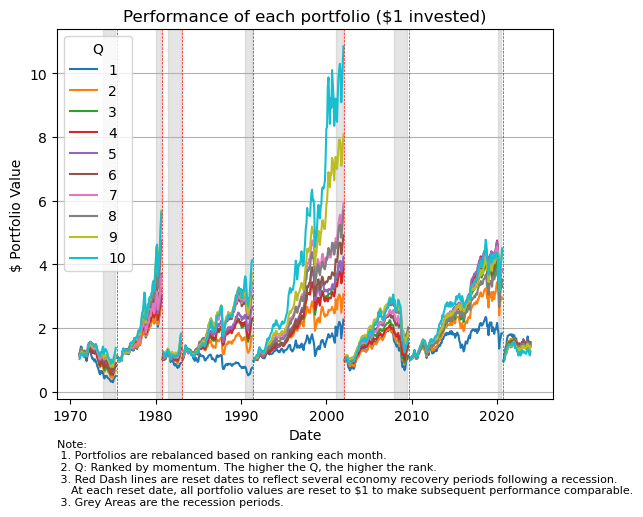

Signal_Robustness_Analyzing......


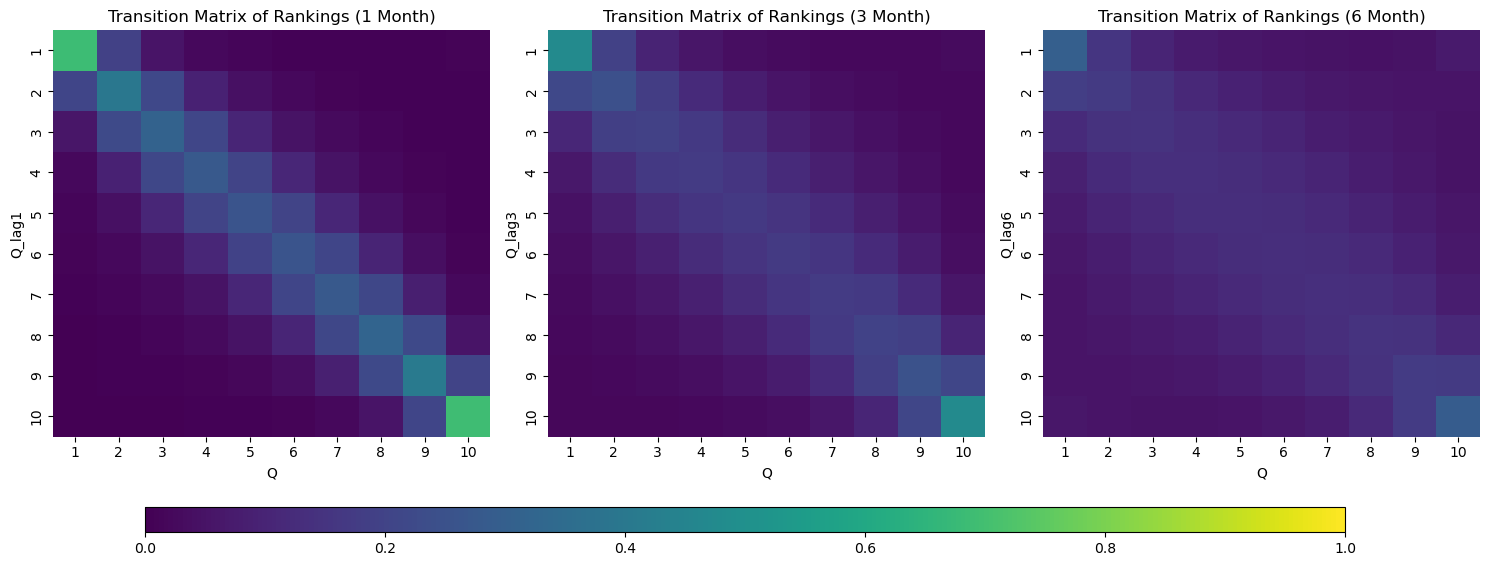

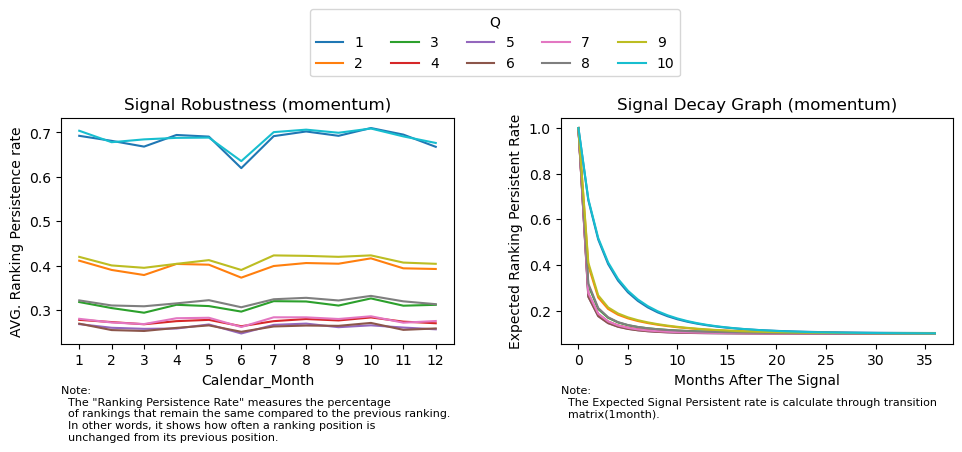

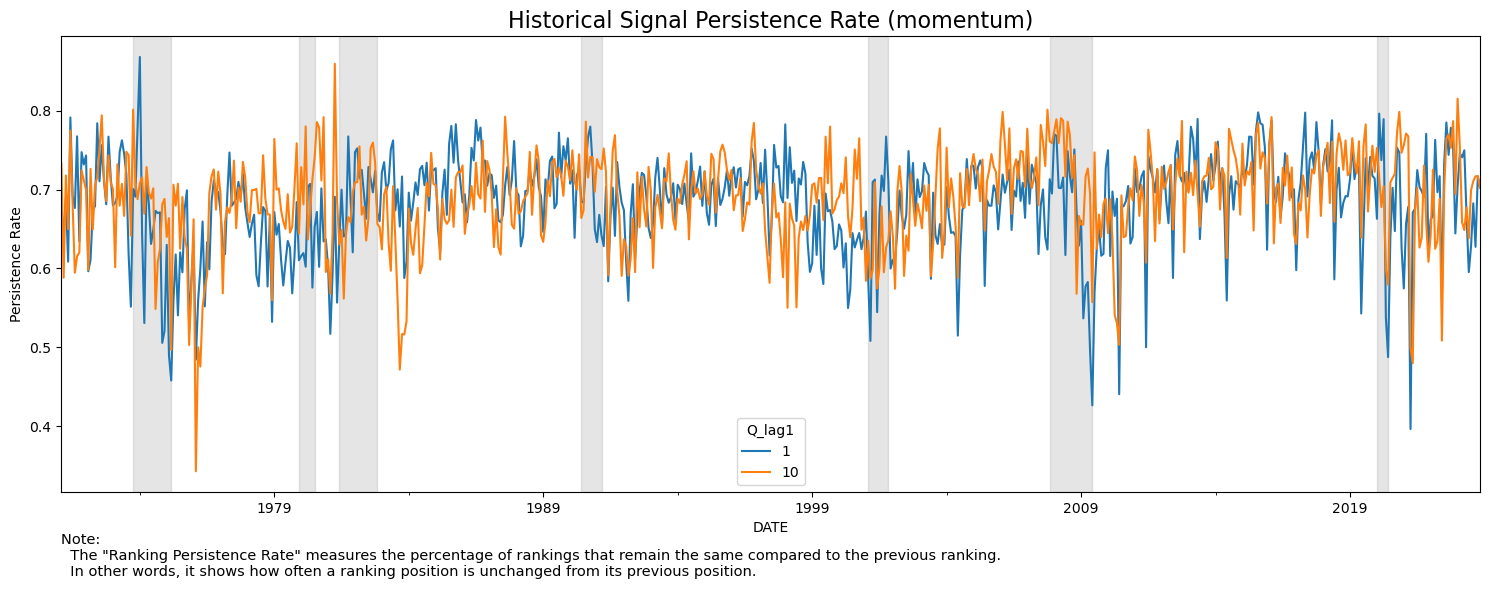

In [110]:
perf(df_momentum, 'momentum', q = 10, check_robustness=True,  portfolio_weight = 'equal')

## Evaluation For Profitability Factor

In [111]:
# some of data may got value of -inf or inf because of "AT = 0 or AT = nan", I will exclude any stocks with extreme lag IBAT Value
df_profitability_factor = df.loc[(df['lag IBAT']>0)&(df['lag IBAT']<0.5)].copy() #
# Eliminate Sample with missing concerned value
df_value_factor = df_value_factor.dropna(subset=['RET', 'lag IBAT'])

In [112]:
df_profitability_factor['lag IBAT'].describe()

count    1.526929e+06
mean     5.795343e-02
std      5.244776e-02
min      3.039578e-06
25%      1.668035e-02
50%      4.531548e-02
75%      8.221720e-02
max      4.971553e-01
Name: lag IBAT, dtype: float64

In [113]:
print('Whole dataset size: ',df.shape)
print('Profitavility_Factor dataset size: ',df_profitability_factor.shape)

Whole dataset size:  (1527557, 115)
Profitavility_Factor dataset size:  (1526929, 115)


In [114]:
df_profitability_factor.groupby('DATE')['lag IBAT'].count()

DATE
1970-07-31      47
1970-08-31      75
1970-09-30     124
1970-10-31     169
1970-11-30     190
              ... 
2023-07-31    1633
2023-08-31    1651
2023-09-30    1623
2023-10-31    1599
2023-11-30    1571
Name: lag IBAT, Length: 641, dtype: int64

---------- Performance of Each Quantiles Portfolios----------
    count      mean       std       min       25%       50%       75%  \
Q                                                                       
1   641.0  0.011833  0.055562 -0.278440 -0.017528  0.013744  0.039511   
2   641.0  0.012203  0.054108 -0.264094 -0.016140  0.014475  0.041502   
3   641.0  0.012202  0.055573 -0.290325 -0.016799  0.012016  0.042578   
4   641.0  0.012286  0.053923 -0.286186 -0.017399  0.015585  0.043343   
5   641.0  0.011461  0.053843 -0.263536 -0.018755  0.014686  0.042002   
6   641.0  0.012131  0.055617 -0.261619 -0.020364  0.013849  0.045854   
7   641.0  0.012465  0.056318 -0.287146 -0.020041  0.016207  0.047216   
8   641.0  0.011775  0.055655 -0.284298 -0.020002  0.013377  0.045890   
9   641.0  0.012225  0.057604 -0.304721 -0.023603  0.014244  0.047858   
10  641.0  0.011900  0.058944 -0.294174 -0.023435  0.017061  0.049697   

         max  
Q             
1   0.350039  
2   0.333477  
3

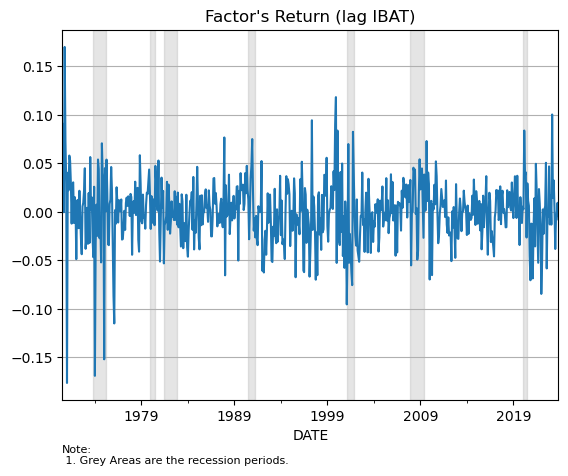

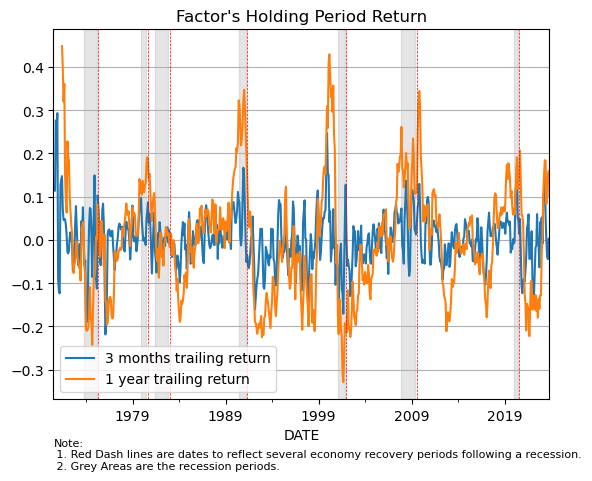

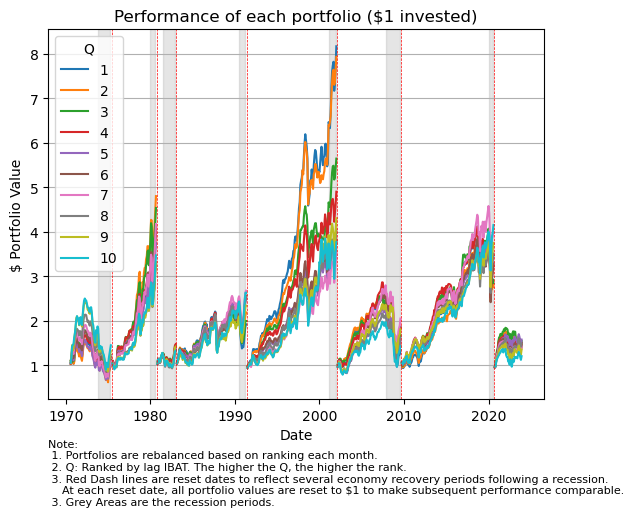

Signal_Robustness_Analyzing......


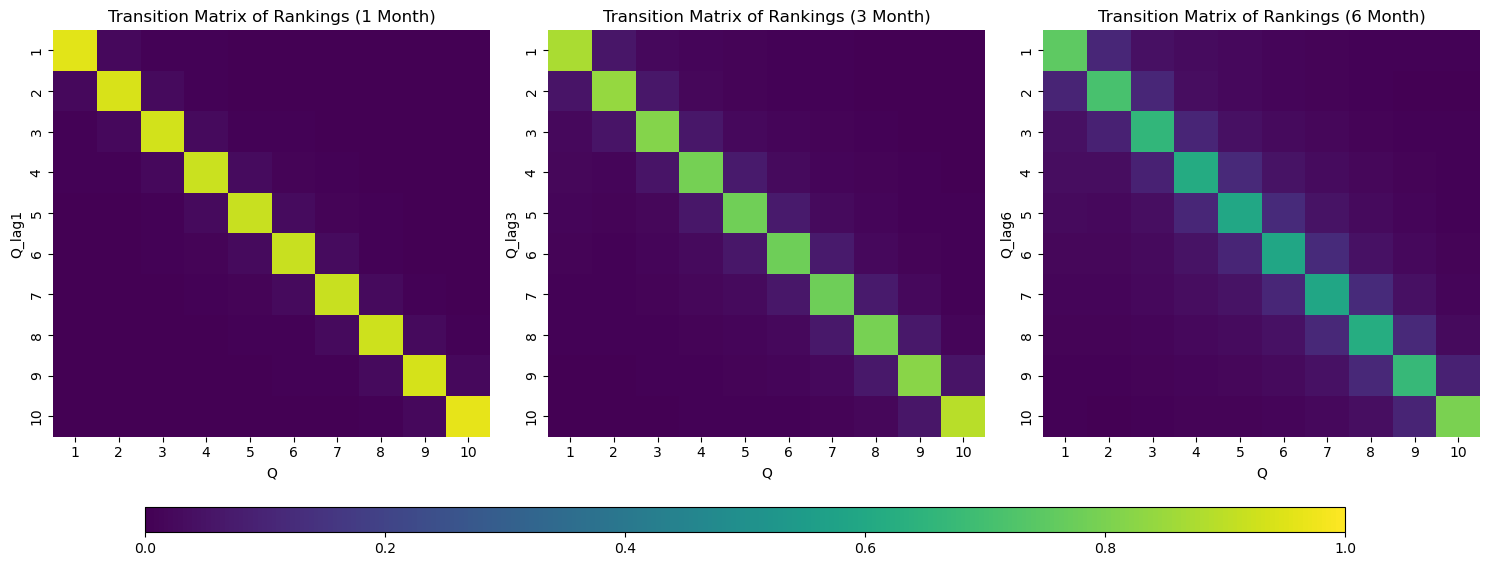

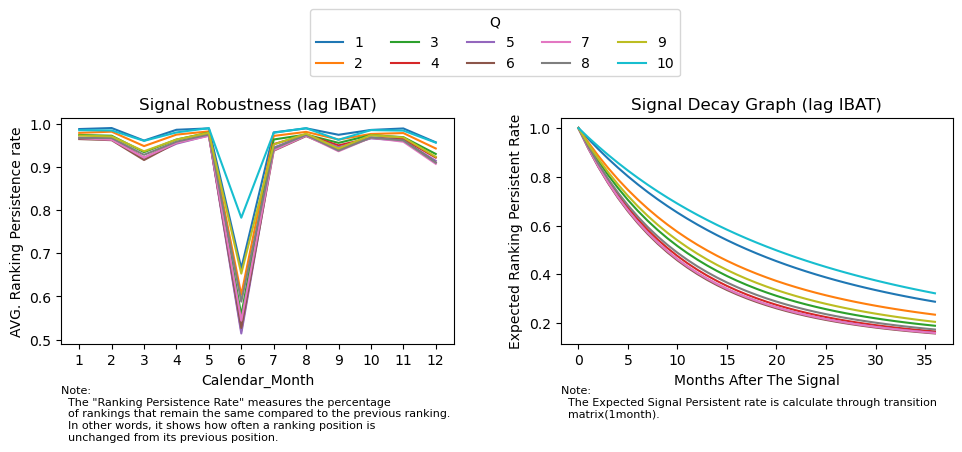

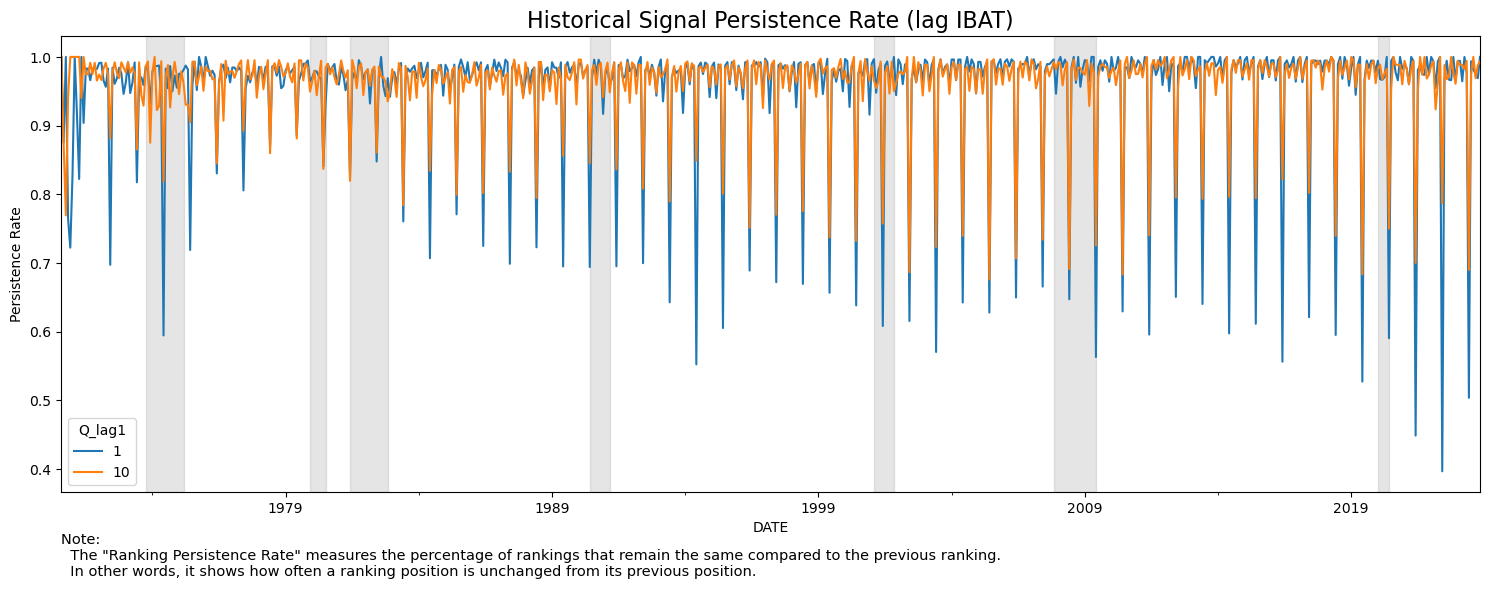

In [115]:
perf(df_profitability_factor, 'lag IBAT', check_robustness=True, q = 10, portfolio_weight='equal')

# 4. Factor Combination Research

In [116]:
def get_portfolio_return(data_set, factor_concerned, q = 5, portfolio_weight = 'value'):
    
    # creating the quintiles
    data_set['Q'] = data_set[factor_concerned].groupby('DATE').apply(quantiles, q=q).reset_index(level=0, drop = True)


    if portfolio_weight == 'value':
        #Calculating value weighted quantile portfolio
        temp_1 = data_set.reset_index().set_index(['Q','DATE', 'PERMNO']).sort_index().reset_index('PERMNO')
        temp_2 = pd.DataFrame(data_set.groupby(['Q','DATE'])['MV'].sum())
        temp_2 = temp_2.rename({'MV':'Quantile MV'}, axis=1)
        temp_1 = temp_1.join(temp_2, how='left')
        temp_1['Weight in Quantitle Portfolio'] = temp_1['MV']/temp_1['Quantile MV']
        ports = (temp_1['Weight in Quantitle Portfolio']*temp_1['RET']).groupby(['Q','DATE']).sum()
        ports.name = 'RET'
    elif portfolio_weight == 'equal':
        # computing quantile portfolio returns
        ports = data_set.groupby(['Q','DATE'])['RET'].mean()

    # plot the performance of each portfolio
    #perf_plotting(ports, factor_concerned)
    
    # printing out basic statistics on each portfolio
    #print(ports.groupby('Q').describe())
    
    # computing high minus low portfolios
    hml = ports.loc[q] - ports.loc[1]

    return hml
def stats(hml):
    # printing basic statistics plus sharpe and t-stat
    stats = hml.describe()    
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)    
    print(stats)
def max_draw_down(portfolio_value_history):
    df = pd.Series(portfolio_value_history)
    running_max = df.cummax()
    drawdown = (df - running_max) / running_max
    max_drawdown = drawdown.min()
    peak_value = running_max[drawdown.idxmin()]

    return {'Peak Value': peak_value, 'MaxDD': max_drawdown}

## Combining Volatility and Momentum Style

In [117]:
# I remove stocks with volatility = 0, because this does not make sense and may due to missing value in returns
# I also rove stocks with volatility > 20% (per month), it make no sense for investor hold this kind of stock
# I remove stocks with momentum below -.1 or above .1. These are very extreme values. 
df_style_combination_volatility_momentum = df.loc[ (df['lag1 Volatility']>0) & (df['lag1 Volatility']<0.2) & 
                    (df['momentum']>-.1) & (df['momentum']<.1)].copy()

### First Approach : Directly Invest half in one and half in the other one

In [118]:
df_hml_volatility = get_portfolio_return(df_style_combination_volatility_momentum, 'lag1 Volatility', portfolio_weight = 'equal')
df_hml_momentum = get_portfolio_return(df_style_combination_volatility_momentum, 'momentum', portfolio_weight = 'equal')

In [119]:
stats(df_hml_volatility)

count     611.000000
mean        0.001271
std         0.043461
min        -0.171658
25%        -0.024795
50%         0.000839
75%         0.026224
max         0.184209
tstat       0.723147
sharpe      0.101344
Name: RET, dtype: float64


In [120]:
stats(df_hml_momentum)

count     611.000000
mean        0.006666
std         0.034135
min        -0.171206
25%        -0.009405
50%         0.008589
75%         0.025285
max         0.134811
tstat       4.826882
sharpe      0.676452
Name: RET, dtype: float64


In [121]:
stats(.5*df_hml_volatility + .5*df_hml_momentum)

count     611.000000
mean        0.003969
std         0.025659
min        -0.138526
25%        -0.011362
50%         0.003762
75%         0.017408
max         0.115803
tstat       3.823135
sharpe      0.535784
Name: RET, dtype: float64


### Second Approach

&nbsp;&nbsp;&nbsp;An alternative way to combine signals is to normalize them and take the sum, i.e.
&nbsp;&nbsp;&nbsp;$$ score_{i,t} = \frac{vol_{i,t} - \mu^{vol}_t}{\sigma^{vol}_t} + \frac{mom_{i,t} - \mu^{mom}_t}{\sigma^{mom}_t} ,$$
&nbsp;&nbsp;&nbsp;where $\mu^x_t$ and $\sigma^x_t$ are the mean and SD of $x$ across all firms at date $t$. 

In [122]:
df_vol_mom = df_style_combination_volatility_momentum.copy()
df_vol_mom['score'] = (df_vol_mom['lag1 Volatility'] - df_vol_mom['lag1 Volatility'].groupby('DATE').mean())/df_vol_mom['lag1 Volatility'].groupby('DATE').std() \
    + (df_vol_mom['momentum'] - df_vol_mom['momentum'].groupby('DATE').mean())/df_vol_mom['momentum'].groupby('DATE').std()

In [123]:
df_hml_vol_mom_comb2 = get_portfolio_return(df_vol_mom, 'score', portfolio_weight='equal')

In [124]:
stats(df_hml_vol_mom_comb2)

count     611.000000
mean        0.005714
std         0.035027
min        -0.160651
25%        -0.015459
50%         0.005461
75%         0.023822
max         0.148791
tstat       4.032231
sharpe      0.565087
Name: RET, dtype: float64


### Third Approach

&nbsp;&nbsp;&nbsp;Do a two-way sort.  I will do independent quintile sorts on momentum and volatility.<br>  &nbsp;&nbsp;&nbsp;I will then go long stocks that are in the 5th quintile of both variables and short stocks that are in both 1st quintiles.

In [125]:
df_vol_mom_2 = df_style_combination_volatility_momentum.copy()
# creating the quintiles
df_vol_mom_2['Qvol'] = df_vol_mom_2['lag1 Volatility'].groupby('DATE').apply(quantiles, q=5).reset_index(level=0, drop = True)
df_vol_mom_2['Qmom'] = df_vol_mom_2['momentum'].groupby('DATE').apply(quantiles, q=5).reset_index(level=0, drop = True)

# computing quintile portfolio returns
ports = df_vol_mom_2.groupby(['Qvol','Qmom','DATE'])['RET'].mean()

# printing out basic statistics on each portfolio
print(ports.groupby(['Qmom','Qvol']).describe())

# computing high minus low portfolios
df_hml_vol_mom_comb3 = ports.loc[5,5] - ports.loc[1,1]

stats(df_hml_vol_mom_comb3)

           count      mean       std       min       25%       50%       75%  \
Qmom Qvol                                                                      
1    1     610.0  0.010084  0.046556 -0.214597 -0.011803  0.010407  0.033955   
     2     611.0  0.009823  0.052834 -0.209108 -0.017484  0.012587  0.040081   
     3     611.0  0.009838  0.059377 -0.259875 -0.018316  0.008193  0.040973   
     4     611.0  0.008789  0.065131 -0.292498 -0.029308  0.010626  0.043641   
     5     611.0  0.008733  0.074284 -0.320451 -0.032948  0.007463  0.051274   
2    1     611.0  0.010623  0.038830 -0.195632 -0.007468  0.012968  0.030459   
     2     611.0  0.010966  0.047934 -0.231244 -0.011960  0.013282  0.038072   
     3     611.0  0.011406  0.054214 -0.276760 -0.015844  0.012234  0.040020   
     4     611.0  0.011047  0.060392 -0.283816 -0.024949  0.011814  0.045076   
     5     611.0  0.011040  0.071055 -0.337970 -0.027685  0.011603  0.048247   
3    1     611.0  0.011627  0.036246 -0.

### Answer
High volatility stocks perform better within each momentum quitile.<br>
We can explain this in several ways. One of the most convincing is that, return is compensated for holding more risk, given the same momentum. <br>
However, the combining portfolio have high mean return but low sharpe ratio. The reason is that we are exposed to volatility factor which give us more volatility. The magtitude of return-risk reward is not big enough to increase sharpe ratio (if momentum is the benchmark portfolio).

## Combining Value and Momentum Style

In [126]:
# I will exclude stocks that have P/E ratios below 5 to avoid value trap
df_style_combination_value_momentum = df.loc[(df['Value_Factor_lagE/P(v1)']>0)  & (df['Value_Factor_lagE/P(v1)']>0)  & \
                    (df['Value_Factor_lagE/P(v2)']<.2) & (df['Value_Factor_lagE/P(v2)']<.2) & \
                    (df['momentum']>-.1) & (df['momentum']<.1)].copy()

### First Approach : Directly Invest half in one and half in the other one

In [127]:
# I remove stocks with momentum below -.1 or above .1. These are very extreme values. 
# Removing them has little effect on the results below, though it does improve them slightly.
df_hml_value_version2 = get_portfolio_return(df_style_combination_value_momentum, 'Value_Factor_lagE/P(v2)', portfolio_weight='equal')
df_hml_momentum = get_portfolio_return(df_style_combination_value_momentum, 'momentum', portfolio_weight='equal')

In [128]:
stats(df_hml_value_version2)

count     635.000000
mean        0.004535
std         0.028836
min        -0.159896
25%        -0.010126
50%         0.003190
75%         0.018353
max         0.107231
tstat       3.962742
sharpe      0.544753
Name: RET, dtype: float64


In [129]:
stats(df_hml_momentum)

count     635.000000
mean        0.008231
std         0.035547
min        -0.202399
25%        -0.009272
50%         0.010735
75%         0.027564
max         0.145081
tstat       5.834765
sharpe      0.802097
Name: RET, dtype: float64


In [130]:
stats(.5*df_hml_value_version2 + .5*df_hml_momentum)

count     635.000000
mean        0.006383
std         0.015577
min        -0.069022
25%        -0.001872
50%         0.006505
75%         0.014129
max         0.059902
tstat      10.325260
sharpe      1.419400
Name: RET, dtype: float64


### Second Approach

&nbsp;&nbsp;&nbsp;An alternative way to combine signals is to normalize them and take the sum, i.e.
&nbsp;&nbsp;&nbsp;$$ score_{i,t} = \frac{ep_{i,t} - \mu^{ep}_t}{\sigma^{ep}_t} + \frac{mom_{i,t} - \mu^{mom}_t}{\sigma^{mom}_t} ,$$
&nbsp;&nbsp;&nbsp;where $\mu^x_t$ and $\sigma^x_t$ are the mean and SD of $x$ across all firms at date $t$. 

In [131]:
df_val_mom_2 = df_style_combination_value_momentum.copy()
df_val_mom_2['score'] = (df_val_mom_2['Value_Factor_lagE/P(v2)'] - df_val_mom_2['Value_Factor_lagE/P(v2)'].groupby('DATE').mean())/df_val_mom_2['Value_Factor_lagE/P(v2)'].groupby('DATE').std() \
    + (df_val_mom_2['momentum'] - df_val_mom_2['momentum'].groupby('DATE').mean())/df_val_mom_2['momentum'].groupby('DATE').std()

In [132]:
df_hml_value_mom_comb2 = get_portfolio_return(df_val_mom_2, 'score', portfolio_weight='equal')

In [133]:
stats(df_hml_value_mom_comb2)

count     635.000000
mean        0.010364
std         0.023361
min        -0.108027
25%        -0.001593
50%         0.010564
75%         0.022542
max         0.100040
tstat      11.179777
sharpe      1.536869
Name: RET, dtype: float64


### Third Approach

&nbsp;&nbsp;&nbsp;Do a two-way sort.  I will do independent quintile sorts on EP and momentum.<br>  &nbsp;&nbsp;&nbsp;I will then go long stocks that are in the 5th quintile of both variables and short stocks that are in both 1st quintiles.

In [134]:
df_val_mom_3 = df_style_combination_value_momentum.copy()
# creating the quintiles
df_val_mom_3['Qep'] = df_val_mom_3['Value_Factor_lagE/P(v2)'].groupby('DATE').apply(quantiles, q=5).reset_index(level=0, drop = True)
df_val_mom_3['Qmom'] = df_val_mom_3['momentum'].groupby('DATE').apply(quantiles, q=5).reset_index(level=0, drop = True)

# computing quintile portfolio returns (equal weighted)
ports = df_val_mom_3.groupby(['Qep','Qmom','DATE'])['RET'].mean()

# computing quintile portfolio returns (value weighted)
'''
temp_1 = df_val_mom_3.reset_index().set_index(['Qep','Qmom','DATE', 'PERMNO']).sort_index().reset_index('PERMNO')
temp_2 = pd.DataFrame(df_val_mom_3.groupby(['Qep','Qmom','DATE'])['MV'].sum())
temp_2 = temp_2.rename({'MV':'Quantile MV'}, axis=1)
temp_1 = temp_1.join(temp_2, how='left')
temp_1['Weight in Quantitle Portfolio'] = temp_1['MV']/temp_1['Quantile MV']
ports = (temp_1['Weight in Quantitle Portfolio']*temp_1['RET']).groupby(['Qep','Qmom','DATE']).sum()
ports.name = 'RET'
'''
# printing out basic statistics on each portfolio
print(ports.groupby(['Qep','Qmom']).describe())

# computing high minus low portfolios
df_hml_value_mom_comb3 = ports.loc[5,5] - ports.loc[1,1]

stats(df_hml_value_mom_comb3)

          count      mean       std       min       25%       50%       75%  \
Qep Qmom                                                                      
1   1     635.0  0.002477  0.070334 -0.310705 -0.036043  0.002280  0.039573   
    2     635.0  0.007035  0.059659 -0.286601 -0.027213  0.008210  0.042301   
    3     635.0  0.008524  0.056679 -0.297910 -0.025986  0.010616  0.044253   
    4     635.0  0.010637  0.055628 -0.298306 -0.021464  0.013216  0.043884   
    5     635.0  0.015000  0.063004 -0.313854 -0.022981  0.018960  0.054139   
2   1     635.0  0.005232  0.067288 -0.318634 -0.031544  0.005228  0.044497   
    2     635.0  0.008144  0.053871 -0.289360 -0.022208  0.010276  0.038820   
    3     635.0  0.009773  0.050421 -0.268568 -0.017638  0.013905  0.038308   
    4     635.0  0.011706  0.051058 -0.291806 -0.017707  0.013938  0.043910   
    5     635.0  0.014729  0.056517 -0.308719 -0.016936  0.017429  0.049515   
3   1     635.0  0.006269  0.063244 -0.269082 -0.028

## Multi Factor Ranking Blending Experiment

In [142]:
dict_factor_name_to_dataset = {'lag Sector Familiarity EW Factor':df_Familiarity, 
                               #'lag (%sale - %inventory)':df_diff_change_sale_inventory,
                               #'lag1 Herding_naive_volumn':df_herding,
                               'lag1 Gain_Loss_S_factor':df_Gain_Loss_S_factor,
                               #'lag1 Volatility':df_volatility,
                               'momentum':df_momentum,
                               'valuation_z_score_first_difference':df_valuation_converger,
                               #'lag IBAT':df_profitability_factor,
                               'Value_Factor_lagE/P(v2)':df_value_factor,
                                }

In [143]:
scorer = {}
for factor_name, dataset in dict_factor_name_to_dataset.items():

    # copy dataset to prevent overwriting
    df_temp_scorer = dataset.copy()

    # calculating score
    temp_mean = df_temp_scorer[factor_name].groupby('DATE').mean()
    temp_std = df_temp_scorer[factor_name].groupby('DATE').std()
    df_temp_scorer['factor mean'] = df_temp_scorer.index.get_level_values('DATE').map(temp_mean)
    df_temp_scorer['factor std'] = df_temp_scorer.index.get_level_values('DATE').map(temp_std)
    df_temp_scorer['score'] = (df_temp_scorer[factor_name] - temp_mean)/temp_std 

    # record the score for this factor
    scorer[factor_name] = pd.DataFrame(df_temp_scorer['score'])

In [144]:
df_investing_universe = df.copy()
# Only invest in stock with stock price bigger than 5
df_investing_universe = df_investing_universe[df_investing_universe['PRC']>=5]
# mapping the score data and the data in the investing universe
score_names = []
for factor_name, temp_score in scorer.items():
    score_name_ = 'score:'+factor_name
    score_names.append(score_name_)
    df_investing_universe[score_name_] = temp_score

# Excluding stocks with missing score value
df_investing_universe = df_investing_universe.dropna(subset=score_names)

In [145]:
score_names

['score:lag Sector Familiarity EW Factor',
 'score:lag1 Gain_Loss_S_factor',
 'score:momentum',
 'score:valuation_z_score_first_difference',
 'score:Value_Factor_lagE/P(v2)']

In [146]:
# equal weighted scoring system
# 'Momentum', 'Value', 'Sector(Familiarity,FOMO,Herding)', 'Valuation Convergence', "Loss Aversion Riding"
temp_score_choices = ['score:momentum', 'score:Value_Factor_lagE/P(v2)', 'score:lag Sector Familiarity EW Factor', 'score:valuation_z_score_first_difference', 'score:lag1 Gain_Loss_S_factor']
df_investing_universe['Total Score']  = df_investing_universe[temp_score_choices].sum(axis=1)
df_investing_universe['Ranking'] = df_investing_universe['Total Score'].groupby('DATE').apply(quantiles, q = 10).reset_index(level=0, drop = True)

In [147]:
df_investing_universe = df_investing_universe.groupby(['Ranking','DATE'])['RET'].mean()
ret_strategy_ranking = df_investing_universe.loc[10]
ret_strategy_ranking.name = 'ret_Ranking Strategy'
ret_strategy_ranking = pd.DataFrame(ret_strategy_ranking).join(irxdata)
ret_strategy_ranking['Ranking Strategy'] = ret_strategy_ranking['ret_Ranking Strategy'] - ret_strategy_ranking['rfret']
ret_strategy_ranking = ret_strategy_ranking['Ranking Strategy']

In [148]:
ret_strategy_ranking.describe()

count    599.000000
mean       0.019086
std        0.059209
min       -0.273316
25%       -0.013600
50%        0.020209
75%        0.053870
max        0.316395
Name: Ranking Strategy, dtype: float64

# 5. Generate Factor Return Series

In [149]:
def Strategy_Testing(factors_included, df_factors, periods = 'recession'): 

    
    if periods == 'recession':
        periods = [
        ('1973-11-30', '1975-03-31'),
        ('1980-01-31', '1980-07-31'),
        ('1981-07-31', '1982-11-30'),
        ('1990-07-31', '1991-03-31'),
        ('2001-03-31', '2001-11-30'),
        ('2007-12-31', '2009-06-30'),
        ('2020-02-29', '2020-06-30')]
    elif periods == '10y':
        periods = [
        ('1970-01-31', '1979-12-31'),
        ('1990-01-31', '1999-12-31'),
        ('2010-01-31', '2019-12-31'),
        ('2030-01-31', '2039-12-31')]
    elif periods == '5y':
        periods = [
            ('1970-01-31', '1974-12-31'),
            ('1980-01-31', '1984-12-31'),
            ('1990-01-31', '1994-12-31'),
            ('2000-01-31', '2004-12-31'),
            ('2010-01-31', '2014-12-31'),
            ('2020-01-31', '2024-12-31')]
    else:
        periods = periods 
    
    # assume we can take leverage
    #strategy = df_factors[factors_included].mean(axis=1) * len(factors_included)
    
    strategy = df_factors[factors_included].mean(axis=1) 
    
    strategy.name = "Strategy_Return"
    stats = pd.DataFrame(strategy).describe()
    stats.loc['tstat']  = stats.loc['mean'] / stats.loc['std'] * np.sqrt(stats.loc['count'])
    stats.loc['sharpe'] = stats.loc['mean'] / stats.loc['std'] * np.sqrt(12)
    
    
    # Begin performance analysis
    # include market information
    strategy_tester = pd.concat((strategy, df_mkt[['Market_Excess_Return', 'rfret']]), axis = 1).dropna()
    

    
    # Divide strategy performance calculation into certatin periods to get insight!
    strategy_tester['Period Splitter'] = 0
    for index, (start, end) in enumerate(periods):
        
        strategy_tester.loc[strategy_tester.index >= start, 'Period Splitter'] += 1
        strategy_tester.loc[strategy_tester.index > end, 'Period Splitter'] += 1
    strategy_periods_stats = strategy_tester.groupby('Period Splitter').apply(lambda x: x['Strategy_Return'].describe())
    strategy_periods_stats['tstat'] = strategy_periods_stats['mean']/strategy_periods_stats['std'] * np.sqrt(strategy_periods_stats['count'])
    strategy_periods_stats['sharpe ratio'] = strategy_periods_stats['mean']/ strategy_periods_stats['std'] * np.sqrt(12) 
    # Calculate Max Draw Down
    strategy_max_dd = strategy_tester.groupby('Period Splitter').apply(lambda x: max_draw_down((x['Strategy_Return']+1).cumprod())['MaxDD'])
    strategy_periods_stats['MaxDD'] = strategy_max_dd
    # Calculate alpha and Market Beta
    strategy_periods_model = strategy_tester.groupby('Period Splitter').apply(lambda x: smf.ols(formula='Strategy_Return ~ Market_Excess_Return', data = x).fit())
    Regression_Result = {}
    for i in strategy_periods_model.index:
        model = strategy_periods_model.loc[i]
        temp_stats = {}
        temp_stats['α'] = model.params['Intercept']
        temp_stats['p_value (α)'] = model.pvalues['Intercept']
        temp_stats['β_Market'] = model.params['Market_Excess_Return']
        temp_stats['p_value (β_Market)'] = model.pvalues['Market_Excess_Return']
        temp_stats['R-squared'] = model.rsquared
        temp_stats = pd.Series(temp_stats)
        # Only show value down to 4 digits to make improve the table's clarity"
        temp_stats = temp_stats.apply(lambda x: f"{x:.4f}")#temp_stats.round(4)
        Regression_Result[i] = temp_stats
    # Concat the result!!
    strategy_periods_stats = pd.concat((strategy_periods_stats, pd.DataFrame(Regression_Result).T), axis = 1)
    # Change the index to the corresponding time periods
    Time_boundary = strategy_tester.groupby('Period Splitter').apply(lambda x: (x.index[0], x.index[-1]))
    Time_boundary = [(str(date[0])[:7], str(date[1])[:7]) for i, date in Time_boundary.items()]
    Time_boundary = [ dates[0]+' ~ '+dates[1] for dates in Time_boundary]
    strategy_periods_stats.index = Time_boundary
    # Format value to 4th decimal to increase clarity
    strategy_periods_stats = strategy_periods_stats.round(4)
    strategy_periods_stats['count'] = strategy_periods_stats['count'].astype(int)

    return stats, strategy_periods_stats

In [150]:
RET_sector_familiarity = get_portfolio_return(df_Familiarity, 'lag Sector Familiarity EW Factor', q = 10,  portfolio_weight='equal')
RET_diff_change_sale_inventory = get_portfolio_return(df_diff_change_sale_inventory, 'lag (%sale - %inventory)', q = 10, portfolio_weight='equal')
RET_herding = get_portfolio_return(df_herding, 'lag1 Herding_naive_volumn', q = 10, portfolio_weight='equal')
RET_Gain_Loss_S_factor = get_portfolio_return(df_Gain_Loss_S_factor, 'lag1 Gain_Loss_S_factor', q = 10, portfolio_weight='equal')
RET_volatility = get_portfolio_return(df_volatility, 'lag1 Volatility', q = 10, portfolio_weight='equal')
RET_momentum = get_portfolio_return(df_momentum, 'momentum', q = 10, portfolio_weight='equal')
RET_valuation_converger = get_portfolio_return(df_valuation_converger, 'valuation_z_score_first_difference', q = 10, portfolio_weight='equal')
RET_profitability_factor = get_portfolio_return(df_profitability_factor, 'lag IBAT', q = 10, portfolio_weight='equal')
RET_value = get_portfolio_return(df_value_factor,'Value_Factor_lagE/P(v2)', portfolio_weight='equal', q = 10)
RET_ranking_strategy = ret_strategy_ranking

In [151]:
RET_sector_familiarity.name = 'Sector(Familiarity,FOMO,Herding)'
RET_diff_change_sale_inventory.name = "%Sale - %Inventory"
RET_herding.name = "Herding"
RET_Gain_Loss_S_factor.name = "Loss Aversion Riding"
RET_volatility.name = "Volatility"
RET_momentum.name = "Momentum"
RET_valuation_converger.name = "Valuation Convergence"
RET_profitability_factor.name = "Profitability"
RET_value.name = 'Value'
RET_ranking_strategy.name = 'Our Strategy (Ranking Method)'

In [152]:
df_factors = pd.concat((RET_sector_familiarity, RET_diff_change_sale_inventory, RET_herding, RET_Gain_Loss_S_factor,
          RET_volatility, RET_momentum, RET_valuation_converger, RET_profitability_factor, RET_value, RET_ranking_strategy,df_mkt[['Market_Excess_Return', 'rfret']]), axis=1).dropna()
df_factors = df_factors.rename({'rfret':'Risk Free Return'}, axis=1)
# Export Factors to do further analysis
df_factors.to_feather('factors_return.feather', compression='zstd')

In [153]:
factors_name = ['Our Strategy (Ranking Method)', 'Sector(Familiarity,FOMO,Herding)', '%Sale - %Inventory', 'Herding',
       'Loss Aversion Riding', 'Volatility', 'Momentum',
       'Valuation Convergence', 'Profitability', 'Value',
       'Market_Excess_Return']

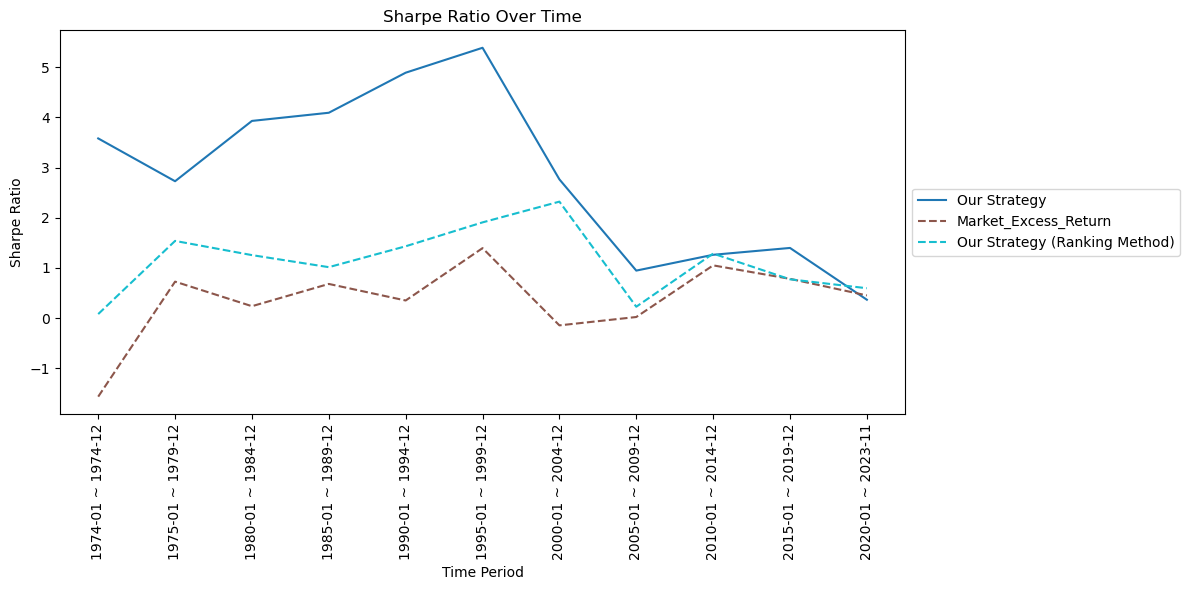

In [154]:
# Define Our Strategy
#'Momentum', 'Value', 'Sector(Familiarity,FOMO,Herding)', 'Valuation Convergence', "Loss Aversion Riding"
# 'Momentum', 'Value'
Strategy_factors_included = ['Momentum', 'Value', 'Sector(Familiarity,FOMO,Herding)', 'Valuation Convergence', "Loss Aversion Riding"]
periods_type = '5y'


measure_concerned = 'sharpe ratio'
performance_stats_recorder = {}
for i in factors_name:
    stats, strategy_periods_stats = Strategy_Testing([i], df_factors, periods_type)
    performance_stats_recorder[i] = strategy_periods_stats[measure_concerned].astype(float)

df_performance_stats_plot = pd.DataFrame(performance_stats_recorder ) 

stats, strategy_periods_stats = Strategy_Testing(Strategy_factors_included, df_factors, periods_type)
statistics_strategy = strategy_periods_stats[measure_concerned]
df_performance_stats_plot['Our Strategy'] = statistics_strategy


# Only Show Revelant Series for presentation
df_performance_stats_plot = df_performance_stats_plot[['Our Strategy', 'Market_Excess_Return', 'Our Strategy (Ranking Method)']]

# Define colors and line styles
colors = plt.cm.get_cmap('tab10', len(df_performance_stats_plot.columns))
line_styles = ['--' if col != 'Our Strategy' else '-' for col in df_performance_stats_plot.columns]

# Plot the DataFrame with custom styles
ax = df_performance_stats_plot.plot(figsize=(12, 6), legend=True, style=line_styles, color=[colors(i) for i in range(len(df_performance_stats_plot.columns))])

# Rotate x-axis tick labels and ensure all are shown
ax.set_xticks(range(len(df_performance_stats_plot)))
ax.set_xticklabels(df_performance_stats_plot.index, rotation=90)




# Position the legend on the right-hand side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.xlabel('Time Period')
plt.ylabel(measure_concerned.title())
plt.title(measure_concerned.title() + ' Over Time')
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [155]:
stats

Strategy_Return
count        599.000000
mean           0.009358
std            0.013358
min           -0.051804
25%            0.000853
50%            0.008381
75%            0.016319
max            0.069735
tstat         17.144875
sharpe         2.426675

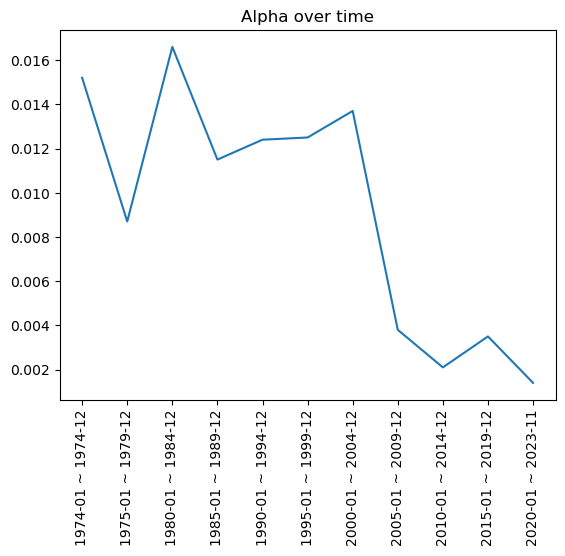

In [156]:
ax = strategy_periods_stats['α'].astype(float).plot()
ax.set_xticks(range(len(strategy_periods_stats)))
ax.set_xticklabels(strategy_periods_stats.index, rotation=90)
plt.title('Alpha over time')
plt.show()

In [157]:
a, b = Strategy_Testing(['Our Strategy (Ranking Method)'], df_factors, periods = '5y')

In [158]:
a

Strategy_Return
count        599.000000
mean           0.019086
std            0.059209
min           -0.273316
25%           -0.013600
50%            0.020209
75%            0.053870
max            0.316395
tstat          7.889420
sharpe         1.116663

In [159]:
b

count    mean     std     min     25%     50%     75%  \
1974-01 ~ 1974-12     12  0.0028  0.1225 -0.1164 -0.0603 -0.0253  0.0158   
1975-01 ~ 1979-12     60  0.0304  0.0684 -0.2404 -0.0105  0.0279  0.0773   
1980-01 ~ 1984-12     60  0.0209  0.0576 -0.1587 -0.0138  0.0194  0.0538   
1985-01 ~ 1989-12     60  0.0164  0.0560 -0.2733 -0.0081  0.0260  0.0482   
1990-01 ~ 1994-12     60  0.0211  0.0511 -0.1371 -0.0103  0.0218  0.0527   
1995-01 ~ 1999-12     60  0.0263  0.0478 -0.1650  0.0003  0.0327  0.0601   
2000-01 ~ 2004-12     60  0.0302  0.0451 -0.1023  0.0060  0.0248  0.0657   
2005-01 ~ 2009-12     60  0.0040  0.0614 -0.2040 -0.0211  0.0082  0.0443   
2010-01 ~ 2014-12     60  0.0193  0.0521 -0.1183 -0.0088  0.0227  0.0498   
2015-01 ~ 2019-12     60  0.0101  0.0453 -0.1026 -0.0189  0.0111  0.0355   
2020-01 ~ 2023-11     47  0.0143  0.0834 -0.2672 -0.0280  0.0237  0.0643   

                      max   tstat  sharpe ratio   MaxDD       α p_value (α)  \
1974-01 ~ 1974-12  0.3164  0.0804        0.0804 -0.3337  0.0506      0.0349   
1975-01 ~ 1979-12  0.2042  3.4385        1.5378 -0.2450  0.0186      0.0007   
1980-01 ~ 1984-12  0.1707  2.8061        1.2549 -0.1909  0.0174      0.0000   
1985-01 ~ 1989-12  0.1119  2.2694        1.0149 -0.3078  0.0063      0.0362   
1990-01 ~ 1994-12  0.1528  3.2000        1.4311 -0.2797  0.0168      0.0000   
1995-01 ~ 1999-12  0.1236  4.2644        1.9071 -0.2225  0.0103      0.0076   
2000-01 ~ 2004-12  0.1080  5.1883        2.3203 -0.1024  0.0317      0.0000   
2005-01 ~ 2009-12  0.1364  0.5068        0.2266 -0.4773  0.0037      0.3707   
2010-01 ~ 2014-12  0.1818  2.8742        1.2854 -0.2324  0.0046      0.0782   
2015-01 ~ 2019-12  0.1348  1.7287        0.7731 -0.1997  0.0016      0.6360   
2020-01 ~ 2023-11  0.2241  1.1780        0.5953 -0.3390  0.0045      0.3982   

                  β_Market p_value (β_Market) R-squared  
1974-01 ~ 1974-12   1.5246             0.0003    0.7443  
1975-01 ~ 1979-12   1.2666             0.0000    0.6734  
1980-01 ~ 1984-12   1.0673             0.0000    0.7533  
1985-01 ~ 1989-12   1.0233             0.0000    0.8440  
1990-01 ~ 1994-12   1.1929             0.0000    0.7104  
1995-01 ~ 1999-12   0.9581             0.0000    0.6920  
2000-01 ~ 2004-12   0.7065             0.0000    0.6011  
2005-01 ~ 2009-12   1.0696             0.0000    0.7392  
2010-01 ~ 2014-12   1.2464             0.0000    0.8693  
2015-01 ~ 2019-12   1.0921             0.0000    0.6931  
2020-01 ~ 2023-11   1.2951             0.0000    0.8217

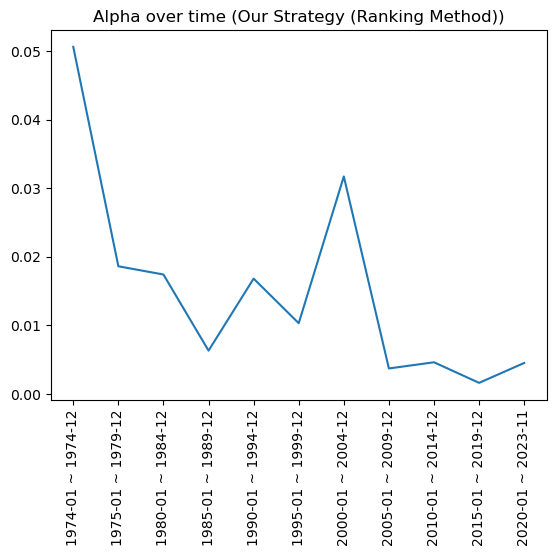

In [160]:
ax = b['α'].astype(float).plot()
ax.set_xticks(range(len(b)))
ax.set_xticklabels(b.index, rotation=90)
plt.title('Alpha over time (Our Strategy (Ranking Method))')
plt.show()

In [161]:
a, b = Strategy_Testing(Strategy_factors_included, df_factors, periods = '5y')

In [162]:
a

Strategy_Return
count        599.000000
mean           0.009358
std            0.013358
min           -0.051804
25%            0.000853
50%            0.008381
75%            0.016319
max            0.069735
tstat         17.144875
sharpe         2.426675

In [163]:
b

count    mean     std     min     25%     50%     75%  \
1974-01 ~ 1974-12     12  0.0179  0.0173 -0.0009  0.0060  0.0099  0.0343   
1975-01 ~ 1979-12     60  0.0101  0.0128 -0.0154  0.0020  0.0089  0.0144   
1980-01 ~ 1984-12     60  0.0165  0.0145 -0.0159  0.0072  0.0149  0.0237   
1985-01 ~ 1989-12     60  0.0120  0.0102 -0.0078  0.0055  0.0100  0.0172   
1990-01 ~ 1994-12     60  0.0128  0.0091 -0.0028  0.0082  0.0115  0.0189   
1995-01 ~ 1999-12     60  0.0128  0.0082 -0.0074  0.0071  0.0127  0.0193   
2000-01 ~ 2004-12     60  0.0139  0.0174 -0.0281  0.0036  0.0122  0.0250   
2005-01 ~ 2009-12     60  0.0038  0.0139 -0.0518 -0.0016  0.0045  0.0098   
2010-01 ~ 2014-12     60  0.0033  0.0092 -0.0126 -0.0014  0.0023  0.0072   
2015-01 ~ 2019-12     60  0.0033  0.0082 -0.0114 -0.0027  0.0024  0.0093   
2020-01 ~ 2023-11     47  0.0017  0.0163 -0.0381 -0.0090  0.0008  0.0124   

                      max    tstat  sharpe ratio   MaxDD       α p_value (α)  \
1974-01 ~ 1974-12  0.0455   3.5795        3.5795 -0.0009  0.0152      0.0191   
1975-01 ~ 1979-12  0.0665   6.0974        2.7268 -0.0193  0.0087      0.0000   
1980-01 ~ 1984-12  0.0552   8.7841        3.9284 -0.0239  0.0166      0.0000   
1985-01 ~ 1989-12  0.0554   9.1478        4.0910 -0.0078  0.0115      0.0000   
1990-01 ~ 1994-12  0.0354  10.9321        4.8890 -0.0028  0.0124      0.0000   
1995-01 ~ 1999-12  0.0340  12.0421        5.3854 -0.0074  0.0125      0.0000   
2000-01 ~ 2004-12  0.0697   6.1804        2.7640 -0.0281  0.0137      0.0000   
2005-01 ~ 2009-12  0.0385   2.1159        0.9463 -0.0922  0.0038      0.0399   
2010-01 ~ 2014-12  0.0363   2.8205        1.2614 -0.0222  0.0021      0.0641   
2015-01 ~ 2019-12  0.0274   3.1256        1.3978 -0.0240  0.0035      0.0023   
2020-01 ~ 2023-11  0.0658   0.7245        0.3661 -0.0663  0.0014      0.5668   

                  β_Market p_value (β_Market) R-squared  
1974-01 ~ 1974-12  -0.0870             0.2676    0.1211  
1975-01 ~ 1979-12   0.1444             0.0000    0.2510  
1980-01 ~ 1984-12  -0.0482             0.2363    0.0241  
1985-01 ~ 1989-12   0.0486             0.0643    0.0578  
1990-01 ~ 1994-12   0.1166             0.0002    0.2154  
1995-01 ~ 1999-12   0.0219             0.4017    0.0122  
2000-01 ~ 2004-12  -0.1183             0.0086    0.1130  
2005-01 ~ 2009-12  -0.0118             0.7514    0.0017  
2010-01 ~ 2014-12   0.1033             0.0004    0.1930  
2015-01 ~ 2019-12  -0.0216             0.4876    0.0083  
2020-01 ~ 2023-11   0.0447             0.2809    0.0258

In [164]:
a, b = Strategy_Testing(['Market_Excess_Return'], df_factors, periods = '5y')

In [165]:
a

Strategy_Return
count        599.000000
mean           0.006042
std            0.045996
min           -0.230869
25%           -0.020911
50%            0.009828
75%            0.035217
max            0.160484
tstat          3.214780
sharpe         0.455018

In [166]:
b

count    mean     std     min     25%     50%     75%  \
1974-01 ~ 1974-12     12 -0.0313  0.0693 -0.1172 -0.0589 -0.0404 -0.0232   
1975-01 ~ 1979-12     60  0.0093  0.0443 -0.1176 -0.0158  0.0033  0.0407   
1980-01 ~ 1984-12     60  0.0032  0.0468 -0.1319 -0.0295  0.0046  0.0315   
1985-01 ~ 1989-12     60  0.0099  0.0503 -0.2309 -0.0122  0.0115  0.0414   
1990-01 ~ 1994-12     60  0.0037  0.0361 -0.0981 -0.0206  0.0082  0.0237   
1995-01 ~ 1999-12     60  0.0167  0.0415 -0.1620 -0.0071  0.0251  0.0458   
2000-01 ~ 2004-12     60 -0.0021  0.0495 -0.1075 -0.0318  0.0083  0.0287   
2005-01 ~ 2009-12     60  0.0003  0.0493 -0.1856 -0.0202  0.0083  0.0318   
2010-01 ~ 2014-12     60  0.0118  0.0390 -0.0850 -0.0143  0.0191  0.0376   
2015-01 ~ 2019-12     60  0.0078  0.0346 -0.0918 -0.0000  0.0106  0.0265   
2020-01 ~ 2023-11     47  0.0076  0.0584 -0.1428 -0.0309  0.0118  0.0486   

                      max   tstat  sharpe ratio   MaxDD        α p_value (α)  \
1974-01 ~ 1974-12  0.1605 -1.5647       -1.5647 -0.3766  -0.0000      0.3492   
1975-01 ~ 1979-12  0.1357  1.6245        0.7265 -0.1470   0.0000      0.0008   
1980-01 ~ 1984-12  0.1123  0.5306        0.2373 -0.3450  -0.0000      0.0000   
1985-01 ~ 1989-12  0.1238  1.5223        0.6808 -0.3083  -0.0000      0.0003   
1990-01 ~ 1994-12  0.1032  0.7847        0.3509 -0.1898  -0.0000      0.0011   
1995-01 ~ 1999-12  0.0795  3.1170        1.3940 -0.1874   0.0000      1.0000   
2000-01 ~ 2004-12  0.0819 -0.3233       -0.1446 -0.4966  -0.0000      0.7613   
2005-01 ~ 2009-12  0.1093  0.0489        0.0219 -0.5251   0.0000      0.7809   
2010-01 ~ 2014-12  0.1141  2.3495        1.0507 -0.1851   0.0000      0.0365   
2015-01 ~ 2019-12  0.0864  1.7490        0.7822 -0.1478  -0.0000      0.0000   
2020-01 ~ 2023-11  0.1296  0.8944        0.4520 -0.2530  -0.0000      0.0000   

                  β_Market p_value (β_Market) R-squared  
1974-01 ~ 1974-12   1.0000             0.0000    1.0000  
1975-01 ~ 1979-12   1.0000             0.0000    1.0000  
1980-01 ~ 1984-12   1.0000             0.0000    1.0000  
1985-01 ~ 1989-12   1.0000             0.0000    1.0000  
1990-01 ~ 1994-12   1.0000             0.0000    1.0000  
1995-01 ~ 1999-12   1.0000             0.0000    1.0000  
2000-01 ~ 2004-12   1.0000             0.0000    1.0000  
2005-01 ~ 2009-12   1.0000             0.0000    1.0000  
2010-01 ~ 2014-12   1.0000             0.0000    1.0000  
2015-01 ~ 2019-12   1.0000             0.0000    1.0000  
2020-01 ~ 2023-11   1.0000             0.0000    1.0000

# Function Versions


def perf_plotting(ports, factor_concerned):
    # Version 1


    # Define a list of past recession ending months
    recession_ending_months = [
        '1980-01-31',  # End of the recession in January 1980
        '1981-07-31',  # End of the recession in July 1981
        '1991-03-31',  # End of the recession in March 1991
        '2001-11-30',  # End of the recession in November 2001
        '2009-06-30'   # End of the recession in June 2009
    ]
    
    # Function to add n months to a given date
    def add_months(date, months):
        year = int(date[:4])
        month = int(date[5:7])
        new_month = month + months
        if new_month > 12:
            year += 1
            new_month -= 12
        return f"{year}-{new_month:02d}-01"
    
    # Add 2 months to each recession ending month and ensure it's the end of the month
    normalize_dates = [(pd.to_datetime(add_months(date, 3)) - pd.offsets.MonthEnd()).strftime('%Y-%m-%d') for date in recession_ending_months]

    
    ports_temp = pd.DataFrame(ports)
    ports_temp = (ports_temp['RET']+1).groupby('Q').cumprod()
    ports_temp = ports_temp.reset_index().pivot(index='DATE', columns='Q', values='RET')
    
    for i in normalize_dates:
        temp_date_condition = ports_temp.index >= i
        ports_temp[temp_date_condition] = ports_temp[temp_date_condition]/ports_temp[temp_date_condition].iloc[0]
    '''
    # Plotting data Version 1 --------------------------------
    ports_temp.plot()
    plt.title('Performance of each portfolio ($1 invested)')
    plt.xlabel('Year')
    plt.ylabel('Log($ Portfolio Value)')
    plt.grid(axis='y')
    plt.yscale('log')  # Set y-axis to log scale
    
    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        plt.axvline(x=date, color='red', linestyle='--', linewidth=0.5)

    '''
    # Plotting data Version 2 --------------------------------
    for col in ports_temp.columns:
        temp = ports_temp[col].copy()
        for date in normalize_dates:
            temp[date] = np.nan  # Add NaN at the normalized dates for each quantile
        plt.plot(temp.index, temp, label=col)
    
    plt.title('Performance of each portfolio ($1 invested)')
    plt.xlabel('Year')
    plt.ylabel('$ Portfolio Value')
    
    plt.grid(axis='y')
    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        plt.axvline(x=mdates.date2num(pd.to_datetime(date)), color='r', linestyle='--', linewidth=0.5)
    plt.legend(title='Q', loc='upper left')
    
    #--------------------------------
    
    # Add footnote
    plt.text(0, -0.2, 'Note: \n 1.Portfolios are rebalanced based on ranking each month. \n 2.Q: Ranked by '+factor_concerned+ '. The higher the Q, the higher the rank.\n 3.Red Dash lines are reset dates to reflect several economy recovery periods following a recession. \n    At each reset date, all portfolio values are reset to $1 to make subsequent performance comparable.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()

def perf_plotting(ports, factor_concerned, q=5):# version 2


    
    # Define a list of past recession ending months
    recession_ending_months = [
        '1980-01-31',  # End of the recession in January 1980
        '1981-07-31',  # End of the recession in July 1981
        '1991-03-31',  # End of the recession in March 1991
        '2001-11-30',  # End of the recession in November 2001
        '2009-06-30',   # End of the recession in June 2009
        '2020-04-30',
    ]
    
    # Function to add n months to a given date
    def add_months(date, months):
        year = int(date[:4])
        month = int(date[5:7])
        new_month = month + months
        if new_month > 12:
            year += 1
            new_month -= 12
        return f"{year}-{new_month:02d}-01"
    
    # Add 2 months to each recession ending month and ensure it's the end of the month
    normalize_dates = [(pd.to_datetime(add_months(date, 3)) - pd.offsets.MonthEnd()).strftime('%Y-%m-%d') for date in recession_ending_months]

    
    

    #----- Plot 1: Factor Return-----------------------------------------------
    ports_temp = pd.DataFrame(ports)

    hml_temp = ports_temp.copy()
    hml_temp = pd.DataFrame(ports.loc[q] - ports.loc[1])

    
    # Calculating 3 month trailing return
    hml_temp['3 months trailing return']= (hml_temp['RET']+1).rolling(window=3).apply(lambda x: x.prod()) -1
    # Calculating 1 year trailing return
    hml_temp['1 year trailing return']= (hml_temp['RET']+1).rolling(window=12).apply(lambda x: x.prod()) -1
    print(normalize_dates)
    print(hml_temp.index)
    
    ax = hml_temp[['3 months trailing return','1 year trailing return']].plot()

    
    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        ax.axvline(x=date, color='r', linestyle='--', linewidth=0.5)

    

    plt.title("Factor's Holding Period Return")
    plt.grid(axis='y')
    plt.text(0, -0.15, 'Note: 1.Red Dash lines are dates to reflect several economy recovery periods following a recession.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()

    
    #-------Plot 2: Quantile Portfolio Investment Performance--------------------------
    ports_temp = pd.DataFrame(ports)
    ports_temp = (ports_temp['RET']+1).groupby('Q').cumprod()
    ports_temp = ports_temp.reset_index().pivot(index='DATE', columns='Q', values='RET')
    for i in normalize_dates:
        temp_date_condition = ports_temp.index >= i
        ports_temp[temp_date_condition] = ports_temp[temp_date_condition]/ports_temp[temp_date_condition].iloc[0]

    for col in ports_temp.columns:
        temp = ports_temp[col].copy()
        for date in normalize_dates:
            temp[date] = np.nan  # Add NaN at the normalized dates for each quantile
        plt.plot(temp.index, temp, label=col)
    
    plt.title('Performance of each portfolio ($1 invested)')
    plt.xlabel('Year')
    plt.ylabel('$ Portfolio Value')
    
    plt.grid(axis='y')
    
    # Add vertical lines at normalized dates
    for date in normalize_dates:
        plt.axvline(x=mdates.date2num(pd.to_datetime(date)), color='r', linestyle='--', linewidth=0.5)
    plt.legend(title='Q', loc='upper left')
    
    #--------------------------------
    
    # Add footnote
    plt.text(0, -0.2, 'Note: \n 1.Portfolios are rebalanced based on ranking each month. \n 2.Q: Ranked by '+factor_concerned+ '. The higher the Q, the higher the rank.\n 3.Red Dash lines are reset dates to reflect several economy recovery periods following a recession. \n    At each reset date, all portfolio values are reset to $1 to make subsequent performance comparable.', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8, color='black')
    
    plt.show()
